# Описание задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  

import os
import os.path

import re

import datetime

import phik

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from catboost import CatBoostClassifier

import lightgbm as lgb
import random

from tensorflow import keras
import tensorflow as tf

In [2]:
try:
    os.listdir('final_provider')
except:
    print('Not local machine')

In [3]:
try:
    contracts, internet, personal, phones = [pd.read_csv('final_provider/'+el) for el in os.listdir('final_provider')] 
except:
    contracts = pd.read_csv('/datasets/final_provider/.contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phones = pd.read_csv('/datasets/final_provider/phone.csv')

# Базовая предобработка таблиц перед слиянием

## Контракты

In [4]:
contracts

customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0                 Yes           Electronic check           29.85        29.85  
1                  No               Mailed check           56.95       1889.5  
2                 Yes               Mailed check           53.85       108.15  
3                  No  Bank transfer (automatic)           42.30      1840.75  
4                 Yes           Electronic check           70.70       151.65  
...               ...                        ...             ...          ...  
7038              Yes               Mailed check           84.80       1990.5  
7039              Yes    Credit card (automatic)          103.20       7362.9  
7040              Yes           Electronic check           29.60       346.45  
7041              Yes               Mailed check           74.40        306.6  
7042              Yes  Bank transfer (automatic)          105.65       6844.5  

[7043 rows x 8 columns]

In [5]:
def describer(data):
    temp = data.describe()
    temp.loc['nan'] = [data[el].isna().sum() for el in data.describe().columns]
    temp.loc['duplicates'] = [data.duplicated().sum() for el in data.describe().columns]
    display(temp)
    
    for el in data.columns:
        print(el)
        print(data[el].value_counts(dropna=False))
        print()
        print(f'{el} NAN: {data[el].isna().sum()}')
        print(f'{el} unique: {data[el].nunique()}')
        print()

In [6]:
describer(contracts)

MonthlyCharges
count          7043.000000
mean             64.761692
std              30.090047
min              18.250000
25%              35.500000
50%              70.350000
75%              89.850000
max             118.750000
nan               0.000000
duplicates        0.000000

customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

customerID NAN: 0
customerID unique: 7043

BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

BeginDate NAN: 0
BeginDate unique: 77

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

EndDate NAN: 0
EndDate unique: 5

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Type NAN: 0
Type unique: 3

PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

PaperlessBilling

In [7]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Что мы видим:

1. Каждый контракт соответствует одному клиенту - повторяющихся customer_id нет.

2. Пропусков также нет, однако есть пустые значения по __total_charges__ - это нужно исправить; также нужно привести столбец к нужному числовому формату.

3. Видим дисбаланс среди тех, кто контракт расторгнул и теми, кто всё еще пользуется услугами - соотношение примерно 2 к 5.

4. Нужно привести даты к нужному формату и выделить столбец _target_ - после этого все _no_ в __enddate__ можно заменить на дату сбора данных, чтобы отдельно выделить столбец с продолжительностью использования услуг.

Других проблем в данной таблице пока не обнаружено

__Пропуски по TotalCharges и формат данных__ 

In [8]:
contracts.loc[contracts.TotalCharges==' ']

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               
3331               Mailed check           19.85               
3826               Mailed check           25.35               
4380               Mailed check           20.00               
5218               Mailed check           19.70               
6670               Mailed check           73.35               
6754  Bank transfer (automatic)           61.90

Пропуски мы имеем только по клиентам, которые подключились в месяц сбора статистики - эти 11 строк мы отбросим, ничего ценного для нас они не несут:

In [9]:
contracts = contracts.drop(contracts.loc[contracts.TotalCharges==' '].index).reset_index(drop=True)
contracts.TotalCharges = contracts.TotalCharges.astype(np.float32)

__Формат дат__

In [10]:
contracts['BeginDate'] = pd.to_datetime(contracts.BeginDate)
contracts.loc[contracts.EndDate == 'No','target'] = 0
contracts.loc[contracts.EndDate != 'No','target'] = 1
contracts['EndDate_remake'] = contracts.EndDate.replace('No','2020-02-01')

contracts.EndDate_remake = pd.to_datetime(contracts.EndDate_remake)

In [11]:
contracts['activity'] = (contracts.EndDate_remake - contracts.BeginDate).dt.days

In [12]:
contracts

customerID  BeginDate              EndDate            Type  \
0     7590-VHVEG 2020-01-01                   No  Month-to-month   
1     5575-GNVDE 2017-04-01                   No        One year   
2     3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW 2016-05-01                   No        One year   
4     9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...        ...                  ...             ...   
7027  6840-RESVB 2018-02-01                   No        One year   
7028  2234-XADUH 2014-02-01                   No        One year   
7029  4801-JZAZL 2019-03-01                   No  Month-to-month   
7030  8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   
7031  3186-AJIEK 2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes           Electronic check           29.85   
1                  No               Mailed check           56.95   
2                 Yes               Mailed check           53.85   
3                  No  Bank transfer (automatic)           42.30   
4                 Yes           Electronic check           70.70   
...               ...                        ...             ...   
7027              Yes               Mailed check           84.80   
7028              Yes    Credit card (automatic)          103.20   
7029              Yes           Electronic check           29.60   
7030              Yes               Mailed check           74.40   
7031              Yes  Bank transfer (automatic)          105.65   

      TotalCharges  target EndDate_remake  activity  
0        29.850000     0.0     2020-02-01        31  
1      1889.500000     0.0     2020-02-01      1036  
2       108.150002     1.0     2019-12-01        61  
3      1840.750000     0.0     2020-02-01      1371  
4       151.649994     1.0     2019-11-01        61  
...            ...     ...            ...       ...  
7027   1990.500000     0.0     2020-02-01       730  
7028   7362.899902     0.0     2020-02-01      2191  
7029    346.450012     0.0     2020-02-01       337  
7030    306.600006     1.0     2019-11-01       123  
7031   6844.500000     0.0     2020-02-01      2010  

[7032 rows x 11 columns]

Интересно, есть ли зависимость между датой заключения договора и количеством расторжений?

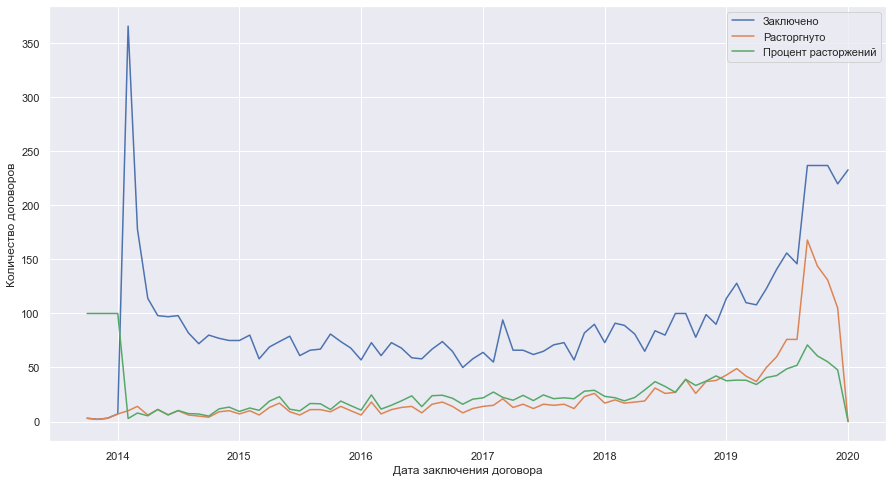

In [13]:
begin_pivot = pd.pivot_table(contracts, index='BeginDate', values='target',aggfunc=['count','sum']).reset_index()
begin_pivot.columns = ['date','total','closed']
begin_pivot['closed_part'] = begin_pivot.closed / begin_pivot.total * 100

sns.set()
plt.figure(figsize=(15,8))
plt.plot(begin_pivot.date, begin_pivot.total,begin_pivot.date, begin_pivot.closed,begin_pivot.date, begin_pivot.closed_part)
plt.xlabel('Дата заключения договора')
plt.ylabel('Количество договоров')
plt.legend(['Заключено','Расторгнуто','Процент расторжений'])

Видим всплеск заключений и расторжений договоров по дате заключения - во второй половине 2019 года - так же, как и рост процента расторжений договоров; возможно это вызвано обширной рекламной компанией, которая, однако, не совсем корректно была настроена и привлекала нецелевых клиентов, которые отказывались от услуг провайдера.

В целом же мы видим весьма высокий уровень удержания среди старых клиентов - возможно, они пользуются очень выгодными архивными тарифами

## Интернет

Здесь мы видим дополнительные услуги, подключенные пользователяем интернета

In [14]:
internet

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

In [15]:
describer(internet)

customerID InternetService OnlineSecurity OnlineBackup  \
count             5517            5517           5517         5517   
unique            5517               2              2            2   
top         7590-VHVEG     Fiber optic             No           No   
freq                 1            3096           3498         3088   
nan                  0               0              0            0   
duplicates           0               0              0            0   

           DeviceProtection TechSupport StreamingTV StreamingMovies  
count                  5517        5517        5517            5517  
unique                    2           2           2               2  
top                      No          No          No              No  
freq                   3095        3473        2810            2785  
nan                       0           0           0               0  
duplicates                0           0           0               0

customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

customerID NAN: 0
customerID unique: 5517

InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

InternetService NAN: 0
InternetService unique: 2

OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

OnlineSecurity NAN: 0
OnlineSecurity unique: 2

OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

OnlineBackup NAN: 0
OnlineBackup unique: 2

DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

DeviceProtection NAN: 0
DeviceProtection unique: 2

TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64

TechSupport NAN: 0
TechSupport unique: 2

StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

StreamingTV NAN: 0
StreamingTV u

Дубликатов и пропусков также не видим и здесь

## Personal

In [16]:
personal

customerID  gender  SeniorCitizen Partner Dependents
0     7590-VHVEG  Female              0     Yes         No
1     5575-GNVDE    Male              0      No         No
2     3668-QPYBK    Male              0      No         No
3     7795-CFOCW    Male              0      No         No
4     9237-HQITU  Female              0      No         No
...          ...     ...            ...     ...        ...
7038  6840-RESVB    Male              0     Yes        Yes
7039  2234-XADUH  Female              0     Yes        Yes
7040  4801-JZAZL  Female              0     Yes        Yes
7041  8361-LTMKD    Male              1     Yes         No
7042  3186-AJIEK    Male              0      No         No

[7043 rows x 5 columns]

In [17]:
describer(personal)

SeniorCitizen
count         7043.000000
mean             0.162147
std              0.368612
min              0.000000
25%              0.000000
50%              0.000000
75%              0.000000
max              1.000000
nan              0.000000
duplicates       0.000000

customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

customerID NAN: 0
customerID unique: 7043

gender
Male      3555
Female    3488
Name: gender, dtype: int64

gender NAN: 0
gender unique: 2

SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

SeniorCitizen NAN: 0
SeniorCitizen unique: 2

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Partner NAN: 0
Partner unique: 2

Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64

Dependents NAN: 0
Dependents unique: 2



In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Также с данными все в порядке

## Phones

In [19]:
phones

customerID MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]

In [20]:
describer(phones)

customerID MultipleLines
count             6361          6361
unique            6361             2
top         5575-GNVDE            No
freq                 1          3390
nan                  0             0
duplicates           0             0

customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

customerID NAN: 0
customerID unique: 6361

MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64

MultipleLines NAN: 0
MultipleLines unique: 2



Также не видим пропусков и дубликатов.

На данный момент план работы очень простой:
1. Объединить все таблицы в одну.
2. Решить, чем заменять пропуски в каждой конкретной ситуации.
3. Посмотреть на распределения непрерывных фичей, возможно - удалить выбросы.
4. Выделить таргет (факт расторжения договора) в отдельный столбец.
5. Посмотреть на матрицу корреляции, выбрать коллинеарные фичи, решить как и в каком порядке мы будем их выбрасывать
6. Попробовать feature engeneering: перемножить попарно фичи друг на друга, а также прологарифмировать, взять вторую и третью степени - возможно обнаружим лучшие корреляции, чем с первоначальными фичами


# EDA

In [21]:
df = contracts.merge(internet, on='customerID', how='left')

In [22]:
df = df.merge(personal, on='customerID', how='left')
df = df.merge(phones, on='customerID', how='left')

In [23]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower() for column in df.columns]

In [24]:
df

customer_i_d begin_date             end_date            type  \
0      7590-VHVEG 2020-01-01                   No  Month-to-month   
1      5575-GNVDE 2017-04-01                   No        One year   
2      3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3      7795-CFOCW 2016-05-01                   No        One year   
4      9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
...           ...        ...                  ...             ...   
7027   6840-RESVB 2018-02-01                   No        One year   
7028   2234-XADUH 2014-02-01                   No        One year   
7029   4801-JZAZL 2019-03-01                   No  Month-to-month   
7030   8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   
7031   3186-AJIEK 2014-08-01                   No        Two year   

     paperless_billing             payment_method  monthly_charges  \
0                  Yes           Electronic check            29.85   
1                   No               Mailed check            56.95   
2                  Yes               Mailed check            53.85   
3                   No  Bank transfer (automatic)            42.30   
4                  Yes           Electronic check            70.70   
...                ...                        ...              ...   
7027               Yes               Mailed check            84.80   
7028               Yes    Credit card (automatic)           103.20   
7029               Yes           Electronic check            29.60   
7030               Yes               Mailed check            74.40   
7031               Yes  Bank transfer (automatic)           105.65   

      total_charges  target end_date_remake  ...  online_backup  \
0         29.850000     0.0      2020-02-01  ...            Yes   
1       1889.500000     0.0      2020-02-01  ...             No   
2        108.150002     1.0      2019-12-01  ...            Yes   
3       1840.750000     0.0      2020-02-01  ...             No   
4        151.649994     1.0      2019-11-01  ...             No   
...             ...     ...             ...  ...            ...   
7027    1990.500000     0.0      2020-02-01  ...             No   
7028    7362.899902     0.0      2020-02-01  ...            Yes   
7029     346.450012     0.0      2020-02-01  ...             No   
7030     306.600006     1.0      2019-11-01  ...             No   
7031    6844.500000     0.0      2020-02-01  ...             No   

     device_protection tech_support streaming_t_v streaming_movies  gender  \
0                   No           No            No               No  Female   
1                  Yes           No            No               No    Male   
2                   No           No            No               No    Male   
3                  Yes          Yes            No               No    Male   
4                   No           No            No               No  Female   
...                ...          ...           ...              ...     ...   
7027               Yes          Yes           Yes              Yes    Male   
7028               Yes           No           Yes              Yes  Female   
7029                No           No            No               No  Female   
7030                No           No            No               No    Male   
7031               Yes          Yes           Yes              Yes    Male   

     senior_citizen partner dependents  multiple_lines  
0                 0     Yes         No             NaN  
1                 0      No         No              No  
2                 0      No         No              No  
3                 0      No         No             NaN  
4                 0      No         No              No  
...             ...     ...        ...             ...  
7027              0     Yes        Yes             Yes  
7028              0     Yes        Yes             Yes  
7029              0     Yes        Yes             NaN  
7030              1    

Для начала - отбросим столбец с айдишниками клиентов (все уникальны, корреляции нет) и заменим все _Yes и No_ на нули и единицы для простоты:

In [25]:
repl = {'Yes':1,'No':0}
df = df.replace(repl)
df = df.drop(columns='customer_i_d')

In [26]:
df

begin_date             end_date            type  paperless_billing  \
0    2020-01-01                    0  Month-to-month                  1   
1    2017-04-01                    0        One year                  0   
2    2019-10-01  2019-12-01 00:00:00  Month-to-month                  1   
3    2016-05-01                    0        One year                  0   
4    2019-09-01  2019-11-01 00:00:00  Month-to-month                  1   
...         ...                  ...             ...                ...   
7027 2018-02-01                    0        One year                  1   
7028 2014-02-01                    0        One year                  1   
7029 2019-03-01                    0  Month-to-month                  1   
7030 2019-07-01  2019-11-01 00:00:00  Month-to-month                  1   
7031 2014-08-01                    0        Two year                  1   

                 payment_method  monthly_charges  total_charges  target  \
0              Electronic check            29.85      29.850000     0.0   
1                  Mailed check            56.95    1889.500000     0.0   
2                  Mailed check            53.85     108.150002     1.0   
3     Bank transfer (automatic)            42.30    1840.750000     0.0   
4              Electronic check            70.70     151.649994     1.0   
...                         ...              ...            ...     ...   
7027               Mailed check            84.80    1990.500000     0.0   
7028    Credit card (automatic)           103.20    7362.899902     0.0   
7029           Electronic check            29.60     346.450012     0.0   
7030               Mailed check            74.40     306.600006     1.0   
7031  Bank transfer (automatic)           105.65    6844.500000     0.0   

     end_date_remake  activity  ... online_backup  device_protection  \
0         2020-02-01        31  ...           1.0                0.0   
1         2020-02-01      1036  ...           0.0                1.0   
2         2019-12-01        61  ...           1.0                0.0   
3         2020-02-01      1371  ...           0.0                1.0   
4         2019-11-01        61  ...           0.0                0.0   
...              ...       ...  ...           ...                ...   
7027      2020-02-01       730  ...           0.0                1.0   
7028      2020-02-01      2191  ...           1.0                1.0   
7029      2020-02-01       337  ...           0.0                0.0   
7030      2019-11-01       123  ...           0.0                0.0   
7031      2020-02-01      2010  ...           0.0                1.0   

      tech_support  streaming_t_v  streaming_movies  gender  senior_citizen  \
0              0.0            0.0               0.0  Female               0   
1              0.0            0.0               0.0    Male               0   
2              0.0            0.0               0.0    Male               0   
3              1.0            0.0               0.0    Male               0   
4              0.0            0.0               0.0  Female               0   
...            ...            ...               ...     ...             ...   
7027           1.0            1.0               1.0    Male               0   
7028           0.0            1.0               1.0  Female               0   
7029           0.0            0.0               0.0  Female               0   
7030           0.0            0.0               0.0    Male               1   
7031           1.0            1.0               1.0    Male               0   

     partner  dependents  multiple_lines  
0          1           0             NaN  
1          0           0             0.0  
2          0           0             0.0  
3          0           0             NaN  
4          0           0             0.0  
...      ...         ...             ...  
7027       1           1             1.0  
7028       1           1             1.0  
70

In [27]:
describer(df)

paperless_billing  monthly_charges  total_charges       target  \
count             7032.000000      7032.000000    7032.000000  7032.000000   
mean                 0.592719        64.798208    2283.298340     0.265785   
std                  0.491363        30.085974    2266.770508     0.441782   
min                  0.000000        18.250000      18.799999     0.000000   
25%                  0.000000        35.587500     401.449997     0.000000   
50%                  1.000000        70.350000    1397.475037     0.000000   
75%                  1.000000        89.862500    3794.737488     1.000000   
max                  1.000000       118.750000    8684.799805     1.000000   
nan                  0.000000         0.000000       0.000000     0.000000   
duplicates          13.000000        13.000000      13.000000    13.000000   

               activity  online_security  online_backup  device_protection  \
count       7032.000000      5512.000000    5512.000000        5512.000000   
mean         987.538538         0.365566       0.439949           0.438679   
std          747.153663         0.481632       0.496426           0.496271   
min           30.000000         0.000000       0.000000           0.000000   
25%          275.000000         0.000000       0.000000           0.000000   
50%          883.000000         0.000000       0.000000           0.000000   
75%         1676.000000         1.000000       1.000000           1.000000   
max         2191.000000         1.000000       1.000000           1.000000   
nan            0.000000      1520.000000    1520.000000        1520.000000   
duplicates    13.000000        13.000000      13.000000          13.000000   

            tech_support  streaming_t_v  streaming_movies  senior_citizen  \
count        5512.000000    5512.000000       5512.000000     7032.000000   
mean            0.370102       0.490385          0.495464        0.162400   
std             0.482875       0.499953          0.500025        0.368844   
min             0.000000       0.000000          0.000000        0.000000   
25%             0.000000       0.000000          0.000000        0.000000   
50%             0.000000       0.000000          0.000000        0.000000   
75%             1.000000       1.000000          1.000000        0.000000   
max             1.000000       1.000000          1.000000        1.000000   
nan          1520.000000    1520.000000       1520.000000        0.000000   
duplicates     13.000000      13.000000         13.000000       13.000000   

                partner   dependents  multiple_lines  
count       7032.000000  7032.000000     6352.000000  
mean           0.482509     0.298493        0.467097  
std            0.499729     0.457629        0.498955  
min            0.000000     0.000000        0.000000  
25%            0.000000     0.000000        0.000000  
50%            0.000000     0.000000        0.000000  
75%            1.000000     1.000000        1.000000  
max            1.000000     1.000000        1.000000  
nan            0.000000     0.000000      680.000000  
duplicates    13.000000    13.000000       13.000000

begin_date
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2016-11-01     50
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 76, dtype: int64

begin_date NAN: 0
begin_date unique: 76

end_date
0                      5163
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

end_date NAN: 0
end_date unique: 5

type
Month-to-month    3875
Two year          1685
One year          1472
Name: type, dtype: int64

type NAN: 0
type unique: 3

paperless_billing
1    4168
0    2864
Name: paperless_billing, dtype: int64

paperless_billing NAN: 0
paperless_billing unique: 2

payment_method
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_method, dtype: int64

payment_method NAN: 0
payment_method unique: 

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   int64         
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float32       
 7   target             7032 non-null   float64       
 8   end_date_remake    7032 non-null   datetime64[ns]
 9   activity           7032 non-null   int64         
 10  internet_service   5512 non-null   object        
 11  online_security    5512 non-null   float64       
 12  online_backup      5512 non-null   float64       
 13  device_protection  5512 non-null   float64       
 14  tech_sup

Фиксируем пропуски по:
- доп. услугам при подключении интернета - заменим их просто на нули
- пропуски по подключению нескольких телефонных линий одному клиенту - также заполним нулями
- в то же время используем эту фичу для определения, а подключен ли телефон вообще
- пропуски по типу подключения интернета заменим на _no_internet_


In [29]:
df['phone'] = ~df.multiple_lines.isna() * 1

In [30]:
df

begin_date             end_date            type  paperless_billing  \
0    2020-01-01                    0  Month-to-month                  1   
1    2017-04-01                    0        One year                  0   
2    2019-10-01  2019-12-01 00:00:00  Month-to-month                  1   
3    2016-05-01                    0        One year                  0   
4    2019-09-01  2019-11-01 00:00:00  Month-to-month                  1   
...         ...                  ...             ...                ...   
7027 2018-02-01                    0        One year                  1   
7028 2014-02-01                    0        One year                  1   
7029 2019-03-01                    0  Month-to-month                  1   
7030 2019-07-01  2019-11-01 00:00:00  Month-to-month                  1   
7031 2014-08-01                    0        Two year                  1   

                 payment_method  monthly_charges  total_charges  target  \
0              Electronic check            29.85      29.850000     0.0   
1                  Mailed check            56.95    1889.500000     0.0   
2                  Mailed check            53.85     108.150002     1.0   
3     Bank transfer (automatic)            42.30    1840.750000     0.0   
4              Electronic check            70.70     151.649994     1.0   
...                         ...              ...            ...     ...   
7027               Mailed check            84.80    1990.500000     0.0   
7028    Credit card (automatic)           103.20    7362.899902     0.0   
7029           Electronic check            29.60     346.450012     0.0   
7030               Mailed check            74.40     306.600006     1.0   
7031  Bank transfer (automatic)           105.65    6844.500000     0.0   

     end_date_remake  activity  ... device_protection  tech_support  \
0         2020-02-01        31  ...               0.0           0.0   
1         2020-02-01      1036  ...               1.0           0.0   
2         2019-12-01        61  ...               0.0           0.0   
3         2020-02-01      1371  ...               1.0           1.0   
4         2019-11-01        61  ...               0.0           0.0   
...              ...       ...  ...               ...           ...   
7027      2020-02-01       730  ...               1.0           1.0   
7028      2020-02-01      2191  ...               1.0           0.0   
7029      2020-02-01       337  ...               0.0           0.0   
7030      2019-11-01       123  ...               0.0           0.0   
7031      2020-02-01      2010  ...               1.0           1.0   

      streaming_t_v  streaming_movies  gender  senior_citizen  partner  \
0               0.0               0.0  Female               0        1   
1               0.0               0.0    Male               0        0   
2               0.0               0.0    Male               0        0   
3               0.0               0.0    Male               0        0   
4               0.0               0.0  Female               0        0   
...             ...               ...     ...             ...      ...   
7027            1.0               1.0    Male               0        1   
7028            1.0               1.0  Female               0        1   
7029            0.0               0.0  Female               0        1   
7030            0.0               0.0    Male               1        1   
7031            1.0               1.0    Male               0        0   

     dependents  multiple_lines  phone  
0             0             NaN      0  
1             0             0.0      1  
2             0             0.0      1  
3             0             NaN      0  
4             0             0.0      1  
...         ...             ...    ...  
7027          1             1.0      1  
7028          1             1.0      1  
7029          1             NaN      0  
7030          0             1.0      1  
7031      

In [31]:
df.internet_service = df.internet_service.fillna('no_internet')

df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   int64         
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float32       
 7   target             7032 non-null   float64       
 8   end_date_remake    7032 non-null   datetime64[ns]
 9   activity           7032 non-null   int64         
 10  internet_service   7032 non-null   object        
 11  online_security    7032 non-null   float64       
 12  online_backup      7032 non-null   float64       
 13  device_protection  7032 non-null   float64       
 14  tech_sup

У нас остались столбцы с датами - их мы пока оставим, хотя в дальнейшем они не пригодятся.

Также остались 4 параметра с типом _object_: __type, payment_method, internet_service и gender__

1. __Type__ мы закодируем по продолжительности оплаты - 1, 12 и 24 соответственно;
2. __Internet_service__ закодируем в порядке возрастания технологии: 0 - интернета нет, 1 - dsl, 2 - fiber optic
3. Остальные 2 признака закодируем через __one-hot__ кодировку.

__В любом случае, далее при обучении модели мы будем создавать новый энкодер, чтобы не допустить утечки данных__

In [32]:
work_df = df.copy(deep=True)
work_df = work_df.drop(columns=['begin_date','end_date','end_date_remake'])
work_df.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [33]:
type_repl = {'Month-to-month':1,'One year':12, 'Two year':24}
work_df = work_df.replace(type_repl)
work_df.internet_service.unique()

array(['DSL', 'Fiber optic', 'no_internet'], dtype=object)

In [34]:
net_repl = {'DSL':1,'no_internet':0,'Fiber optic':2}
work_df = work_df.replace(net_repl)
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   int64  
 1   paperless_billing  7032 non-null   int64  
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float32
 5   target             7032 non-null   float64
 6   activity           7032 non-null   int64  
 7   internet_service   7032 non-null   int64  
 8   online_security    7032 non-null   float64
 9   online_backup      7032 non-null   float64
 10  device_protection  7032 non-null   float64
 11  tech_support       7032 non-null   float64
 12  streaming_t_v      7032 non-null   float64
 13  streaming_movies   7032 non-null   float64
 14  gender             7032 non-null   object 
 15  senior_citizen     7032 non-null   int64  
 16  partner            7032 

In [35]:
def encoding(data, encoder, data_type='object', drop_first=True):
    
    if data_type == 'object':
        
        enc_cols = data.select_dtypes(include=data_type).columns.tolist()
        encoder.fit(data[enc_cols])
        
        if drop_first==True:
            col = []
            for el in encoder.categories_:
                col += el[1:].tolist()
        
        elif drop_first==False:
            col = []
            for el in encoder.categories_:
                col += el.tolist()
            
        
        transformed = encoder.transform(data[enc_cols])
        data[col] = transformed
        data = data.drop(columns=enc_cols)
    
    if data_type == 'number':
        
        enc_cols = data.select_dtypes(include=data_type).columns.tolist()
        data[enc_cols] = encoder.fit_transform(data[enc_cols])

    
    return data, encoder
    
    



temp_enc = OneHotEncoder(drop='first', sparse=False)

work_df, temp_ohe = encoding(work_df, temp_enc)

work_df

type  paperless_billing  monthly_charges  total_charges  target  \
0        1                  1            29.85      29.850000     0.0   
1       12                  0            56.95    1889.500000     0.0   
2        1                  1            53.85     108.150002     1.0   
3       12                  0            42.30    1840.750000     0.0   
4        1                  1            70.70     151.649994     1.0   
...    ...                ...              ...            ...     ...   
7027    12                  1            84.80    1990.500000     0.0   
7028    12                  1           103.20    7362.899902     0.0   
7029     1                  1            29.60     346.450012     0.0   
7030     1                  1            74.40     306.600006     1.0   
7031    24                  1           105.65    6844.500000     0.0   

      activity  internet_service  online_security  online_backup  \
0           31                 1              0.0            1.0   
1         1036                 1              1.0            0.0   
2           61                 1              1.0            1.0   
3         1371                 1              1.0            0.0   
4           61                 2              0.0            0.0   
...        ...               ...              ...            ...   
7027       730                 1              1.0            0.0   
7028      2191                 2              0.0            1.0   
7029       337                 1              1.0            0.0   
7030       123                 2              0.0            0.0   
7031      2010                 2              1.0            0.0   

      device_protection  ...  streaming_movies  senior_citizen  partner  \
0                   0.0  ...               0.0               0        1   
1                   1.0  ...               0.0               0        0   
2                   0.0  ...               0.0               0        0   
3                   1.0  ...               0.0               0        0   
4                   0.0  ...               0.0               0        0   
...                 ...  ...               ...             ...      ...   
7027                1.0  ...               1.0               0        1   
7028                1.0  ...               1.0               0        1   
7029                0.0  ...               0.0               0        1   
7030                0.0  ...               0.0               1        1   
7031                1.0  ...               1.0               0        0   

      dependents  multiple_lines  phone  Credit card (automatic)  \
0              0             0.0      0                      0.0   
1              0             0.0      1                      0.0   
2              0             0.0      1                      0.0   
3              0             0.0      0                      0.0   
4              0             0.0      1                      0.0   
...          ...             ...    ...                      ...   
7027           1             1.0      1                      0.0   
7028           1             1.0      1                      1.0   
7029           1             0.0      0                      0.0   
7030           0             1.0      1                      0.0   
7031           0             0.0      1                      0.0   

      Electronic check  Mailed check  Male  
0                  1.0           0.0   0.0  
1                  0.0           1.0   1.0  
2                  0.0           1.0   1.0  
3                  0.0           0.0   1.0  
4                  1.0           0.0   0.0  
...                ...           ...   ...  
7027               0.0           1.0   1.0  
7028               0.0           0.0   0.0  
7029               1.0           0.0   0.0  
7030               0.0           1.0   1.0  
7031               0.0           0.0   1.0  

[7032 rows x 22 columns]

Посмотрим на матрицу корреляции - выберем коллинеарные фичи, а также попробуем немного с ними поработать

Посмотрим на корреляции. Будем использовать коэффициент корреляции $\phi_k$

In [36]:
def heatmap(data,row=None, corr=True):
    sns.set(font_scale=1.5)
    if corr:
        if row:
            plt.figure(figsize=(20,len(data.corr()[row].to_frame().T) * 2))
            sns.heatmap(data.phik_matrix()[row].to_frame().T, annot=True, annot_kws={'fontsize':18}, cmap='YlGnBu')
        else:
            plt.figure(figsize=(25,20))
            sns.heatmap(data.phik_matrix(), annot=True, annot_kws={'fontsize':18}, cmap='YlGnBu')
    else:
        plt.figure(figsize=(20,15))
        sns.heatmap(data, annot=True, annot_kws={'fontsize':17}, cmap='YlGnBu')

## Анализ корреляций и выбор фичей для модели

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'phone', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'Male']


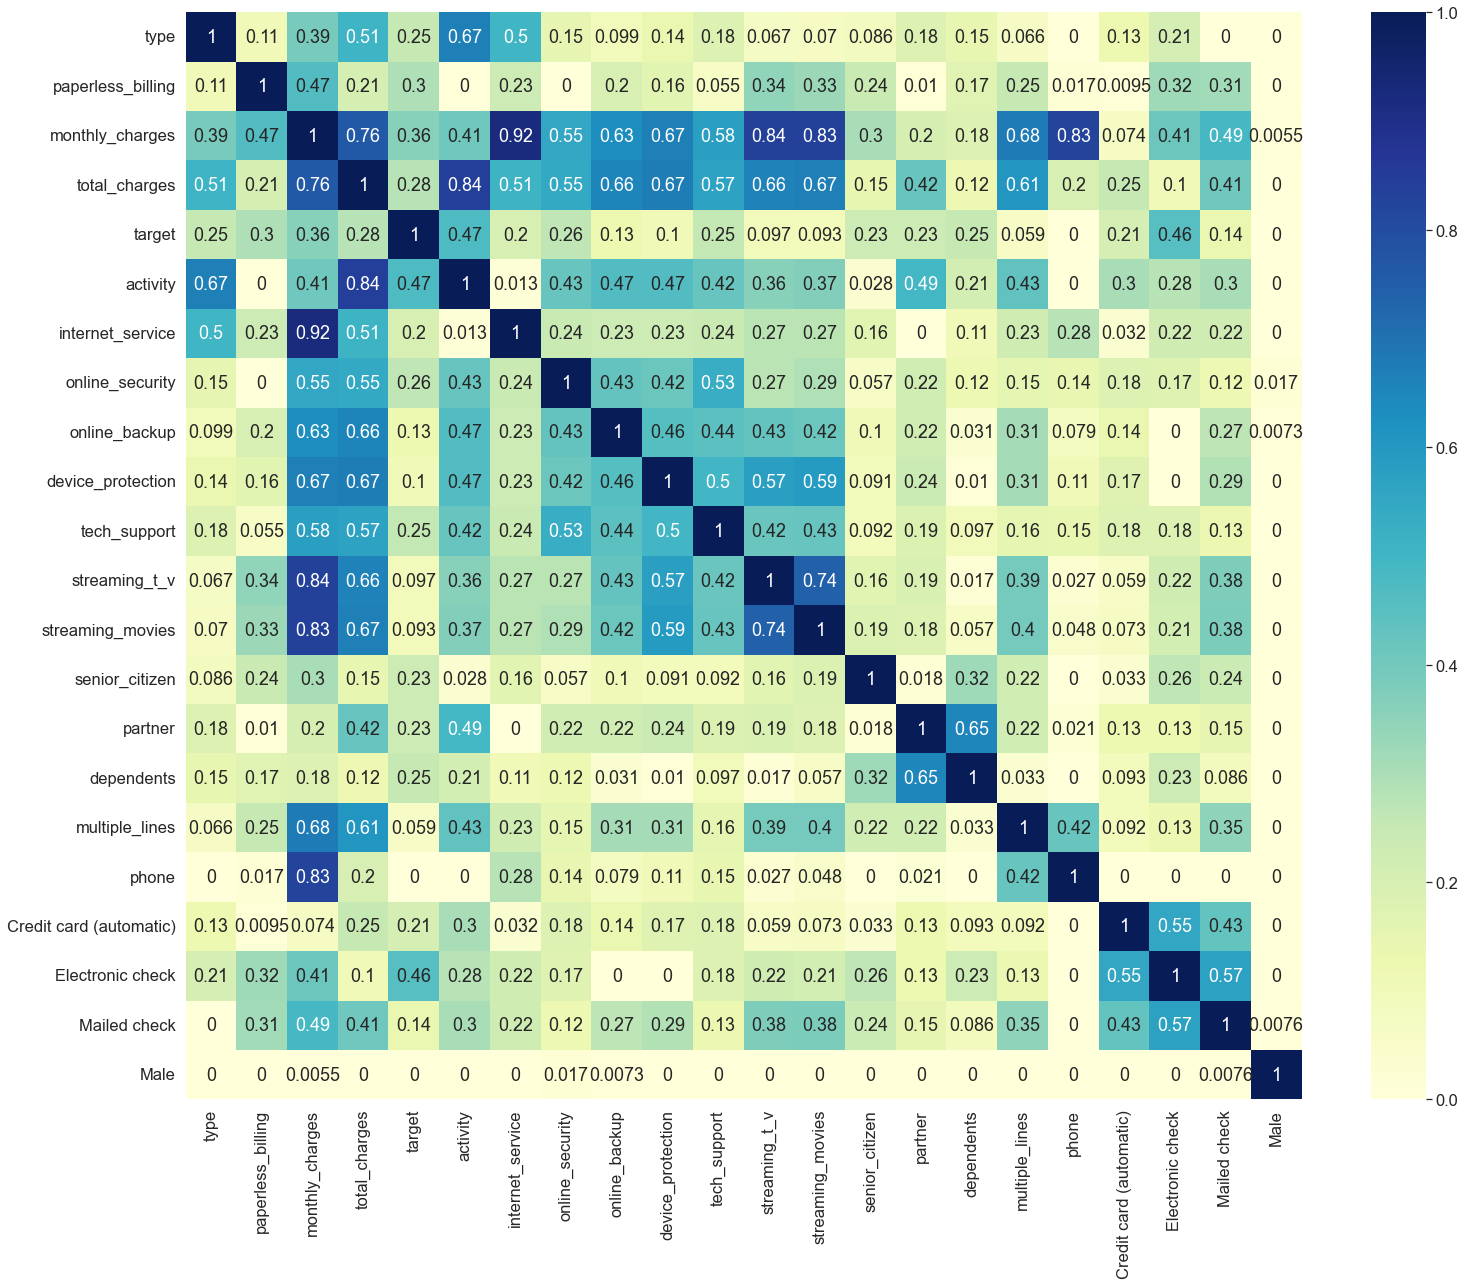

In [37]:
heatmap(work_df)

Итак, на данном этапе нас интересуют все фичи, кроме:
- Male - не коррелируют ни с одним другим признаком; взглянем поближе на их распределение от таргета
- multiple_lines и phone - очень слабая корреляция с таргетом;
- online_backup, device_protection, multiple_lines, streaming_tv и streaming_movies - сильно коррелируют с ежемесячной оплатой (не удивительно) и при этом низкая корреляция с таргетом; попробуем сложить их вместе и посмотрим на результат

### Разбираемся c gender и доп. сервисами

Text(0, 0.5, 'Кол-во объектов')

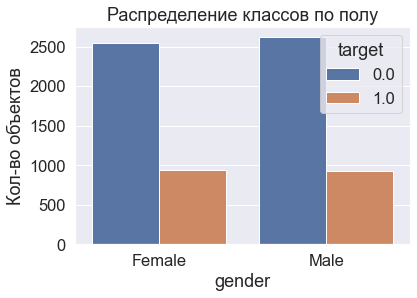

In [38]:
sns.countplot(df.gender, hue=df.target)
plt.title('Распределение классов по полу')
plt.ylabel('Кол-во объектов')

In [39]:
df[['gender','target']].value_counts(normalize=True)

gender  target
Male    0.0       0.372440
Female  0.0       0.361775
        1.0       0.133532
Male    1.0       0.132253
dtype: float64

Как мы видим, наша выборка очень сбалансирована по полу, как в абсолютном, так и в относительном размере касательно целевого класса - этот признак нам ничего не даст, можем убирать

In [40]:
work_df = work_df.drop(columns=['Male','multiple_lines','phone'])
df = df.drop(columns=['gender','phone','multiple_lines'])

Займёмся дополнительными опциями

In [41]:
work_df['add_services'] = work_df[['online_backup','device_protection',
                                   'streaming_t_v','streaming_movies','online_security','tech_support']].sum(axis=1)

work_df['streaming'] = work_df[['streaming_t_v','streaming_movies']].sum(axis=1)
work_df['streaming2'] = work_df.streaming_t_v * work_df.streaming_movies
work_df

type  paperless_billing  monthly_charges  total_charges  target  \
0        1                  1            29.85      29.850000     0.0   
1       12                  0            56.95    1889.500000     0.0   
2        1                  1            53.85     108.150002     1.0   
3       12                  0            42.30    1840.750000     0.0   
4        1                  1            70.70     151.649994     1.0   
...    ...                ...              ...            ...     ...   
7027    12                  1            84.80    1990.500000     0.0   
7028    12                  1           103.20    7362.899902     0.0   
7029     1                  1            29.60     346.450012     0.0   
7030     1                  1            74.40     306.600006     1.0   
7031    24                  1           105.65    6844.500000     0.0   

      activity  internet_service  online_security  online_backup  \
0           31                 1              0.0            1.0   
1         1036                 1              1.0            0.0   
2           61                 1              1.0            1.0   
3         1371                 1              1.0            0.0   
4           61                 2              0.0            0.0   
...        ...               ...              ...            ...   
7027       730                 1              1.0            0.0   
7028      2191                 2              0.0            1.0   
7029       337                 1              1.0            0.0   
7030       123                 2              0.0            0.0   
7031      2010                 2              1.0            0.0   

      device_protection  ...  streaming_movies  senior_citizen  partner  \
0                   0.0  ...               0.0               0        1   
1                   1.0  ...               0.0               0        0   
2                   0.0  ...               0.0               0        0   
3                   1.0  ...               0.0               0        0   
4                   0.0  ...               0.0               0        0   
...                 ...  ...               ...             ...      ...   
7027                1.0  ...               1.0               0        1   
7028                1.0  ...               1.0               0        1   
7029                0.0  ...               0.0               0        1   
7030                0.0  ...               0.0               1        1   
7031                1.0  ...               1.0               0        0   

      dependents  Credit card (automatic)  Electronic check  Mailed check  \
0              0                      0.0               1.0           0.0   
1              0                      0.0               0.0           1.0   
2              0                      0.0               0.0           1.0   
3              0                      0.0               0.0           0.0   
4              0                      0.0               1.0           0.0   
...          ...                      ...               ...           ...   
7027           1                      0.0               0.0           1.0   
7028           1                      1.0               0.0           0.0   
7029           1                      0.0               1.0           0.0   
7030           0                      0.0               0.0           1.0   
7031           0                      0.0               0.0           0.0   

      add_services  streaming  streaming2  
0              1.0        0.0         0.0  
1              2.0        0.0         0.0  
2              2.0        0.0         0.0  
3              3.0        0.0         0.0  
4              0.0        0.0         0.0  
...            ...        ...         ...  
7027           5.0        2.0         1.0  
7028           4.0        2.0         1.0  
7029           1.0        0.0         0.0  
7030           0.0        0.0         0.0  
70

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'add_services', 'streaming', 'streaming2']


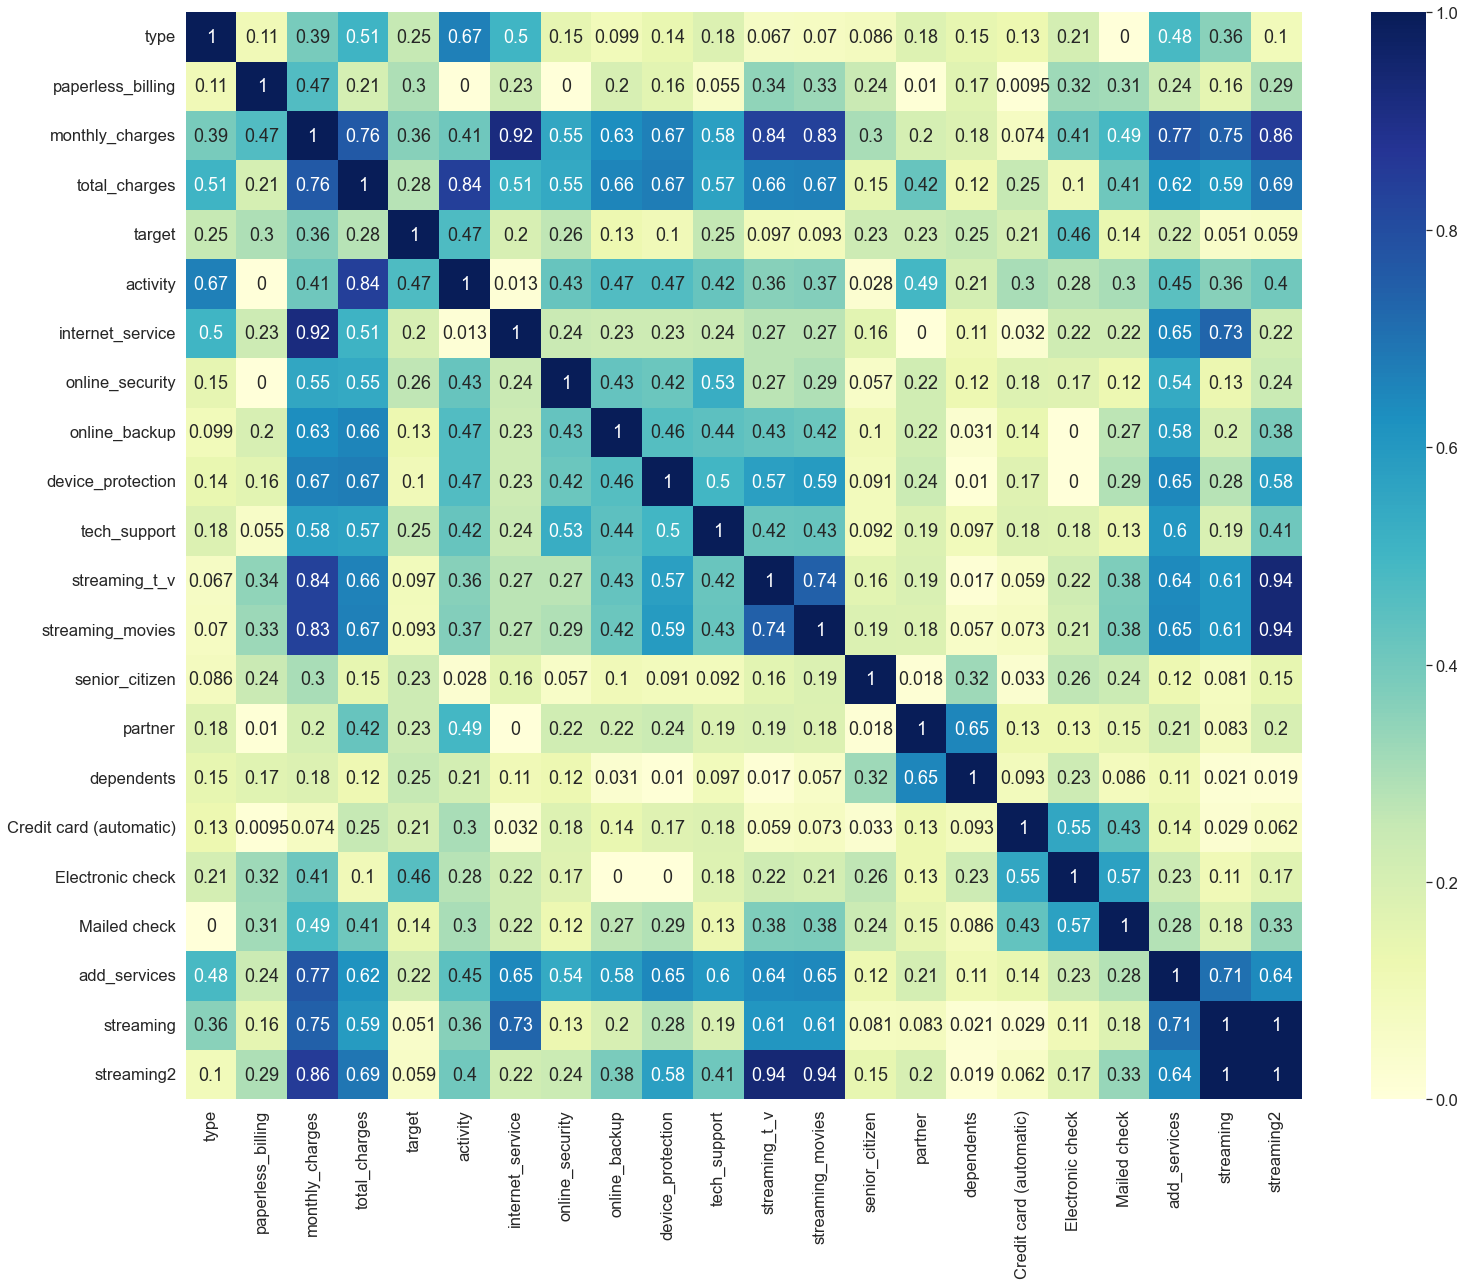

In [42]:
heatmap(work_df)

Итак, мы видим несколько коллинеарных признаков (сюда включаем те, что имеют коэффициент больше 0.8):
- __total_charges__ коррелирует с __monthly_charges и activity__ - будем с ней прощаться;
- стриминг ТВ и фильмов коррелирует с ежемесячной оплатой - при этом никакого вклада в таргет обе фичи ни вместе, ни по отдельности не дают; в связи с этим мы их уберем - а фичу по доп услугам пересоберем;
- __internet_service__ и __monthly_charges__ стали практически коллинеарны - с точки зрения корреляции важнее __monthly_charges__, её оставим, __internet_service__ - уберём
- __partner__ и __dependents__ достаточно сильно коррелируют друг с другом - не удивительно; попробуем переделать эту фичу в __family__ - единый признак и посмотрим итоговую корреляцию

Попробуем также добавить фичу по тратам в день - посмотрим, может она больше коррелирует с таргетом, чем ежемесячные траты

Итак, фронт работ:
- уберём стриминги, пересчитаем фичу по доп услугам;
- объединим __partner__ и __dependents__ в одну фичу;
- уберём __total_charges__ и __internet_service__
- добавим __daily_charge__

### Убираем коллинеарные признаки и формируем новые фичи по семейным признакам

1. __Стриминги__, коллинеарные признаки и новая фича __daily_charge__

In [43]:
work_df['daily_charge'] = work_df.total_charges / work_df.activity




work_df = work_df.drop(columns=['streaming','streaming2','streaming_t_v',
                                'streaming_movies','total_charges','internet_service'])

work_df.add_services = work_df[['online_backup','device_protection',
                                   'online_security','tech_support']].sum(axis=1)
work_df['add_services2'] = work_df.online_backup * work_df.device_protection * \
                            work_df.online_security * work_df.tech_support

2. Займемся "семейной" фичей - и в целом посмотрим, насколько эти признаки коррелируют с таргетом:

<AxesSubplot:xlabel='partner', ylabel='count'>

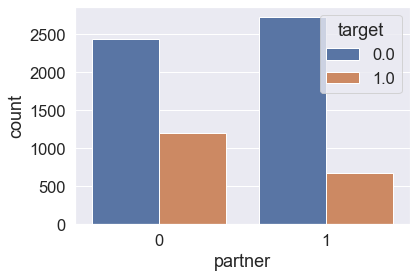

In [44]:
sns.countplot(work_df.partner, hue=work_df.target)

In [45]:
pd.DataFrame(work_df[['partner','target']].value_counts(normalize=True)).sort_values(by='partner')

0
partner target          
0       0.0     0.346843
        1.0     0.170648
1       0.0     0.387372
        1.0     0.095137

Как мы видим, распределение объектов по признаку "с партнером" - "без партнера" примерно равное, однако можно заметить следующее: 1 из 3 клиентов без партнера расторг контракт, в то время как среди клиентов с партнерами - расторглись в среднем 1 из 4. Это важная фича

<AxesSubplot:xlabel='dependents', ylabel='count'>

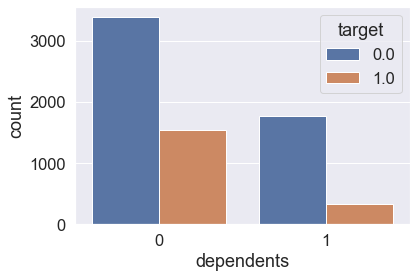

In [46]:
sns.countplot(work_df.dependents, hue=work_df.target)

In [47]:
pd.DataFrame(work_df[['dependents','target']].value_counts(normalize=True)).sort_values(by='dependents')

0
dependents target          
0          0.0     0.482082
           1.0     0.219425
1          0.0     0.252133
           1.0     0.046359

В случае с признаком о наличии иждивенцев мы видим неравномерное распределение выборки - у 70% клиентов иждивенцев нет. Более того, распределение по таргету также неравномерно: из людей без иждивенцев расторгают контракты ~ в 2 из 5 случаев, в то время как в обратном случае - 1 из 5.

Посмотрим же и на взаимосвязь этих признаков:

<AxesSubplot:xlabel='partner', ylabel='count'>

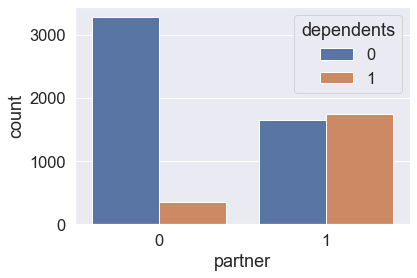

In [48]:
sns.countplot(work_df.partner, hue=work_df.dependents)

In [49]:
pd.DataFrame(work_df[['partner','dependents']].value_counts(normalize=True)).sort_values(by='partner')

0
partner dependents          
0       0           0.466439
        1           0.051052
1       1           0.247440
        0           0.235068

Что мы можем здесь заключить? Нам нужно как-то усилить отсутствие иждивенцев и партнёров. Что если мы из признакового пространства $[0;1]$ перекодируемся в $[-1;1]$?

In [50]:
work_df['partner2'] = work_df.partner *2 - 1
work_df['dependents2'] = work_df.dependents * 2 - 1

In [51]:
work_df[['partner2','partner','dependents2','dependents','target']].phik_matrix()

interval columns not set, guessing: ['partner2', 'partner', 'dependents2', 'dependents', 'target']


partner2   partner  dependents2  dependents    target
partner2     1.000000  1.000000     0.651635    0.651635  0.232215
partner      1.000000  1.000000     0.651635    0.651635  0.232215
dependents2  0.651635  0.651635     1.000000    1.000000  0.252268
dependents   0.651635  0.651635     1.000000    1.000000  0.252268
target       0.232215  0.232215     0.252268    0.252268  1.000000

Ничего не произошло (видимо, коэффициент корреляции уже обнаружил взаимосвязи). А если мы умножим их друг на друга?

In [52]:
work_df['family'] = work_df.partner * work_df.dependents
work_df['family2'] = work_df.partner2 * work_df.dependents2
work_df[['partner2','partner','dependents2','dependents','target','family','family2']].phik_matrix()

interval columns not set, guessing: ['partner2', 'partner', 'dependents2', 'dependents', 'target', 'family', 'family2']


partner2   partner  dependents2  dependents    target    family  \
partner2     1.000000  1.000000     0.651635    0.651635  0.232215  0.802905   
partner      1.000000  1.000000     0.651635    0.651635  0.232215  0.802905   
dependents2  0.651635  0.651635     1.000000    1.000000  0.252268  0.981894   
dependents   0.651635  0.651635     1.000000    1.000000  0.252268  0.981894   
target       0.232215  0.232215     0.252268    0.252268  1.000000  0.246310   
family       0.802905  0.802905     0.981894    0.981894  0.246310  1.000000   
family2      0.624168  0.624168     0.256814    0.256814  0.037237  0.539117   

              family2  
partner2     0.624168  
partner      0.624168  
dependents2  0.256814  
dependents   0.256814  
target       0.037237  
family       0.539117  
family2      1.000000

У нас ничего не получилось( Однако же мы попробуем хитрость - попробуем предсказать таргет по имеющимся __partner и dependents__ с помощью регресси, а затем оттуда вытянем коэффициенты и домножим их на наши значения:

In [53]:
fam_model = LogisticRegression(max_iter=10000)
fam_model.fit(work_df[['dependents','partner']],work_df['target'])
roc_auc_score(work_df['target'],fam_model.predict_proba(work_df[['dependents','partner']])[:,1])

0.6116054815269409

In [54]:
fam_model.coef_

array([[-0.68939099, -0.43567959]])

In [55]:
work_df['family3'] = work_df.dependents * fam_model.coef_[0][0] + work_df.partner * fam_model.coef_[0][1] + fam_model.intercept_

In [56]:
work_df['family4'] = work_df.dependents * work_df.partner

In [57]:
work_df[['partner2','partner','dependents2','dependents','target','family','family2','family3','family4']].phik_matrix()

interval columns not set, guessing: ['partner2', 'partner', 'dependents2', 'dependents', 'target', 'family', 'family2', 'family3', 'family4']


partner2   partner  dependents2  dependents    target    family  \
partner2     1.000000  1.000000     0.651635    0.651635  0.232215  0.802905   
partner      1.000000  1.000000     0.651635    0.651635  0.232215  0.802905   
dependents2  0.651635  0.651635     1.000000    1.000000  0.252268  0.981894   
dependents   0.651635  0.651635     1.000000    1.000000  0.252268  0.981894   
target       0.232215  0.232215     0.252268    0.252268  1.000000  0.246310   
family       0.802905  0.802905     0.981894    0.981894  0.246310  1.000000   
family2      0.624168  0.624168     0.256814    0.256814  0.037237  0.539117   
family3      1.000000  1.000000     1.000000    1.000000  0.275268  1.000000   
family4      0.802905  0.802905     0.981894    0.981894  0.246310  1.000000   

              family2   family3   family4  
partner2     0.624168  1.000000  0.802905  
partner      0.624168  1.000000  0.802905  
dependents2  0.256814  1.000000  0.981894  
dependents   0.256814  1.000000  0.981894  
target       0.037237  0.275268  0.246310  
family       0.539117  1.000000  1.000000  
family2      1.000000  1.000000  0.539117  
family3      1.000000  1.000000  1.000000  
family4      0.539117  1.000000  1.000000

И мы получаем более коррелирующую фичу! Уберём все лишние, кроме первоначальных и итоговой

In [58]:
work_df = work_df.drop(columns=['partner2','dependents2','family','family2','family4'])
work_df

type  paperless_billing  monthly_charges  target  activity  \
0        1                  1            29.85     0.0        31   
1       12                  0            56.95     0.0      1036   
2        1                  1            53.85     1.0        61   
3       12                  0            42.30     0.0      1371   
4        1                  1            70.70     1.0        61   
...    ...                ...              ...     ...       ...   
7027    12                  1            84.80     0.0       730   
7028    12                  1           103.20     0.0      2191   
7029     1                  1            29.60     0.0       337   
7030     1                  1            74.40     1.0       123   
7031    24                  1           105.65     0.0      2010   

      online_security  online_backup  device_protection  tech_support  \
0                 0.0            1.0                0.0           0.0   
1                 1.0            0.0                1.0           0.0   
2                 1.0            1.0                0.0           0.0   
3                 1.0            0.0                1.0           1.0   
4                 0.0            0.0                0.0           0.0   
...               ...            ...                ...           ...   
7027              1.0            0.0                1.0           1.0   
7028              0.0            1.0                1.0           0.0   
7029              1.0            0.0                0.0           0.0   
7030              0.0            0.0                0.0           0.0   
7031              1.0            0.0                1.0           1.0   

      senior_citizen  partner  dependents  Credit card (automatic)  \
0                  0        1           0                      0.0   
1                  0        0           0                      0.0   
2                  0        0           0                      0.0   
3                  0        0           0                      0.0   
4                  0        0           0                      0.0   
...              ...      ...         ...                      ...   
7027               0        1           1                      0.0   
7028               0        1           1                      1.0   
7029               0        1           1                      0.0   
7030               1        1           0                      0.0   
7031               0        0           0                      0.0   

      Electronic check  Mailed check  add_services  daily_charge  \
0                  1.0           0.0           1.0      0.962903   
1                  0.0           1.0           2.0      1.823842   
2                  0.0           1.0           2.0      1.772951   
3                  0.0           0.0           3.0      1.342633   
4                  1.0           0.0           0.0      2.486065   
...                ...           ...           ...           ...   
7027               0.0           1.0           3.0      2.726712   
7028               0.0           0.0           2.0      3.360520   
7029               1.0           0.0           1.0      1.028042   
7030               0.0           1.0           0.0      2.492683   
7031               0.0           0.0           3.0      3.405224   

      add_services2   family3  
0               0.0 -1.085648  
1               0.0 -0.649969  
2               0.0 -0.649969  
3               0.0 -0.649969  
4               0.0 -0.649969  
...             ...       ...  
7027            0.0 -1.775039  
7028            0.0 -1.775039  
7029            0.0 -1.775039  
7030            0.0 -1.085648  
7031            0.0 -0.649969  

[7032 rows x 19 columns]

Посмотрим еще раз на матрицу корреляции:

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'senior_citizen', 'partner', 'dependents', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'add_services', 'daily_charge', 'add_services2', 'family3']


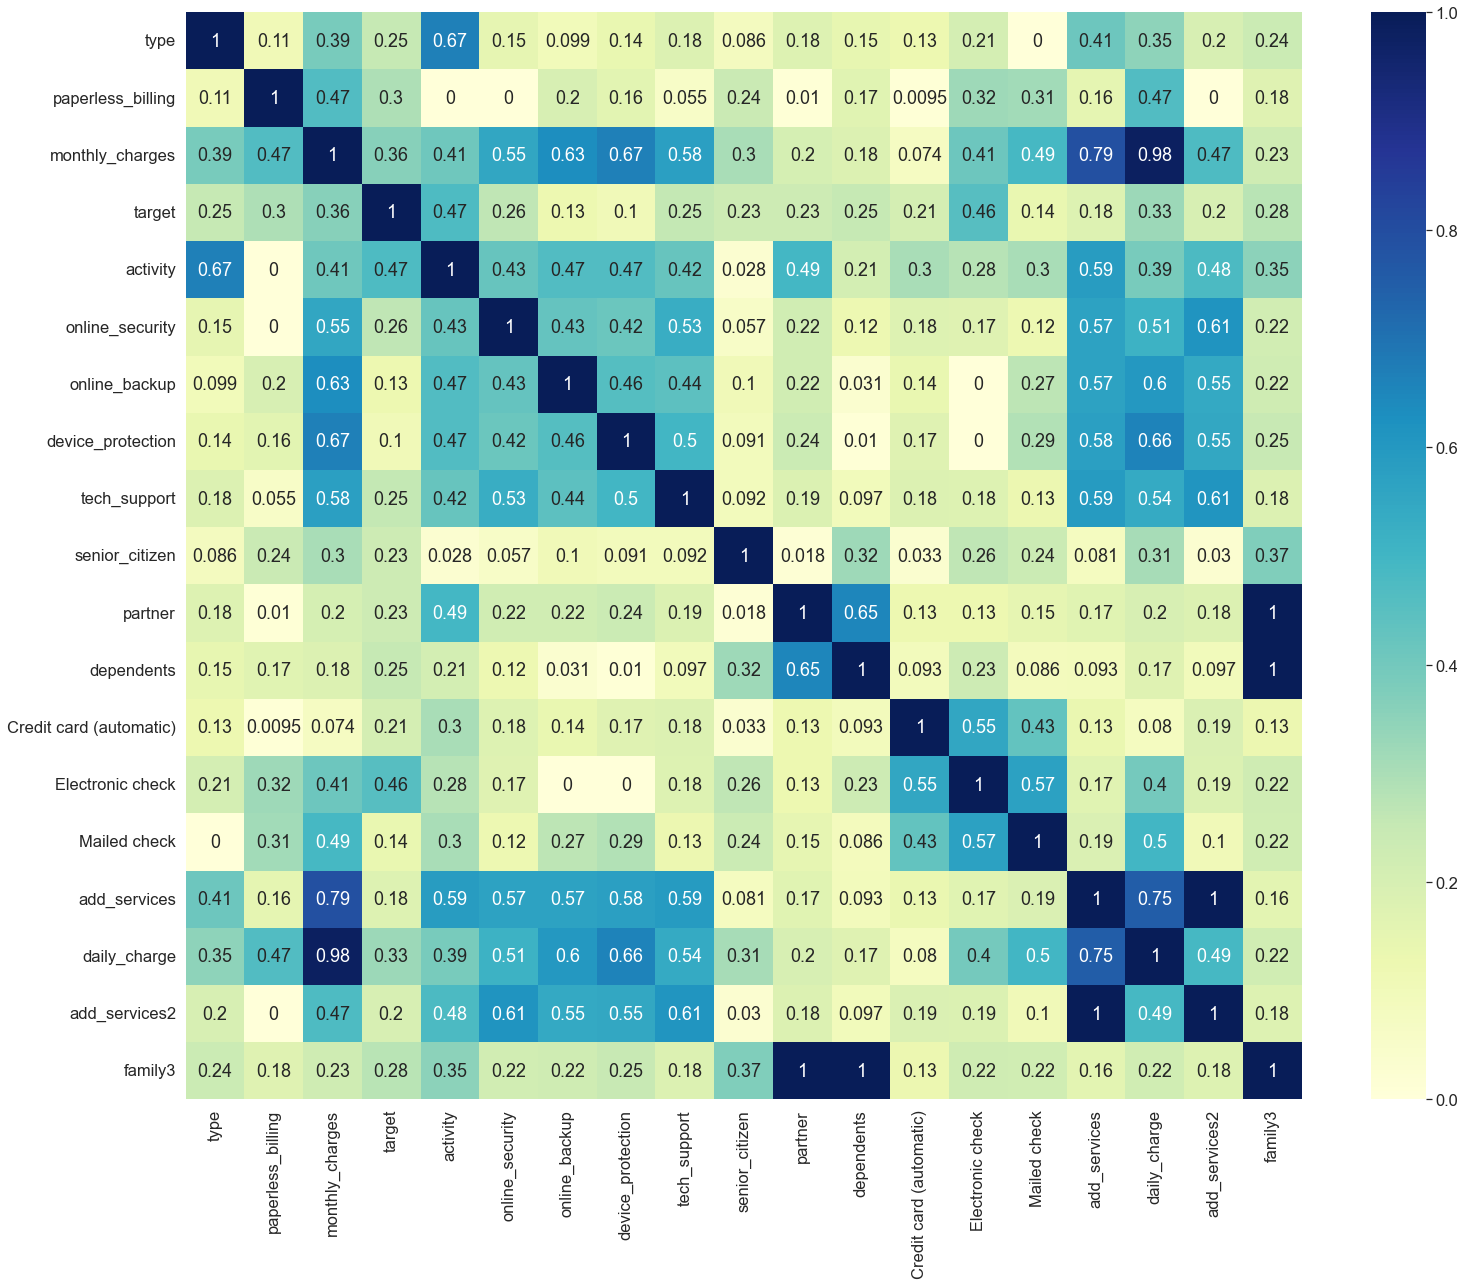

In [59]:
heatmap(work_df)

Что мы видим:
- __daily_charge__ не демонстрирует преимуществ перед __monthly_charge__ - однако пока что мы её оставим (попробуем еще несколько преобразований)
- произведение дополнительных услуг работает лучше, чем сумма - коллинеарность с __monthly_charges__ гораздо меньше, а корреляция с таргетом - чуть выше; попробуем копнуть в эту сторону;


### Продолжаем работать с дополнительными услугами

1. Начнем с __add_services__:

In [60]:
work_df = work_df.drop(columns='add_services')

interval columns not set, guessing: ['target', 'add_services2', 'add_services3', 'add_services4', 'add_services5', 'add_services6', 'online_security', 'online_backup', 'device_protection', 'tech_support']


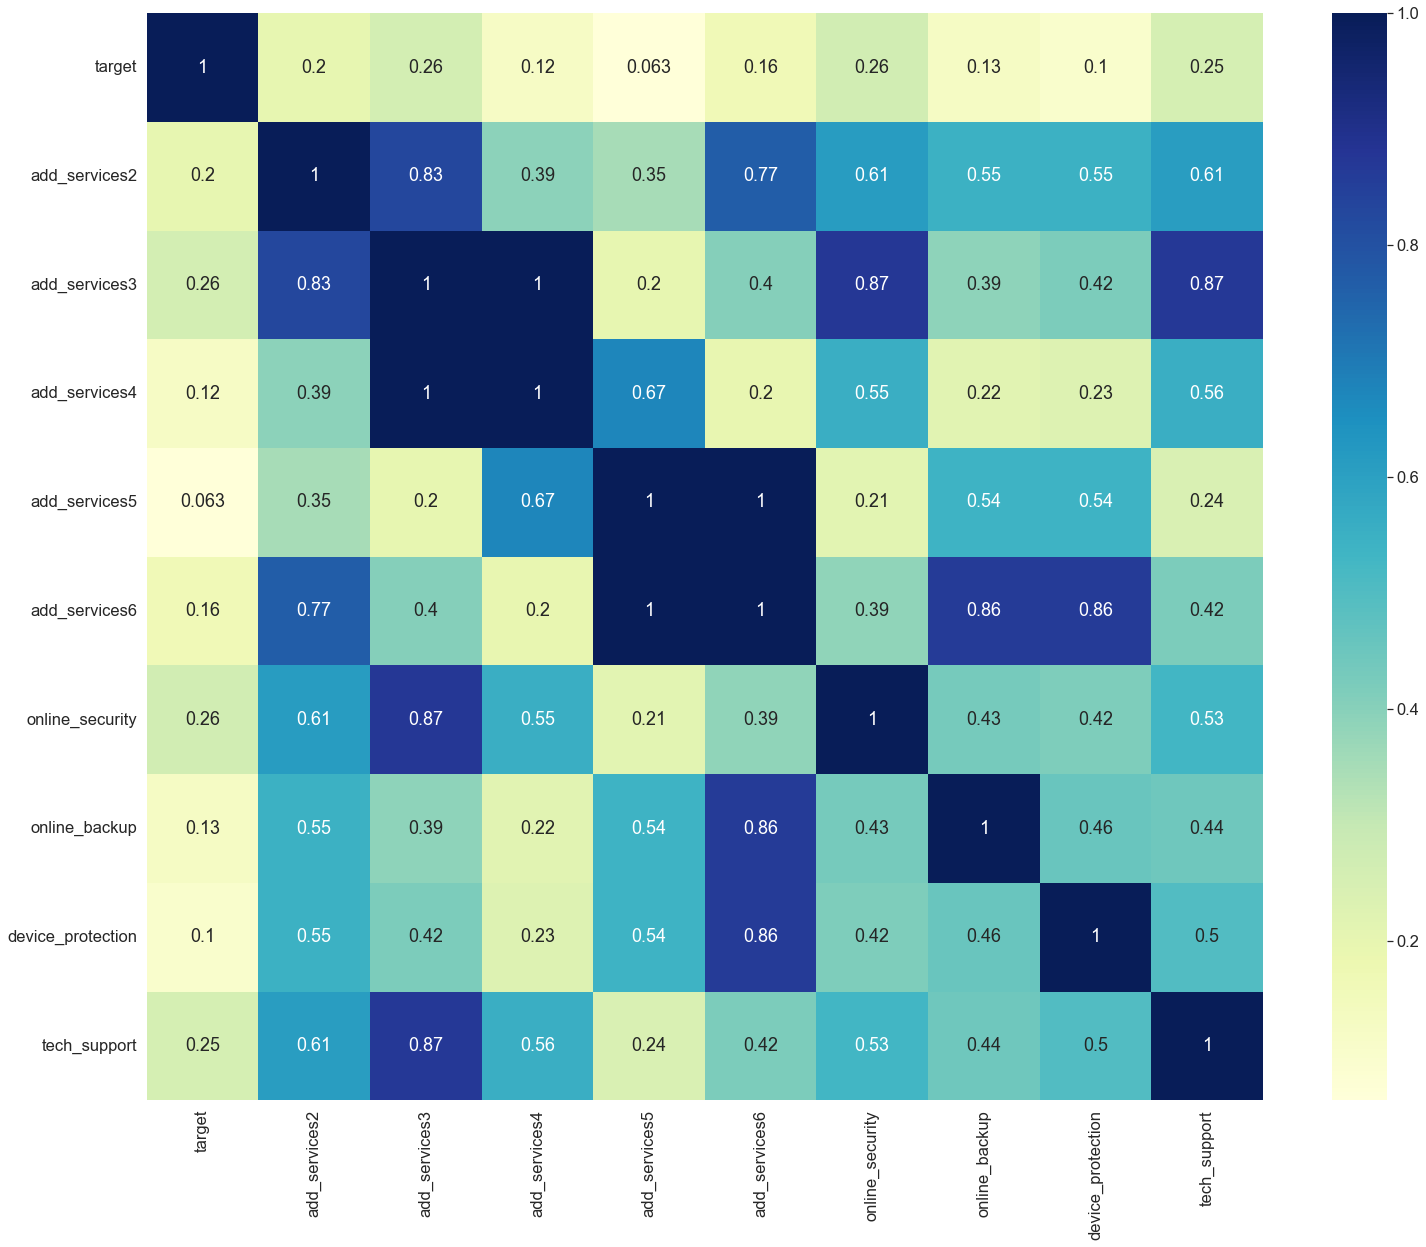

In [61]:
work_df['add_services3'] = work_df.tech_support * work_df.online_security
work_df['add_services4'] = work_df.tech_support + work_df.online_security
work_df['add_services5'] = work_df.online_backup + work_df.device_protection
work_df['add_services6'] = work_df.online_backup * work_df.device_protection
heatmap(work_df[['target','add_services2','add_services3', 'add_services4','add_services5','add_services6','online_security', 
         'online_backup', 'device_protection', 'tech_support']])

Мы видим некоторое улучшение, если возьмем произведение 2 малокоррелирующих признаков и 2 сильно коррелирующих признаков; оставим их и взглянем на матрицу целиком:

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'senior_citizen', 'partner', 'dependents', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'daily_charge', 'add_services2', 'family3', 'add_services3', 'add_services6']


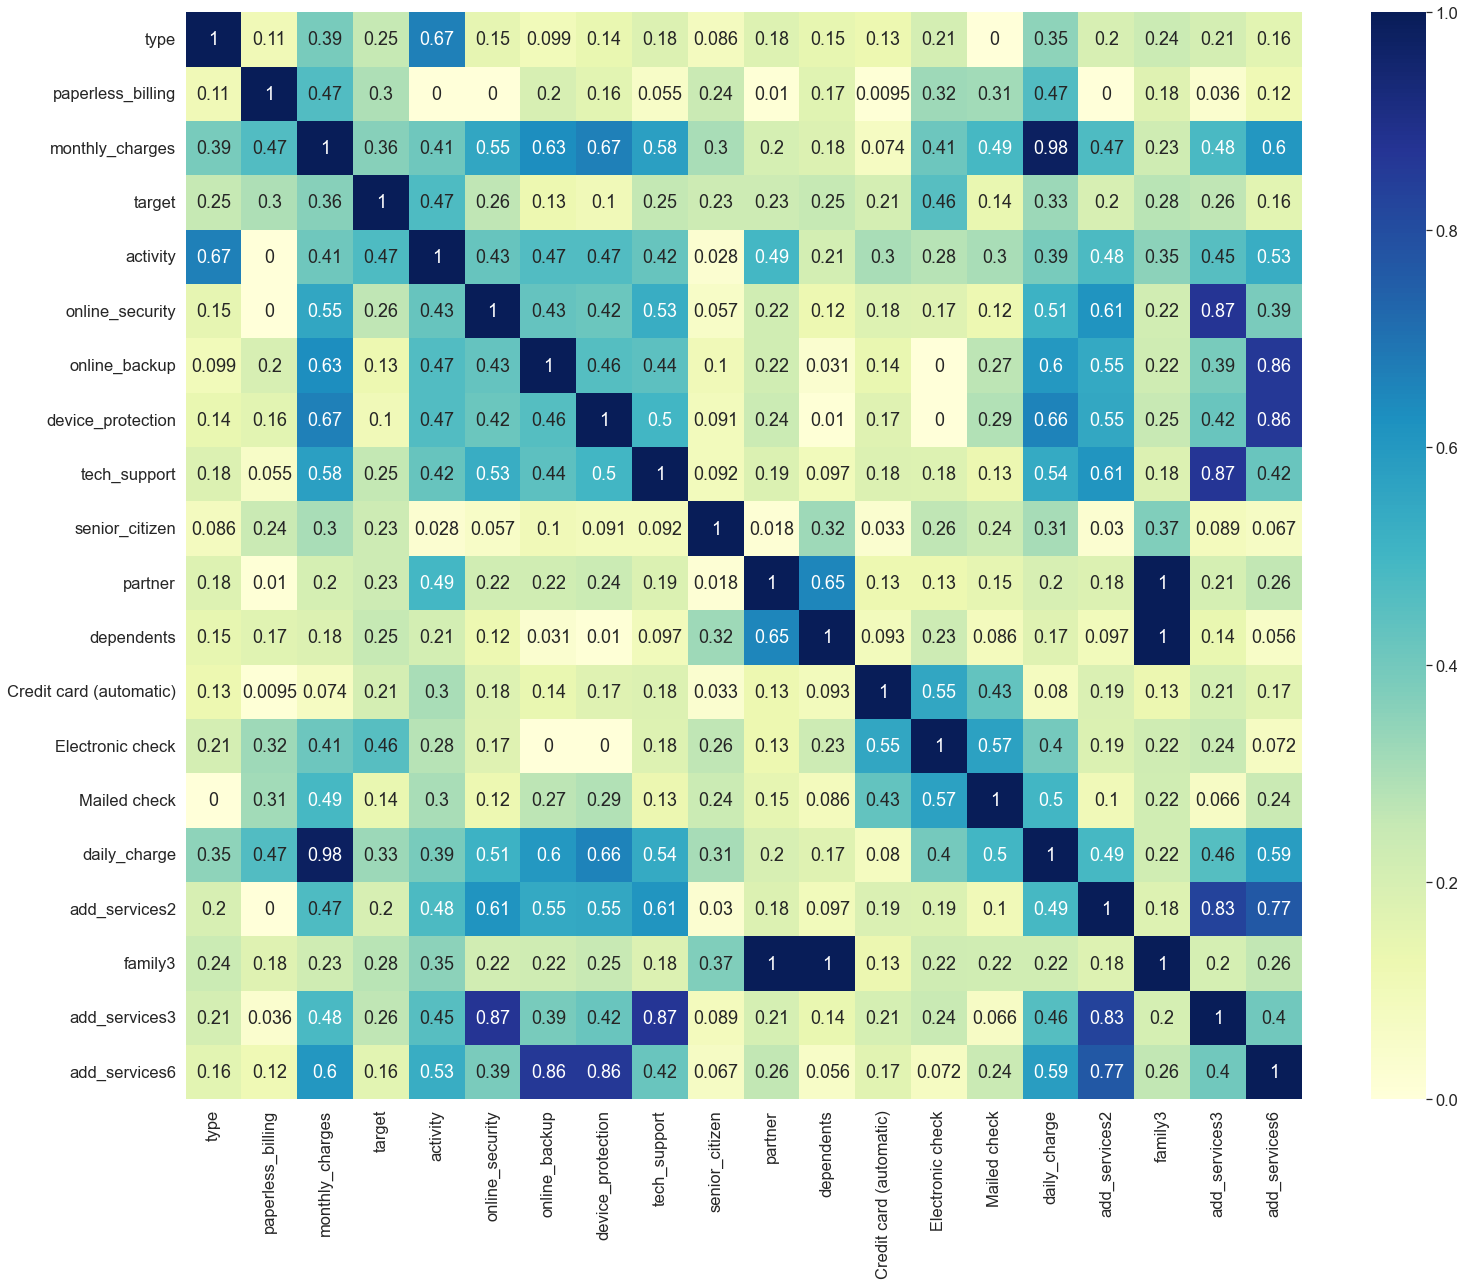

In [62]:
work_df = work_df.drop(columns=[ 'add_services4', 'add_services5'])
heatmap(work_df)

Выбросим фичу __add_services2__.

In [63]:
work_df['security_plus_support'] = work_df.add_services3
work_df['backup_plus_protection'] = work_df.add_services6
work_df['family'] = work_df.family3


 Уберем __partner и dependents, online_backup и device_protection__, а также __security_plus_support__ - всё же она сильно коррелирует с другими фичами, а с таргетом корреляция на том же уровне

In [64]:
work_df = work_df.drop(columns=['security_plus_support','partner',
                                'dependents','online_backup','device_protection','add_services2',
                                'add_services3','add_services6','family3'])

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'tech_support', 'senior_citizen', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'daily_charge', 'backup_plus_protection', 'family']


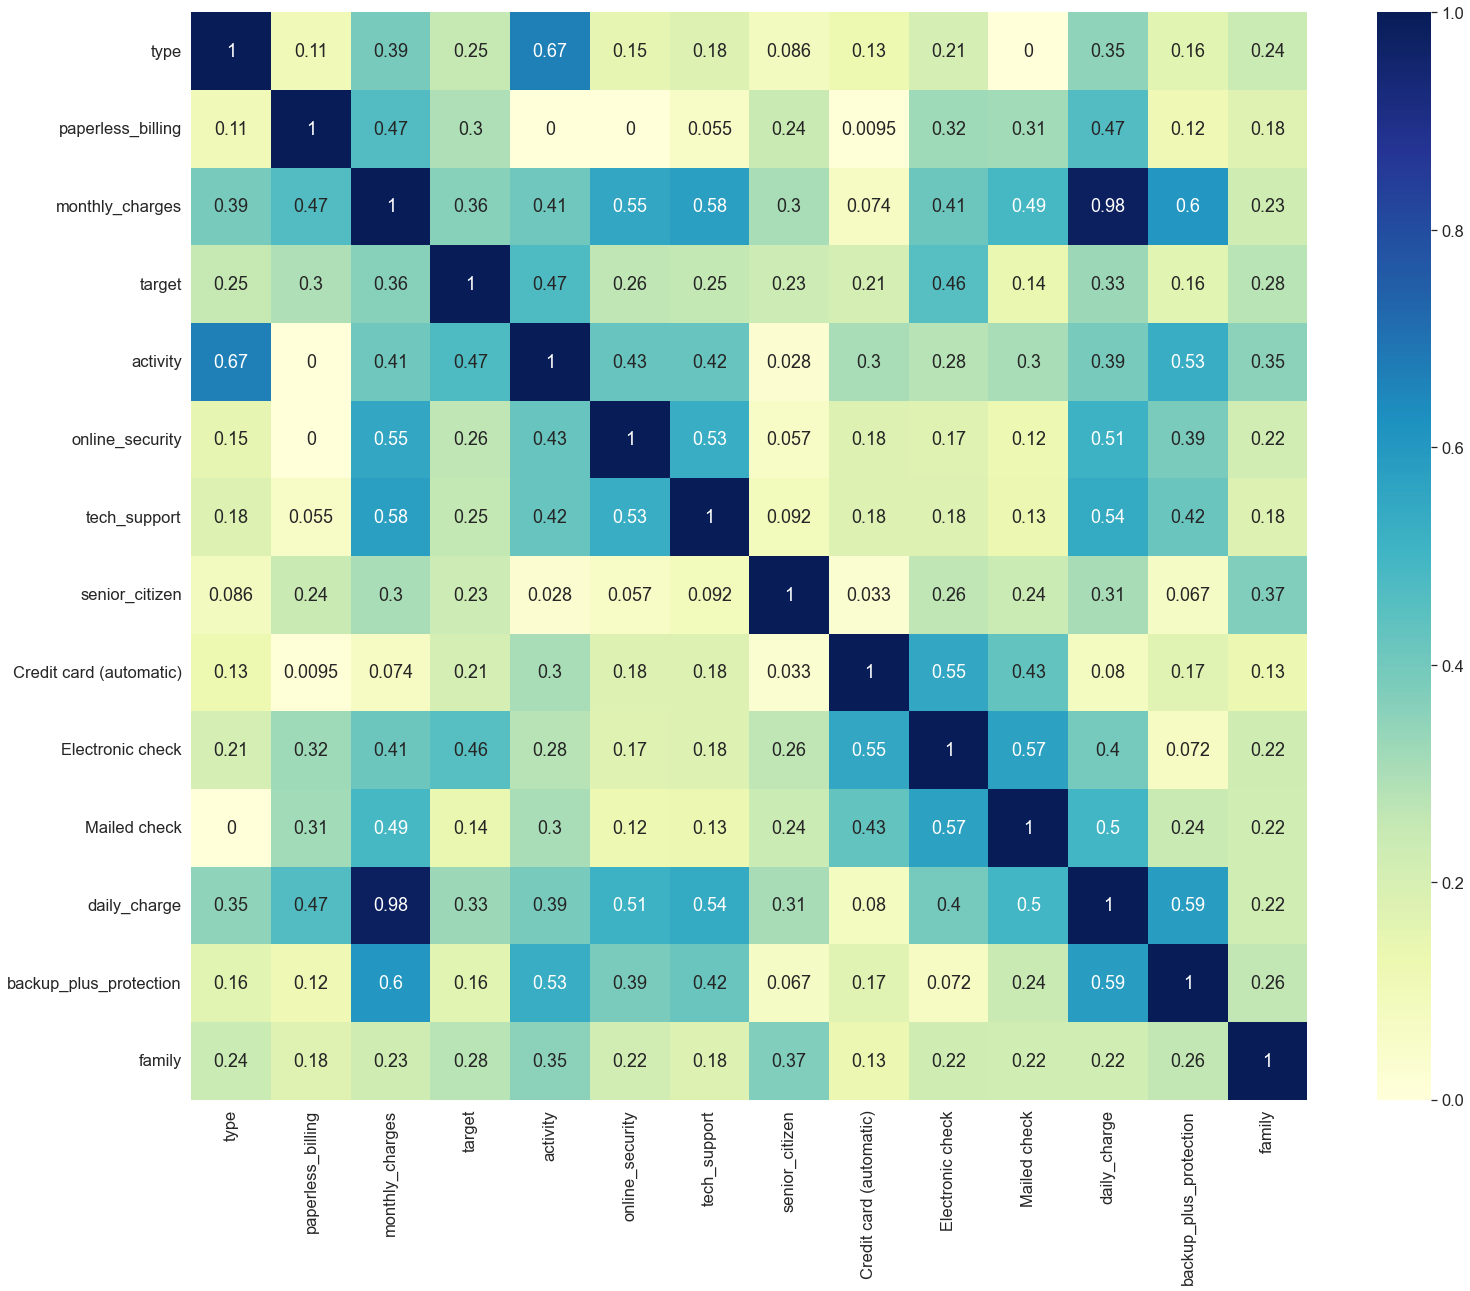

In [65]:
heatmap(work_df)

### Математика - возводим в степени и логарифмируем

Следущее, что мы попробуем - это возведение в степени и логарифмирование

In [66]:
corr_df = work_df.copy(deep=True)

In [67]:
corr_df.describe()

type  paperless_billing  monthly_charges       target  \
count  7032.000000        7032.000000      7032.000000  7032.000000   
mean      8.813851           0.592719        64.798208     0.265785   
std       9.541690           0.491363        30.085974     0.441782   
min       1.000000           0.000000        18.250000     0.000000   
25%       1.000000           0.000000        35.587500     0.000000   
50%       1.000000           1.000000        70.350000     0.000000   
75%      12.000000           1.000000        89.862500     1.000000   
max      24.000000           1.000000       118.750000     1.000000   

          activity  online_security  tech_support  senior_citizen  \
count  7032.000000      7032.000000   7032.000000     7032.000000   
mean    987.538538         0.286547      0.290102        0.162400   
std     747.153663         0.452180      0.453842        0.368844   
min      30.000000         0.000000      0.000000        0.000000   
25%     275.000000         0.000000      0.000000        0.000000   
50%     883.000000         0.000000      0.000000        0.000000   
75%    1676.000000         1.000000      1.000000        0.000000   
max    2191.000000         1.000000      1.000000        1.000000   

       Credit card (automatic)  Electronic check  Mailed check  daily_charge  \
count              7032.000000       7032.000000   7032.000000   7032.000000   
mean                  0.216297          0.336320      0.228100      2.124791   
std                   0.411748          0.472483      0.419637      0.991608   
min                   0.000000          0.000000      0.000000      0.444355   
25%                   0.000000          0.000000      0.000000      1.184245   
50%                   0.000000          0.000000      0.000000      2.306942   
75%                   0.000000          1.000000      0.000000      2.955156   
max                   1.000000          1.000000      1.000000      3.980328   

       backup_plus_protection       family  
count             7032.000000  7032.000000  
mean                 0.187002    -1.065966  
std                  0.389941     0.457236  
min                  0.000000    -1.775039  
25%                  0.000000    -1.339360  
50%                  0.000000    -1.085648  
75%                  0.000000    -0.649969  
max                  1.000000    -0.649969

In [68]:
pows = np.linspace(.25,4,16).tolist()
pows

[0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0]

In [69]:
df_num = corr_df.copy(deep=True)

correlations = df_num.phik_matrix()['target'].to_frame().T
for i in pows:
    ops = df_num.copy()
    ops = ops ** i
    correlations = pd.concat([correlations,ops.phik_matrix()['target'].to_frame().T])

df_num[['monthly_charges','type','activity','daily_charge']] = np.log(df_num[['monthly_charges','type','activity','daily_charge']])
correlations = pd.concat([correlations,df_num.phik_matrix()['target'].to_frame().T])    

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'tech_support', 'senior_citizen', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'daily_charge', 'backup_plus_protection', 'family']
interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'tech_support', 'senior_citizen', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'daily_charge', 'backup_plus_protection', 'family']
interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'tech_support', 'senior_citizen', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'daily_charge', 'backup_plus_protection', 'family']
interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'tech_support', 'senior_citizen', 'Credit card (a

In [70]:
correlations.index = ['normal'] + pows + ['log']
correlations

type  paperless_billing  monthly_charges  target  activity  \
normal  0.251283           0.295194         0.359623     1.0  0.473761   
0.25    0.251283           0.295194         0.328501     1.0  0.488955   
0.5     0.251283           0.295194         0.351714     1.0  0.487061   
0.75    0.251283           0.295194         0.337826     1.0  0.486097   
1.0     0.251283           0.295194         0.359623     1.0  0.473761   
1.25    0.251283           0.295194         0.329627     1.0  0.465292   
1.5     0.251283           0.295194         0.350361     1.0  0.409003   
1.75    0.251283           0.295194         0.324041     1.0  0.401772   
2.0     0.251283           0.295194         0.341912     1.0  0.398044   
2.25    0.251283           0.295194         0.309971     1.0  0.387264   
2.5     0.251283           0.295194         0.295047     1.0  0.376959   
2.75    0.251283           0.295194         0.309298     1.0  0.368877   
3.0     0.251283           0.295194         0.304315     1.0  0.366211   
3.25    0.251283           0.295194         0.285553     1.0  0.359844   
3.5     0.455334           0.295194         0.286596     1.0  0.356614   
3.75    0.455334           0.295194         0.297327     1.0  0.354524   
4.0     0.455334           0.295194         0.311280     1.0  0.350528   
log     0.251283           0.295194         0.341000     1.0  0.485918   

        online_security  tech_support  senior_citizen  \
normal         0.264645      0.254678        0.232897   
0.25           0.264645      0.254678        0.232897   
0.5            0.264645      0.254678        0.232897   
0.75           0.264645      0.254678        0.232897   
1.0            0.264645      0.254678        0.232897   
1.25           0.264645      0.254678        0.232897   
1.5            0.264645      0.254678        0.232897   
1.75           0.264645      0.254678        0.232897   
2.0            0.264645      0.254678        0.232897   
2.25           0.264645      0.254678        0.232897   
2.5            0.264645      0.254678        0.232897   
2.75           0.264645      0.254678        0.232897   
3.0            0.264645      0.254678        0.232897   
3.25           0.264645      0.254678        0.232897   
3.5            0.264645      0.254678        0.232897   
3.75           0.264645      0.254678        0.232897   
4.0            0.264645      0.254678        0.232897   
log            0.264645      0.254678        0.232897   

        Credit card (automatic)  Electronic check  Mailed check  daily_charge  \
normal                 0.208592          0.455248      0.140289      0.326281   
0.25                   0.208592          0.455248      0.140289      0.312135   
0.5                    0.208592          0.455248      0.140289      0.324438   
0.75                   0.208592          0.455248      0.140289      0.315808   
1.0                    0.208592          0.455248      0.140289      0.326281   
1.25                   0.208592          0.455248      0.140289      0.321502   
1.5                    0.208592          0.455248      0.140289      0.323764   
1.75                   0.208592          0.455248      0.140289      0.310672   
2.0                    0.208592          0.455248      0.140289      0.324741   
2.25                   0.208592          0.455248      0.140289      0.294032   
2.5                    0.208592          0.455248      0.140289      0.284254   
2.75                   0.208592          0.455248      0.140289      0.294619   
3.0                    0.208592          0.455248      0.140289      0.275160   
3.25                   0.208592          0.455248      0.140289      0.270971   
3.5                    0.208592          0.455248      0.140289      0.277267   
3.75                   0.208592          0.455248      0.140289      0.287184   
4.0                    0.208592          0.455248      0.140289      0.288962   
log                    0.208592          0.455248      0.140289

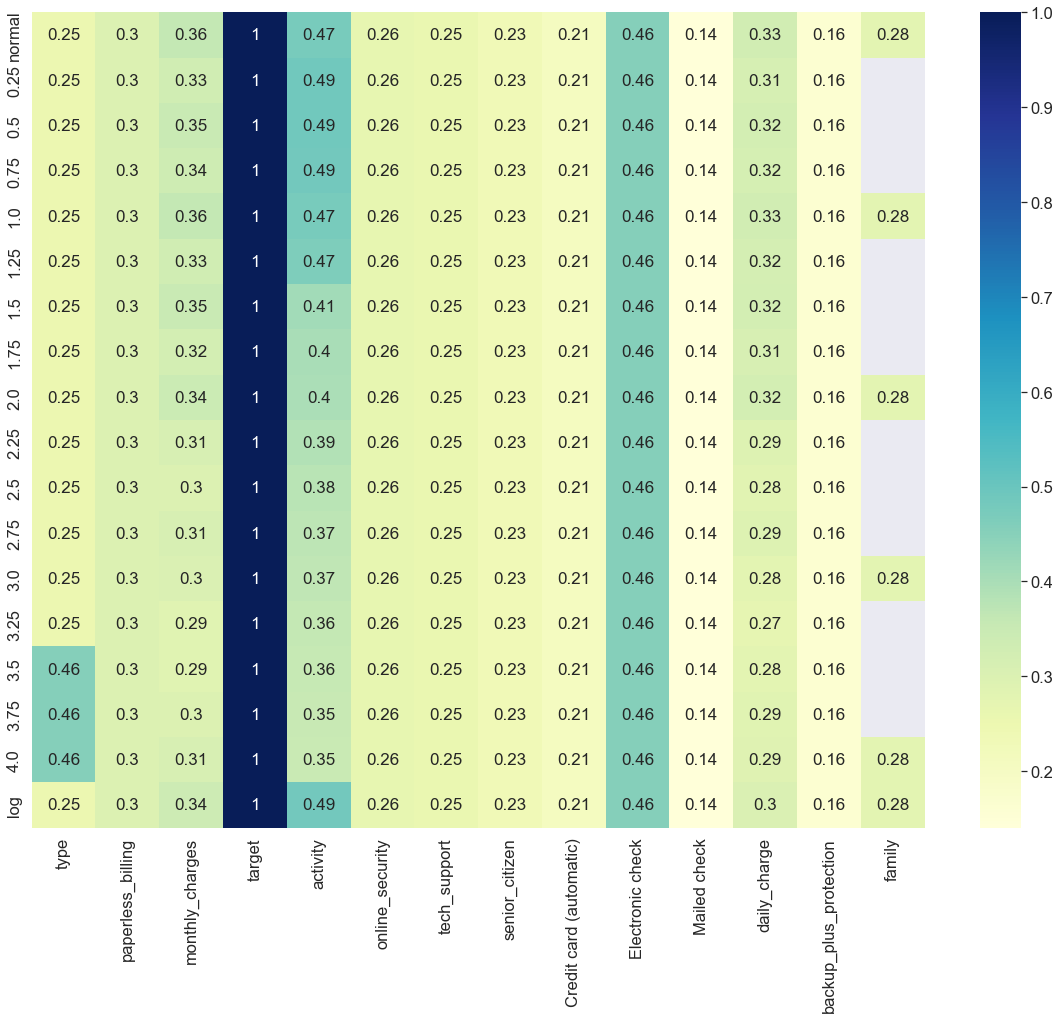

In [71]:
heatmap(correlations, corr=False)

Мы наблюдаем весьма интересную картину:
1. __type__ значительно увеличивает свою корреляцию с таргетом при возведении в степень 3.5;
2. __activity__ незначительно увеличивает корреляцию при возведении в степень 0.25

Внесём новые фичи и выбросим __daily_charge__ - она никак нам не помогла:

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'target', 'online_security', 'tech_support', 'senior_citizen', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'backup_plus_protection', 'family', 'type_3.5', 'activity_root']


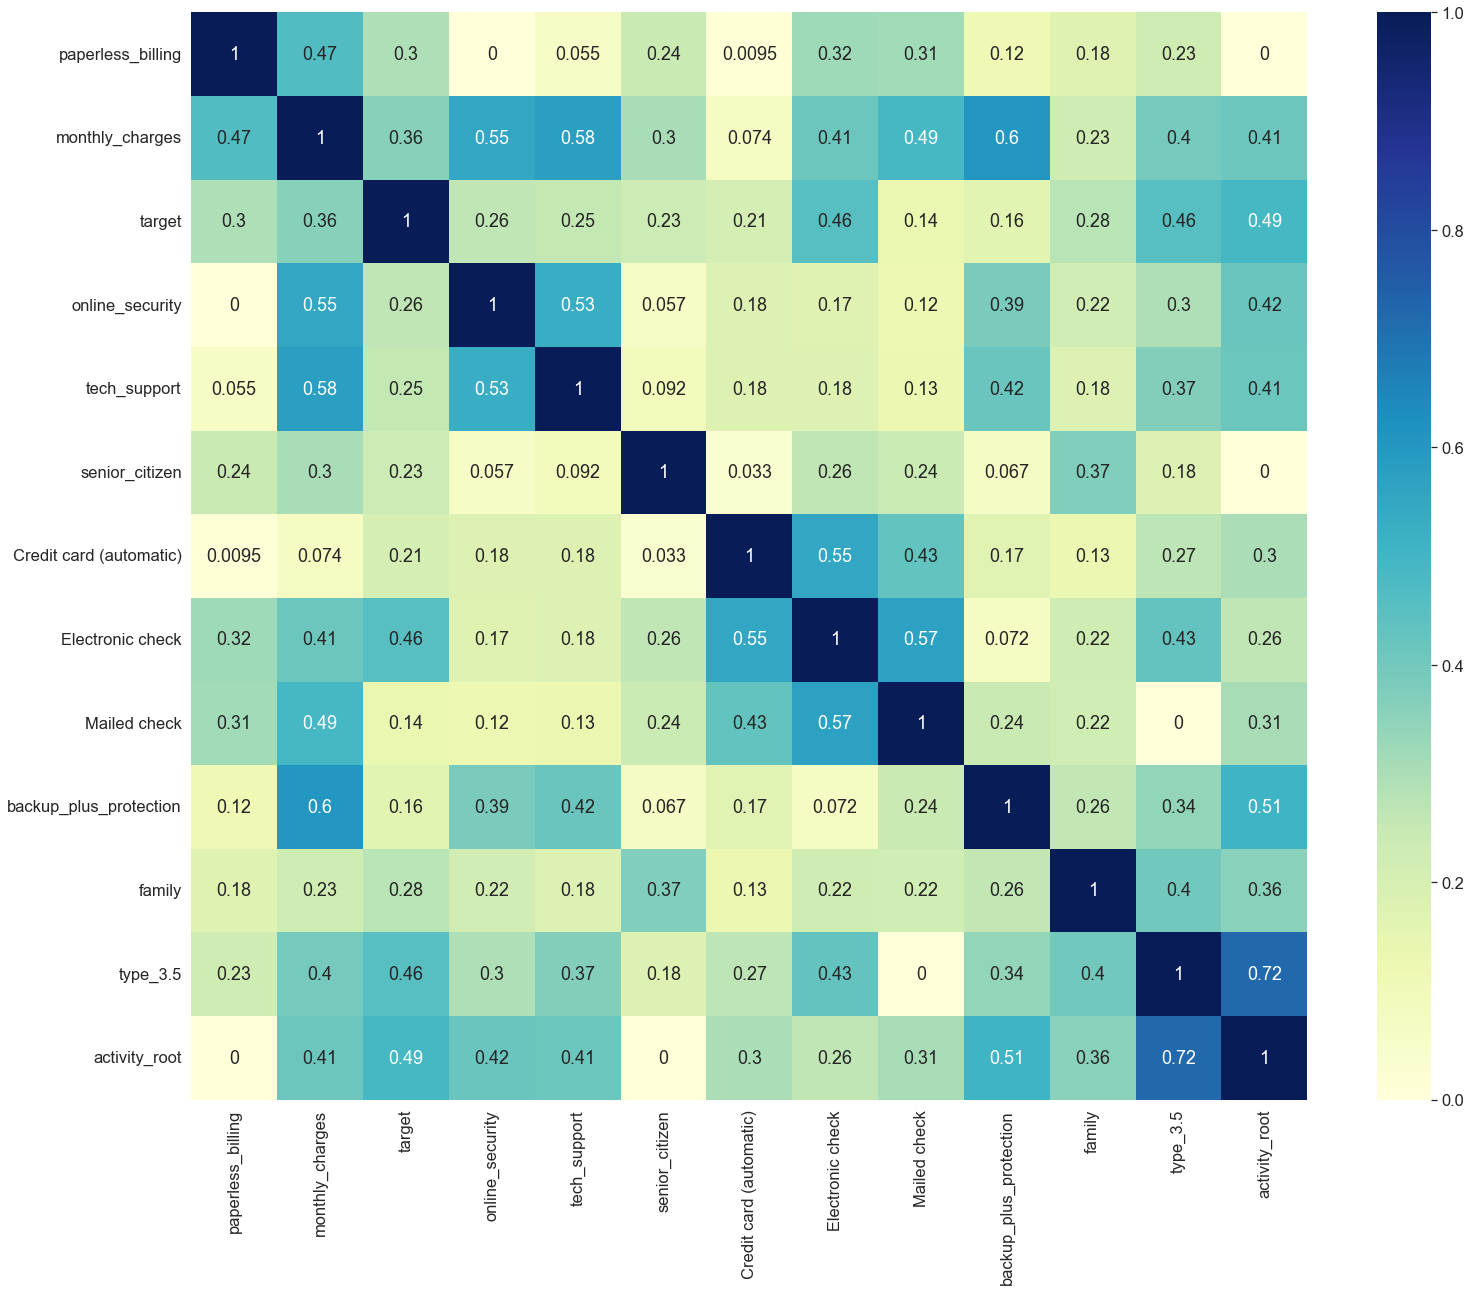

In [72]:
work_df['type_3.5'] = work_df.type ** 3.5
work_df['activity_root'] = work_df.activity ** .25
work_df = work_df.drop(columns=['daily_charge','type','activity'])
heatmap(work_df)

In [73]:
base_features = work_df.columns.tolist()
base_features

['paperless_billing',
 'monthly_charges',
 'target',
 'online_security',
 'tech_support',
 'senior_citizen',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check',
 'backup_plus_protection',
 'family',
 'type_3.5',
 'activity_root']

## Цель проекта и план работ


Итак, перед нами задача классификации при дисбалансе классов.

- Метрики: ROC-AUC, F1
- Модели: градиентный бустинг (catboost) + попробуем простую логистическую регрессию - у нас не так много данных; также попробуем что-нибудь нейронное - может получиться даже эффективнее катбуст

План работ:
1. Сбалансировать классы; под вопросом - плодить дубликаты не хотелось бы (возможно попробуем SMOTE, но этот метод переделает метрики из бинарных в непрерывные)
2. Сделать пайплайн для __catboost__: one-hot encoder (из незакодированного вручную осталась всего 1 переменная) + scaler + gridsearchCV
3. Собрать архитектуру для нейронки; попробуем 2-8 слоёв, от 3 до n нейронов, где n - количество наших признаков

## Вопросы:

В большинстве своём вопросы раскиданы по ходу работы.

Дополнительно:
- будут ли какие-то рекомендации по поводу нейронки?
- будут ли какие-то рекомендации по поводу балансировки классов?
- как дополнительно можно проинжинирить фичи (кроме тех вариантов, которые я уже попробовал)

# Обучение моделей

## Отбор признаков

В первую очередь мы всё же попробуем сперва сделать много разных искусственных фичей (причем даже таких, которые мы отбрасывали), а затем - выберем те, которые влияют на нашу метрику.

Что будем использовать:
1. SFS - будем наблюдать за динамикой метрики
2. Матрицы корреляции $\phi_k$
3. Попробуем те фичи, которые уже отобрали ранее

Для начала - список фичей, с которыми уже работали:

In [74]:
base_features

['paperless_billing',
 'monthly_charges',
 'target',
 'online_security',
 'tech_support',
 'senior_citizen',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check',
 'backup_plus_protection',
 'family',
 'type_3.5',
 'activity_root']

Здесь у нас 4 синтетических признака + ohe

1. Family - результат логистической регрессии
2. Backup_plus_protection - результат сложения 2 фичей
3. Степень 3.5 от type
4. Квадратный корень от activity

А теперь соберем операции для предобработки всех признаков:

1. Type мы закодируем по продолжительности оплаты - 1, 12 и 24 соответственно;
2. Internet_service кодируем в порядке возрастания технологии: 0 - интернета нет, 1 - dsl, 2 - fiber optic
3. Отбросим даты
4. Сформируем фичи по доп услугам.
5. Сформируем фичи, которые коррелируют при мат. преобразованиях
6. Сформируем фичи по семейному статусу (базовые)
7. Разделим выборку на трейн и тест
8. Сформируем фичи по семейному статусу (предсказания логистической регрессии)
9. payment_method кодируем через one-hot кодировку.

In [75]:
work_df = df.copy(deep=True)

In [76]:
type_repl = {'Month-to-month':1,'One year':12, 'Two year':24}
work_df = work_df.replace(type_repl)
work_df.internet_service.unique()

array(['DSL', 'Fiber optic', 'no_internet'], dtype=object)

In [77]:
net_repl = {'DSL':1,'no_internet':0,'Fiber optic':2}
work_df = work_df.replace(net_repl)
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   int64         
 3   paperless_billing  7032 non-null   int64         
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float32       
 7   target             7032 non-null   float64       
 8   end_date_remake    7032 non-null   datetime64[ns]
 9   activity           7032 non-null   int64         
 10  internet_service   7032 non-null   int64         
 11  online_security    7032 non-null   float64       
 12  online_backup      7032 non-null   float64       
 13  device_protection  7032 non-null   float64       
 14  tech_sup

In [78]:
work_df = work_df.drop(columns=['begin_date','end_date','end_date_remake'])

In [79]:
work_df['daily_charge'] = work_df.total_charges / work_df.activity

work_df['add_services'] = work_df[['online_backup','device_protection',
                                   'streaming_t_v','streaming_movies','online_security','tech_support']].sum(axis=1)

work_df['streaming_sum'] = work_df[['streaming_t_v','streaming_movies']].sum(axis=1)
work_df['streaming_prod'] = work_df.streaming_t_v * work_df.streaming_movies



work_df['add_prod_wo_streaming'] = work_df.online_backup * work_df.device_protection * \
                            work_df.online_security * work_df.tech_support
work_df['add_sum_wo_streaming'] = work_df[['online_backup','device_protection',
                                   'online_security','tech_support']].sum(axis=1)

work_df['support_security_prod'] = work_df.tech_support * work_df.online_security
work_df['support_plus_security'] = work_df.tech_support + work_df.online_security
work_df['backup_plus_protection'] = work_df.online_backup + work_df.device_protection
work_df['backup_protection_prod'] = work_df.online_backup * work_df.device_protection


In [80]:
work_df['type_3.5'] = work_df.type ** 3.5
work_df['activity_root'] = work_df.activity ** .25

In [81]:
work_df['family'] = work_df.partner * work_df.dependents

In [82]:
train, test = train_test_split(work_df, test_size=.25, random_state=300123)


In [83]:
fam_model = LogisticRegression(max_iter=10000)
fam_model.fit(train[['dependents','partner']],train['target'])

train['family_logreg'] = train.dependents * fam_model.coef_[0][0] + \
                        train.partner * fam_model.coef_[0][1] + fam_model.intercept_

test['family_logreg'] = test.dependents * fam_model.coef_[0][0] + \
                        test.partner * fam_model.coef_[0][1] + fam_model.intercept_

work_df = pd.concat([train,test]).reset_index(drop=True)
work_df

type  paperless_billing             payment_method  monthly_charges  \
0        1                  1  Bank transfer (automatic)            44.65   
1       12                  1  Bank transfer (automatic)            86.20   
2       12                  1           Electronic check           111.25   
3        1                  1  Bank transfer (automatic)           100.50   
4       12                  1               Mailed check            24.45   
...    ...                ...                        ...              ...   
7027     1                  1           Electronic check            94.70   
7028     1                  0               Mailed check            18.85   
7029    24                  1  Bank transfer (automatic)            25.10   
7030    12                  0           Electronic check            91.25   
7031     1                  0    Credit card (automatic)            88.60   

      total_charges  target  activity  internet_service  online_security  \
0        322.500000     0.0       215                 1              0.0   
1       3339.050049     0.0      1248                 2              0.0   
2       7511.649902     0.0      2041                 2              1.0   
3       3653.350098     1.0      1064                 2              1.0   
4       1431.650024     0.0      1706                 0              0.0   
...             ...     ...       ...               ...              ...   
7027    1687.949951     1.0       548                 2              0.0   
7028      84.199997     0.0       123                 0              0.0   
7029    1725.000000     0.0      1979                 0              0.0   
7030    4738.299805     0.0      1584                 2              1.0   
7031    2888.699951     0.0      1006                 2              0.0   

      online_backup  ...  add_prod_wo_streaming  add_sum_wo_streaming  \
0               0.0  ...                    0.0                   0.0   
1               1.0  ...                    0.0                   3.0   
2               0.0  ...                    0.0                   3.0   
3               1.0  ...                    0.0                   3.0   
4               0.0  ...                    0.0                   0.0   
...             ...  ...                    ...                   ...   
7027            0.0  ...                    0.0                   0.0   
7028            0.0  ...                    0.0                   0.0   
7029            0.0  ...                    0.0                   0.0   
7030            0.0  ...                    0.0                   2.0   
7031            1.0  ...                    0.0                   3.0   

      support_security_prod  support_plus_security  backup_plus_protection  \
0                       0.0                    0.0                     0.0   
1                       0.0                    1.0                     2.0   
2                       1.0                    2.0                     1.0   
3                       1.0                    2.0                     1.0   
4                       0.0                    0.0                     0.0   
...                     ...                    ...                     ...   
7027                    0.0                    0.0                     0.0   
7028                    0.0                    0.0                     0.0   
7029                    0.0                    0.0                     0.0   
7030                    0.0                    1.0                     1.0   
7031                    0.0                    1.0                     2.0   

      backup_protection_prod      type_3.5  activity_root  family  \
0                        0.0      1.000000       3.829214       0   
1                        1.0   5985.967591       5.943656       0   
2                        0.0   5985.967591       6.721416       0   
3                        0.0      1.000000       5.711306       0   
4        

Также заранее приготовим себе трансформер для GridSearchCV:

In [84]:
train_ohe_cols = train.select_dtypes(include='object').columns.tolist()
train_scaler_cols = train.drop(columns='target').select_dtypes(include=np.number).columns.tolist()

По умолчанию любые трансформеры/ FeatureUnion не позволяет вынуть имена фичей. Сделаем собственный новый класс:

In [85]:
class ColumnTransformerWithNames(ColumnTransformer):
        
        
    def get_feature_names(column_transformer):
        """Get feature names from all transformers.
        Returns
        -------
        feature_names : list of strings
            Names of the features produced by transform.
        """
        def get_names(trans):
            if trans == 'drop' or (
                    hasattr(column, '__len__') and not len(column)):
                return []
            if trans == 'passthrough':
                if hasattr(column_transformer, '_df_columns'):
                    if ((not isinstance(column, slice))
                            and all(isinstance(col, str) for col in column)):
                        return column
                    else:
                        return column_transformer._df_columns[column]
                else:
                    indices = np.arange(column_transformer._n_features)
                    return ['x%d' % i for i in indices[column]]
            if not hasattr(trans, 'get_feature_names'):
         
                if column is None:
                    return []
                else:
                    return [#name + "__" + 
                            f for f in column]

            return [#name + "__" + 
                    f for f in trans.get_feature_names()]

        feature_names = []

        if type(column_transformer) == sklearn.pipeline.Pipeline:
            l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
        else:
            # For column transformers, follow the original method
            l_transformers = list(column_transformer._iter(fitted=True))


        for name, trans, column, _ in l_transformers: 
            if type(trans) == sklearn.pipeline.Pipeline:
                # Recursive call on pipeline
                _names = column_transformer.get_feature_names(trans)
                # if pipeline has no transformer that returns names
                if len(_names)==0:
                    _names = [#name + "__" + 
                              f for f in column]
                feature_names.extend(_names)
            else:
                feature_names.extend(get_names(trans))

        return feature_names
        
    def transform(self, X):
        indices = X.index.values.tolist()
        original_columns = X.columns.values.tolist()
        X_mat = super().transform(X)
        new_cols = self.get_feature_names()
        new_X = pd.DataFrame(X_mat, index=indices, columns=new_cols)
        return new_X

    def fit_transform(self, X, y=None):
        super().fit_transform(X, y)
        return self.transform(X)

In [86]:
train_ohe_cols = train.select_dtypes(include='object').columns.tolist()
train_scaler_cols = train.drop(columns='target').select_dtypes(include=np.number).columns.tolist()
transformer = ColumnTransformerWithNames([('ohe',OneHotEncoder(handle_unknown='ignore'),train_ohe_cols),
                                      ('scaler',StandardScaler(),train_scaler_cols)], remainder='passthrough')

In [87]:
transformer.fit_transform(train.drop(columns='target'))

x0_Bank transfer (automatic)  x0_Credit card (automatic)  \
4462                           1.0                         0.0   
380                            1.0                         0.0   
881                            0.0                         0.0   
1878                           1.0                         0.0   
1675                           0.0                         0.0   
...                            ...                         ...   
4441                           0.0                         0.0   
2251                           0.0                         1.0   
1664                           0.0                         1.0   
6787                           0.0                         0.0   
6367                           1.0                         0.0   

      x0_Electronic check  x0_Mailed check      type  paperless_billing  \
4462                  0.0              0.0 -0.821327           0.830242   
380                   0.0              0.0  0.334011           0.830242   
881                   1.0              0.0  0.334011           0.830242   
1878                  0.0              0.0 -0.821327           0.830242   
1675                  0.0              1.0  0.334011           0.830242   
...                   ...              ...       ...                ...   
4441                  1.0              0.0  1.594381          -1.204468   
2251                  0.0              0.0  0.334011          -1.204468   
1664                  0.0              0.0 -0.821327           0.830242   
6787                  0.0              1.0 -0.821327           0.830242   
6367                  0.0              0.0  1.594381          -1.204468   

      monthly_charges  total_charges  activity  internet_service  ...  \
4462        -0.662416      -0.863809 -1.032828         -0.281713  ...   
380          0.716057       0.469671  0.349076          0.999109  ...   
881          1.547123       2.314189  1.409918          0.999109  ...   
1878         1.190478       0.608609  0.102928          0.999109  ...   
1675        -1.332577      -0.373504  0.961769         -1.562535  ...   
...               ...            ...       ...               ...  ...   
4441         1.329818       1.793515  1.122300          0.999109  ...   
2251         0.032626      -0.559897 -0.709091         -0.281713  ...   
1664         0.331213      -0.763728 -0.992695          0.999109  ...   
6787         0.183578      -0.614402 -0.790694          0.999109  ...   
6367        -1.501776      -0.457870  1.368447         -1.562535  ...   

      add_prod_wo_streaming  add_sum_wo_streaming  support_security_prod  \
4462              -0.268237             -0.983136              -0.426282   
380               -0.268237              1.356340              -0.426282   
881               -0.268237              1.356340               2.345865   
1878              -0.268237              1.356340               2.345865   
1675              -0.268237             -0.983136              -0.426282   
...                     ...                   ...                    ...   
4441              -0.268237              0.576515              -0.426282   
2251               3.728043              2.136166               2.345865   
1664              -0.268237             -0.983136              -0.426282   
6787              -0.268237             -0.983136              -0.426282   
6367              -0.268237             -0.983136              -0.426282   

      support_plus_security  backup_plus_protection  backup_protection_prod  \
4462               -0.77108               -0.895182               -0.480721   
380                 0.57461                1.708176                2.080210   
881                 1.92030                0.406497               -0.480721   
1878                1.92030                0.406497               -0.480721   
1675               -0.77108               -0.895182               -0.480721   
...                     ...                     

In [88]:
transformer.get_feature_names()

['x0_Bank transfer (automatic)',
 'x0_Credit card (automatic)',
 'x0_Electronic check',
 'x0_Mailed check',
 'type',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'activity',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'senior_citizen',
 'partner',
 'dependents',
 'daily_charge',
 'add_services',
 'streaming_sum',
 'streaming_prod',
 'add_prod_wo_streaming',
 'add_sum_wo_streaming',
 'support_security_prod',
 'support_plus_security',
 'backup_plus_protection',
 'backup_protection_prod',
 'type_3.5',
 'activity_root',
 'family',
 'family_logreg']

Отлично - наш новый класс работает!

### SFS

SFS не работает с пайплайнами - нужно завести 2 энкодера:

In [89]:
sfs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
sfs_scaler=StandardScaler()

In [90]:
sfs_features = work_df.copy(deep=True).drop(columns='target')
sfs_target = work_df.copy(deep=True).target


In [91]:
sfs_features, sfs_ohe = encoding(sfs_features, sfs_ohe, drop_first=False)
sfs_features, sfs_scaler = encoding(sfs_features, sfs_scaler, 'number')

In [92]:
sfs_features

type  paperless_billing  monthly_charges  total_charges  activity  \
0    -0.818975           0.828939        -0.669735      -0.865081 -1.034049   
1     0.333942           0.828939         0.711405       0.465783  0.348630   
2     0.333942           0.828939         1.544078       2.306682  1.410067   
3    -0.818975           0.828939         1.186743       0.604449  0.102344   
4     0.333942           0.828939        -1.341192      -0.375737  0.961666   
...        ...                ...              ...            ...       ...   
7027 -0.818975           0.828939         0.993949      -0.262661 -0.588326   
7028 -0.818975          -1.206361        -1.527339      -0.970216 -1.157192   
7029  1.591671           0.828939        -1.319586      -0.246315  1.327079   
7030  0.333942          -1.206361         0.879269       1.083115  0.798368   
7031 -0.818975          -1.206361         0.791182       0.267095  0.024711   

      internet_service  online_security  online_backup  device_protection  \
0            -0.287852        -0.633746      -0.725516          -0.723918   
1             0.996525        -0.633746       1.378330           1.381372   
2             0.996525         1.577918      -0.725516           1.381372   
3             0.996525         1.577918       1.378330          -0.723918   
4            -1.572229        -0.633746      -0.725516          -0.723918   
...                ...              ...            ...                ...   
7027          0.996525        -0.633746      -0.725516          -0.723918   
7028         -1.572229        -0.633746      -0.725516          -0.723918   
7029         -1.572229        -0.633746      -0.725516          -0.723918   
7030          0.996525         1.577918      -0.725516           1.381372   
7031          0.996525        -0.633746       1.378330           1.381372   

      tech_support  ...  backup_plus_protection  backup_protection_prod  \
0        -0.639260  ...               -0.897846               -0.479600   
1         1.564308  ...                1.709485                2.085073   
2         1.564308  ...                0.405820               -0.479600   
3         1.564308  ...                0.405820               -0.479600   
4        -0.639260  ...               -0.897846               -0.479600   
...            ...  ...                     ...                     ...   
7027     -0.639260  ...               -0.897846               -0.479600   
7028     -0.639260  ...               -0.897846               -0.479600   
7029     -0.639260  ...               -0.897846               -0.479600   
7030     -0.639260  ...                0.405820               -0.479600   
7031      1.564308  ...                1.709485                2.085073   

      type_3.5  activity_root    family  family_logreg  \
0    -0.617676      -0.894130 -0.573409       0.905298   
1    -0.406195       0.572268 -0.573409      -0.024828   
2    -0.406195       1.111656 -0.573409      -0.024828   
3    -0.617676       0.411129 -0.573409      -0.024828   
4    -0.406195       0.907335  1.743955      -1.554193   
...        ...            ...       ...            ...   
7027 -0.617676      -0.194295 -0.573409      -0.024828   
7028 -0.617676      -1.240171  1.743955      -1.554193   
7029  1.775321       1.075845 -0.573409       0.905298   
7030 -0.406195       0.825420 -0.573409       0.905298   
7031 -0.617676       0.356011  1.743955      -1.554193   

      Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
0                      1.886879                -0.525351         -0.711863   
1                      1.886879                -0.525351         -0.711863   
2                     -0.529976                -0.525351          1.404764   
3                      1.886879                -0.525351         -0.711863   
4                     -0.529976                -0.525351         -0.711863   
...                         ...                      ...              

Тестировать будем на случайном лесе. Сделаем не очень глубокое дерево

In [93]:
%%time

sfsf_model = RandomForestClassifier(max_depth=3, n_estimators=100, 
                               random_state=300123)


sfs_forward = SFS(sfsf_model, k_features='best', verbose=2, 
                  scoring='roc_auc', forward=True, n_jobs=-1, floating=True)
sfs_forward.fit(sfs_features,sfs_target)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:    3.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    3.3s finished

[2023-02-14 16:30:41] Features: 1/33 -- score: 0.7709293165690381[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    3.7s finished

[2023-02-14 16:30:45] Features: 2/33 -- score: 0.8430320347154282[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:    2.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s finished

[2023-02-14 16:30:49] Features: 

[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.1s finished

[2023-02-14 16:31:51] Features: 14/33 -- score: 0.8524705263196054[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:    1.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.2s finished

[2023-02-14 16:31:56] Features: 15/33 -- score: 0.8528250434824939[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    1.6s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.8s finished

[2023-02-14 16:33:04] Features: 22/33 -- score: 0.8536828728385348[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    1.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    2.9s finished

[2023-02-14 16:33:08] Features: 23/33 -- score: 0.8528673147565409[Parallel(n_jobs=-1)]: Usin

[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  28 | elapsed:    3.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    4.3s finished

[2023-02-14 16:34:41] Features: 29/33 -- score: 0.8519965301820376[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  29 | elapsed:    3.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=

Wall time: 4min 49s



[2023-02-14 16:35:27] Features: 33/33 -- score: 0.8500615249241076

SequentialFeatureSelector(estimator=RandomForestClassifier(max_depth=3,
                                                           random_state=300123),
                          floating=True, k_features=(1, 33), n_jobs=-1,
                          scoring='roc_auc', verbose=2)

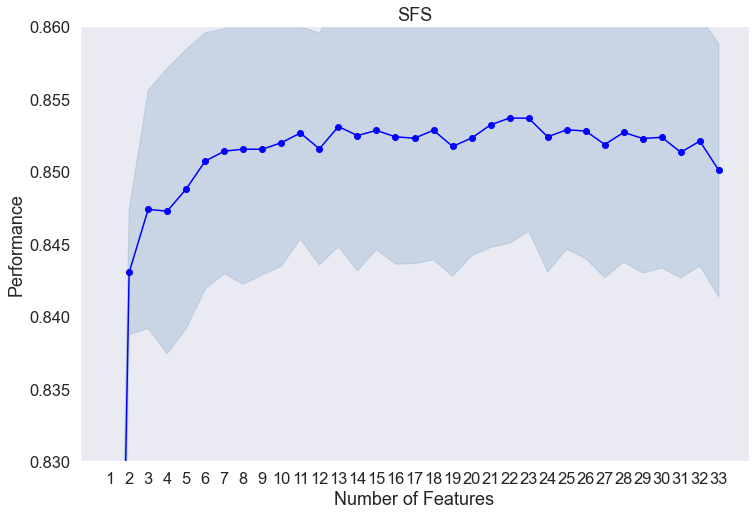

In [94]:
plot_sfs(sfs_forward.get_metric_dict(),figsize=(12,8), kind='std_dev')

plt.ylim([0.83, 0.86])
plt.title('SFS')
plt.grid()
plt.show()

In [238]:
sfs_forward.k_feature_names_

('type',
 'paperless_billing',
 'monthly_charges',
 'activity',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'streaming_t_v',
 'streaming_movies',
 'senior_citizen',
 'streaming_sum',
 'streaming_prod',
 'support_plus_security',
 'backup_plus_protection',
 'backup_protection_prod',
 'activity_root',
 'family',
 'Bank transfer (automatic)',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check')

In [96]:
sfsf_dropped = list(set(sfs_features.columns.tolist()) - set(sfsf_features))
sfsf_dropped

['daily_charge',
 'support_security_prod',
 'add_prod_wo_streaming',
 'add_sum_wo_streaming',
 'total_charges',
 'partner',
 'type_3.5',
 'dependents',
 'family_logreg',
 'tech_support',
 'add_services']

Среди фичей, важных для жадного алгоритма, оказалось несколько синтетических:
- activity_root;
- family
- фичи из OHE

Зафиксируем и пройдемся алгоритмом в обратном направлении:

In [97]:
%%time

sfsb_model = RandomForestClassifier(max_depth=3, n_estimators=100, 
                               random_state=300123)


sfs_backward = SFS(sfsb_model, k_features='best', verbose=2, 
                  scoring='roc_auc', forward=False, n_jobs=-1, floating=True)

sfs_backward.fit(sfs_features, sfs_target)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:    4.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    5.1s finished

[2023-02-14 16:35:33] Features: 32/1 -- score: 0.8520900501920341[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:    4.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    4.9s finished

[2023-02-14 16:35:38] Features: 31/1 -- score: 0.8517508108437456[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:    3.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished

[2023-02-14 16:35:44] Features: 

[Parallel(n_jobs=-1)]: Done  12 out of  23 | elapsed:    1.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.3s finished

[2023-02-14 16:37:05] Features: 23/1 -- score: 0.8535194425035106[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  23 | elapsed:    1.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished

[2023-02-14 16:38:11] Features: 17/1 -- score: 0.8530072484959291[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  17 | elapsed:    1.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    1.4s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.4s finished

[2023-02-14 16:38:17] Features: 16/1 -- score: 0.8527611777787121[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1

[Parallel(n_jobs=-1)]: Done  12 out of  23 | elapsed:    1.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    3.2s finished

[2023-02-14 16:39:26] Features: 9/1 -- score: 0.8515331450740966[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    2.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.3s finished

[2023-02-14 16:39:31] Features: 8/1 -- score: 0.8505261067558051[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using ba

Wall time: 4min 47s


[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    4.0s finished

[2023-02-14 16:40:15] Features: 1/1 -- score: 0.7709293165690381

SequentialFeatureSelector(estimator=RandomForestClassifier(max_depth=3,
                                                           random_state=300123),
                          floating=True, forward=False, k_features=(1, 33),
                          n_jobs=-1, scoring='roc_auc', verbose=2)

In [98]:
sfsb_features = sfs_backward.k_feature_names_

In [99]:
sfsb_features

('type',
 'paperless_billing',
 'monthly_charges',
 'activity',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'streaming_t_v',
 'streaming_movies',
 'senior_citizen',
 'daily_charge',
 'streaming_sum',
 'streaming_prod',
 'add_prod_wo_streaming',
 'support_plus_security',
 'backup_protection_prod',
 'activity_root',
 'family',
 'Bank transfer (automatic)',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check')

In [100]:
sfsb_dropped = list(set(sfs_features.columns.tolist()) - set(sfsb_features))
sfsb_dropped

['backup_plus_protection',
 'support_security_prod',
 'add_sum_wo_streaming',
 'total_charges',
 'partner',
 'type_3.5',
 'dependents',
 'family_logreg',
 'tech_support',
 'add_services']

А здесь, в свою очередь, не оказалось 13 фичей.

Посмотрим, в чем их отличия

In [101]:
sfs_diff_features = set(sfsf_features) ^ set(sfsb_features)
sfs_diff_features

{'add_prod_wo_streaming', 'backup_plus_protection', 'daily_charge'}

Всего 3 фичи различаются - мы можем объединить множества в одно

### Матрица корреляции

Соберем вместе то, что алгоритм предлагает оставить и убрать и посмотрим матрицу корреляции:
1. Для прямого прохода SFS

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'streaming_sum', 'streaming_prod', 'support_plus_security', 'backup_plus_protection', 'backup_protection_prod', 'activity_root', 'family', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'target']


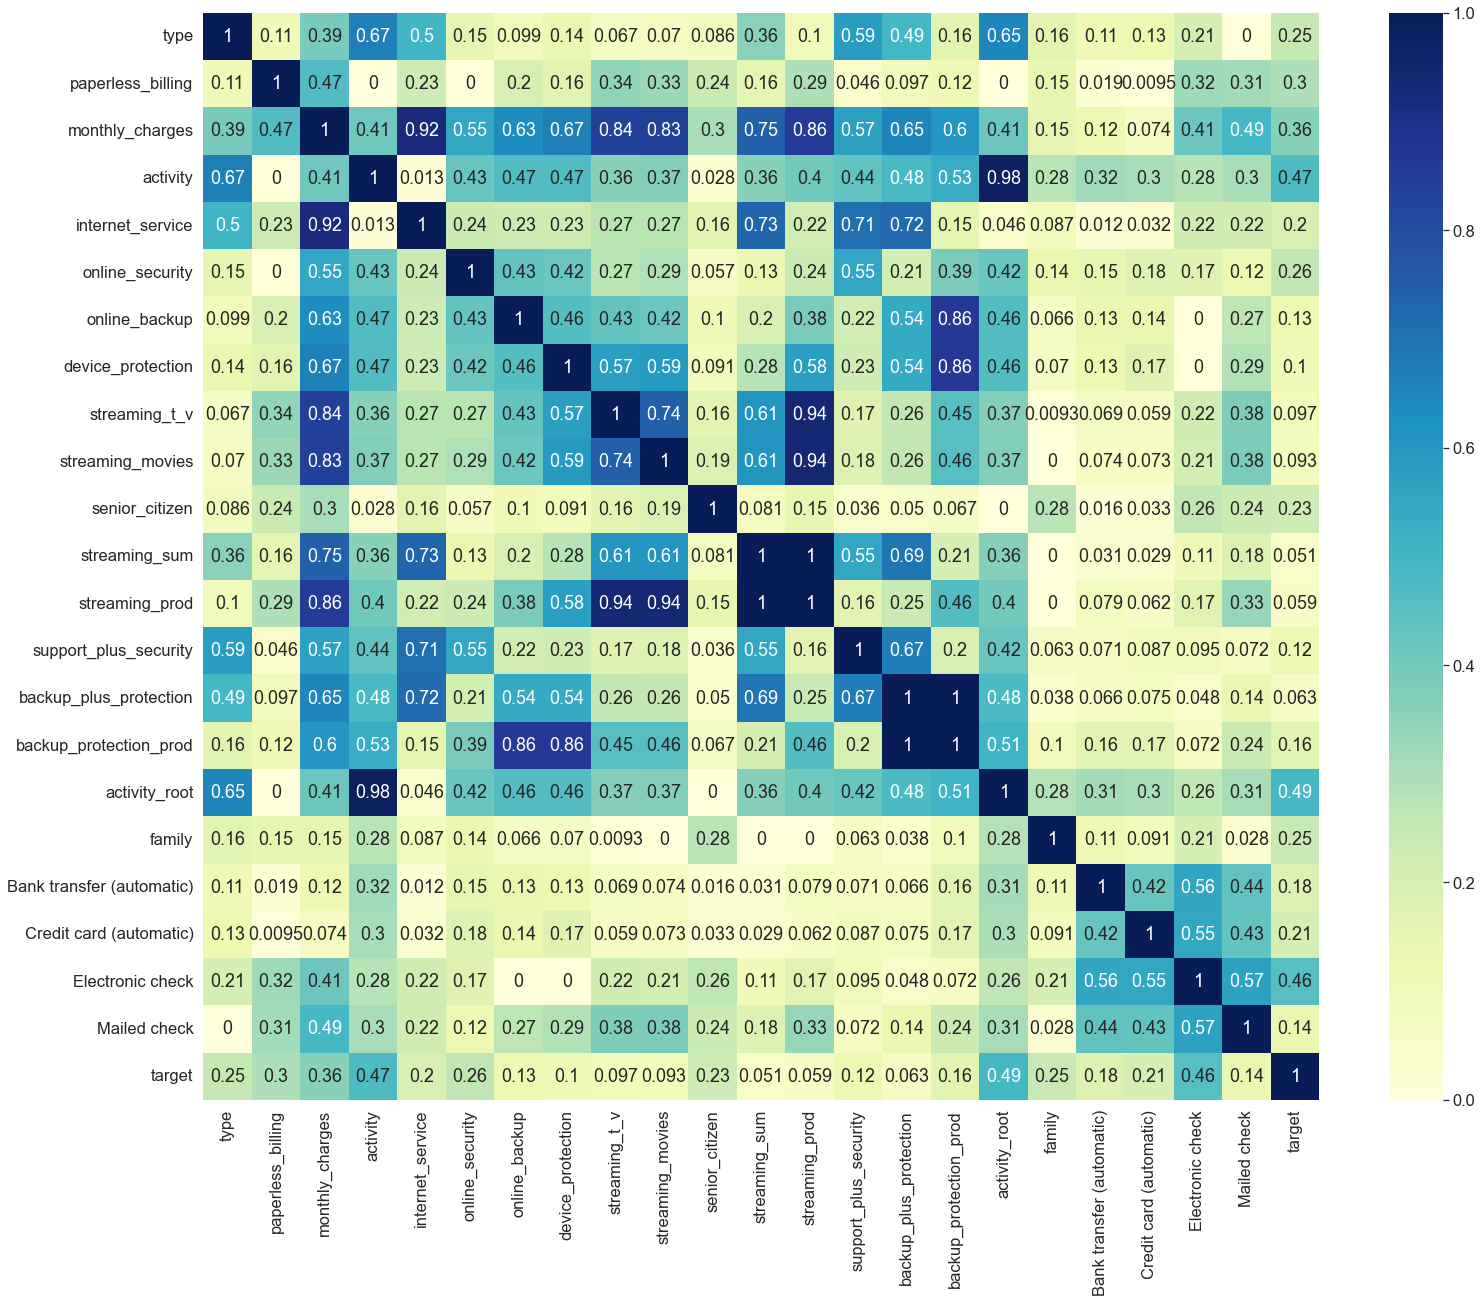

In [102]:
heatmap(pd.concat([sfs_features[list(sfsf_features)],sfs_target], axis=1))

interval columns not set, guessing: ['daily_charge', 'support_security_prod', 'add_prod_wo_streaming', 'add_sum_wo_streaming', 'total_charges', 'partner', 'type_3.5', 'dependents', 'family_logreg', 'tech_support', 'add_services', 'target']


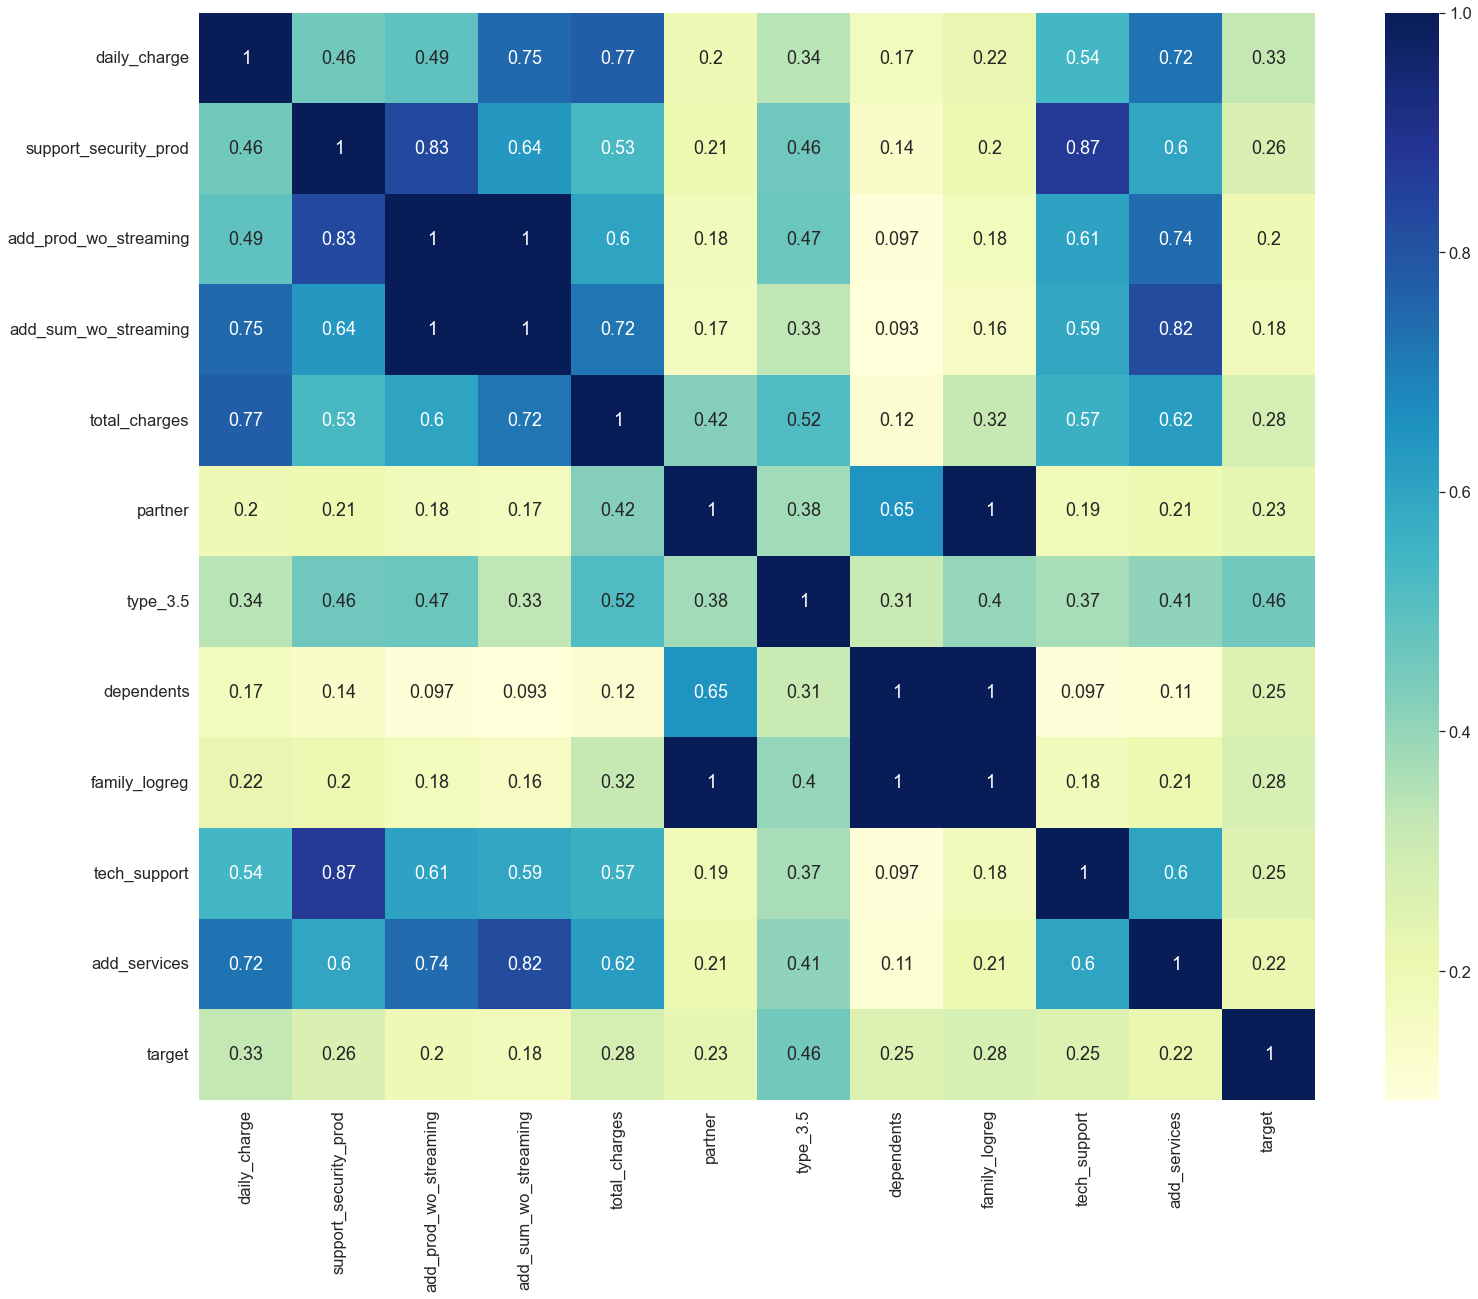

In [103]:
heatmap(pd.concat([sfs_features[sfsf_dropped],sfs_target], axis=1))

Видим, что корреляция $phi_k$ фиксирует корреляции там, где SFS не увидел вклада в лес, и наоборот

Посмотрим на обратный проход:

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'daily_charge', 'streaming_sum', 'streaming_prod', 'add_prod_wo_streaming', 'support_plus_security', 'backup_protection_prod', 'activity_root', 'family', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'target']


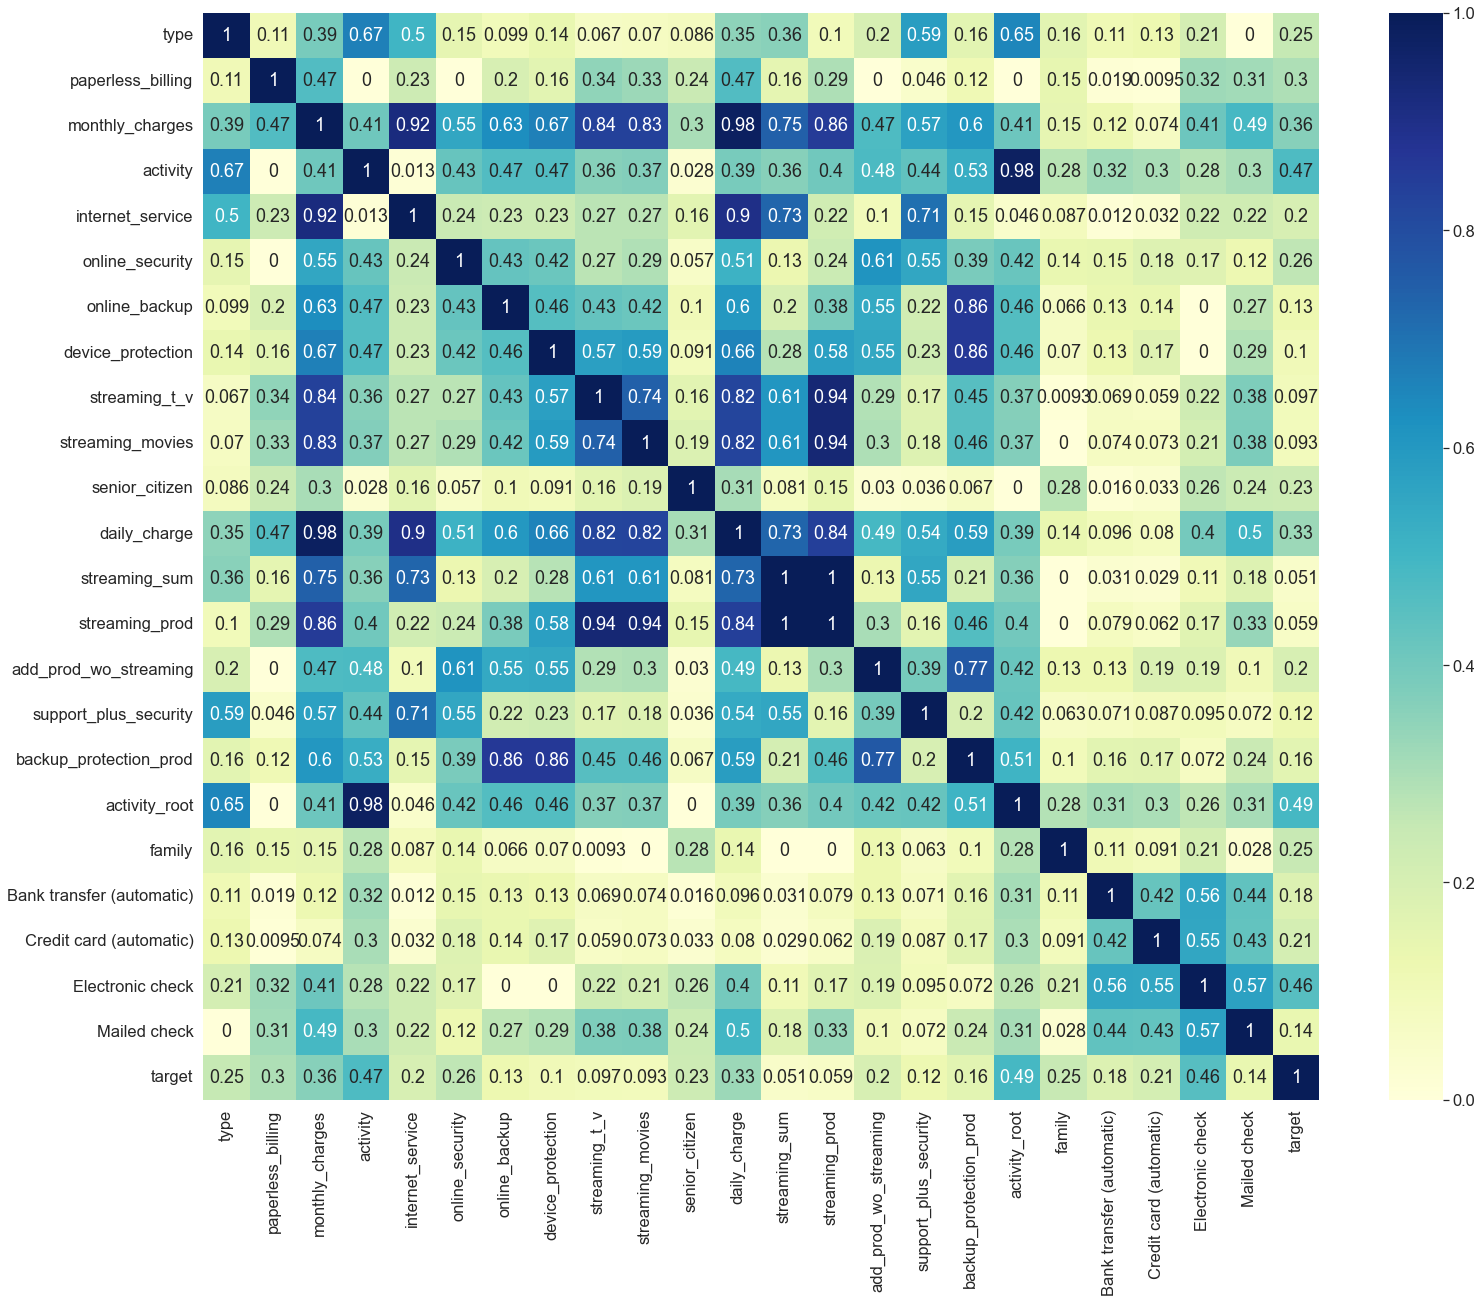

In [104]:
heatmap(pd.concat([sfs_features[list(sfsb_features)], sfs_target], axis=1))

interval columns not set, guessing: ['backup_plus_protection', 'support_security_prod', 'add_sum_wo_streaming', 'total_charges', 'partner', 'type_3.5', 'dependents', 'family_logreg', 'tech_support', 'add_services', 'target']


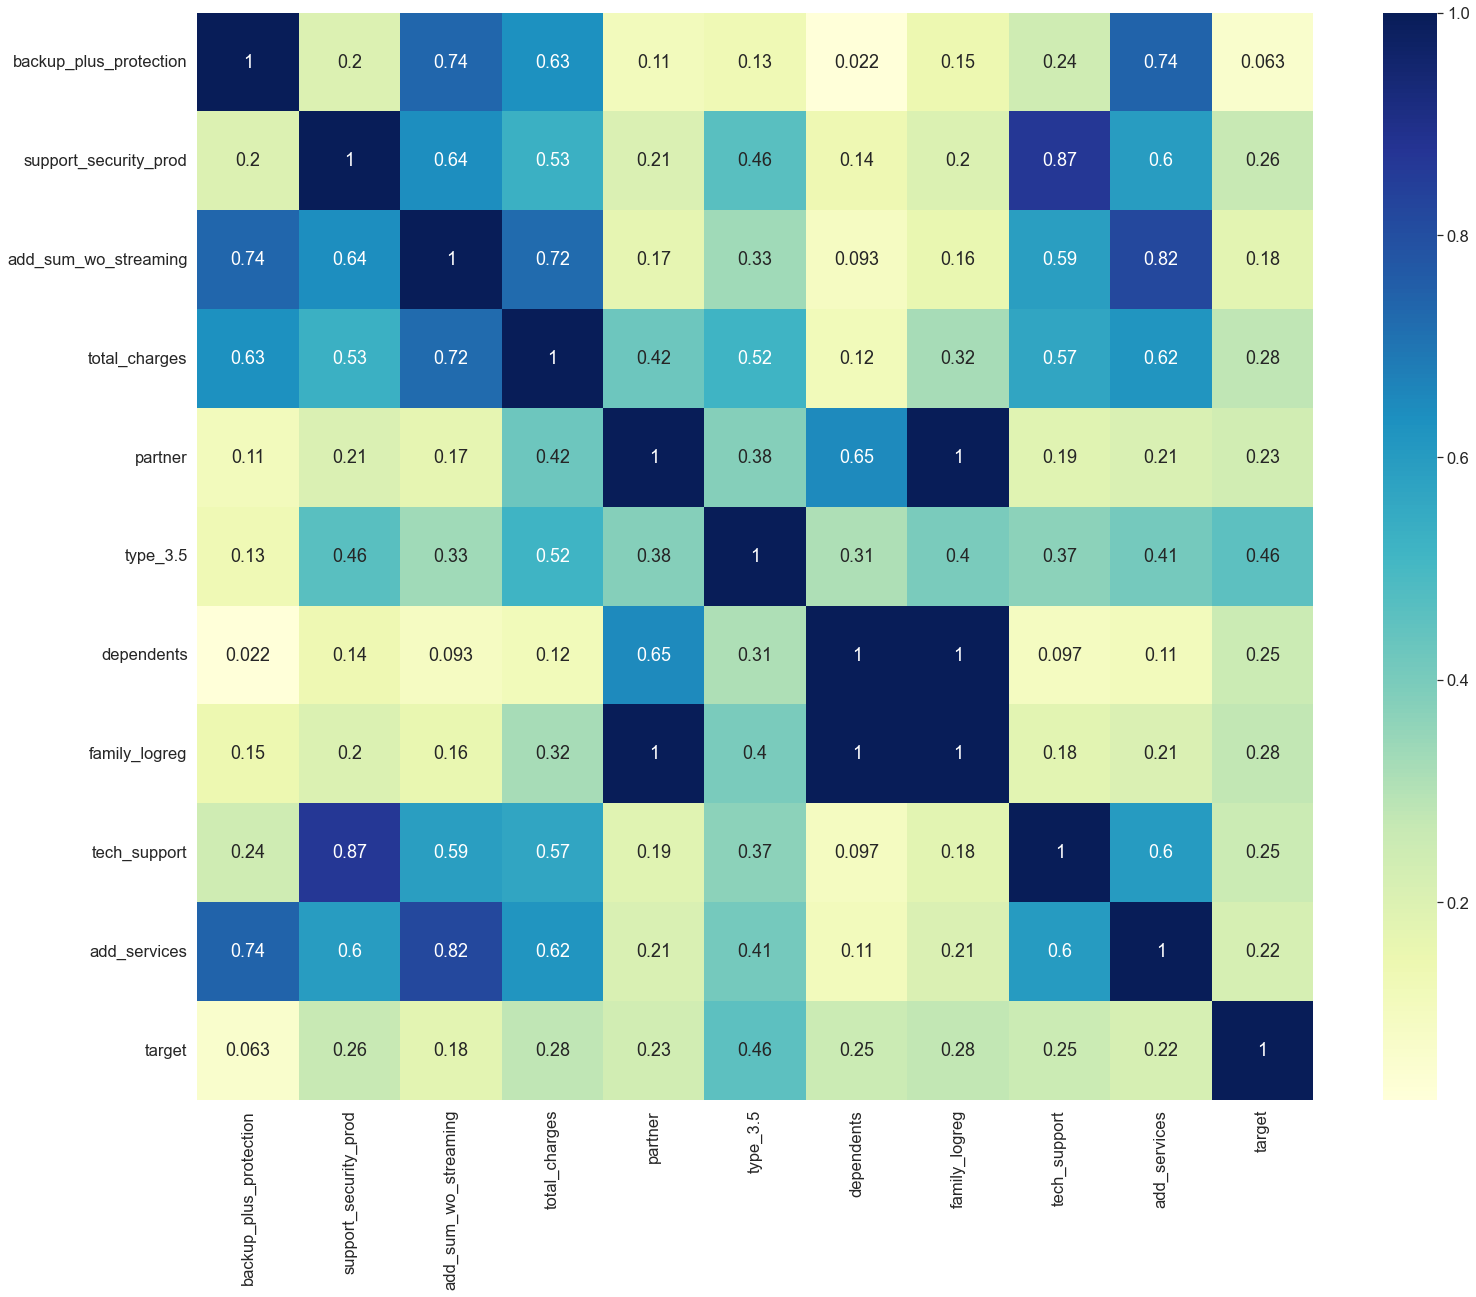

In [105]:
heatmap(pd.concat([sfs_features[sfsb_dropped],sfs_target], axis=1))

Здесь видим ту же самую картину.

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'daily_charge', 'add_services', 'streaming_sum', 'streaming_prod', 'add_prod_wo_streaming', 'add_sum_wo_streaming', 'support_security_prod', 'support_plus_security', 'backup_plus_protection', 'backup_protection_prod', 'type_3.5', 'activity_root', 'family', 'family_logreg']


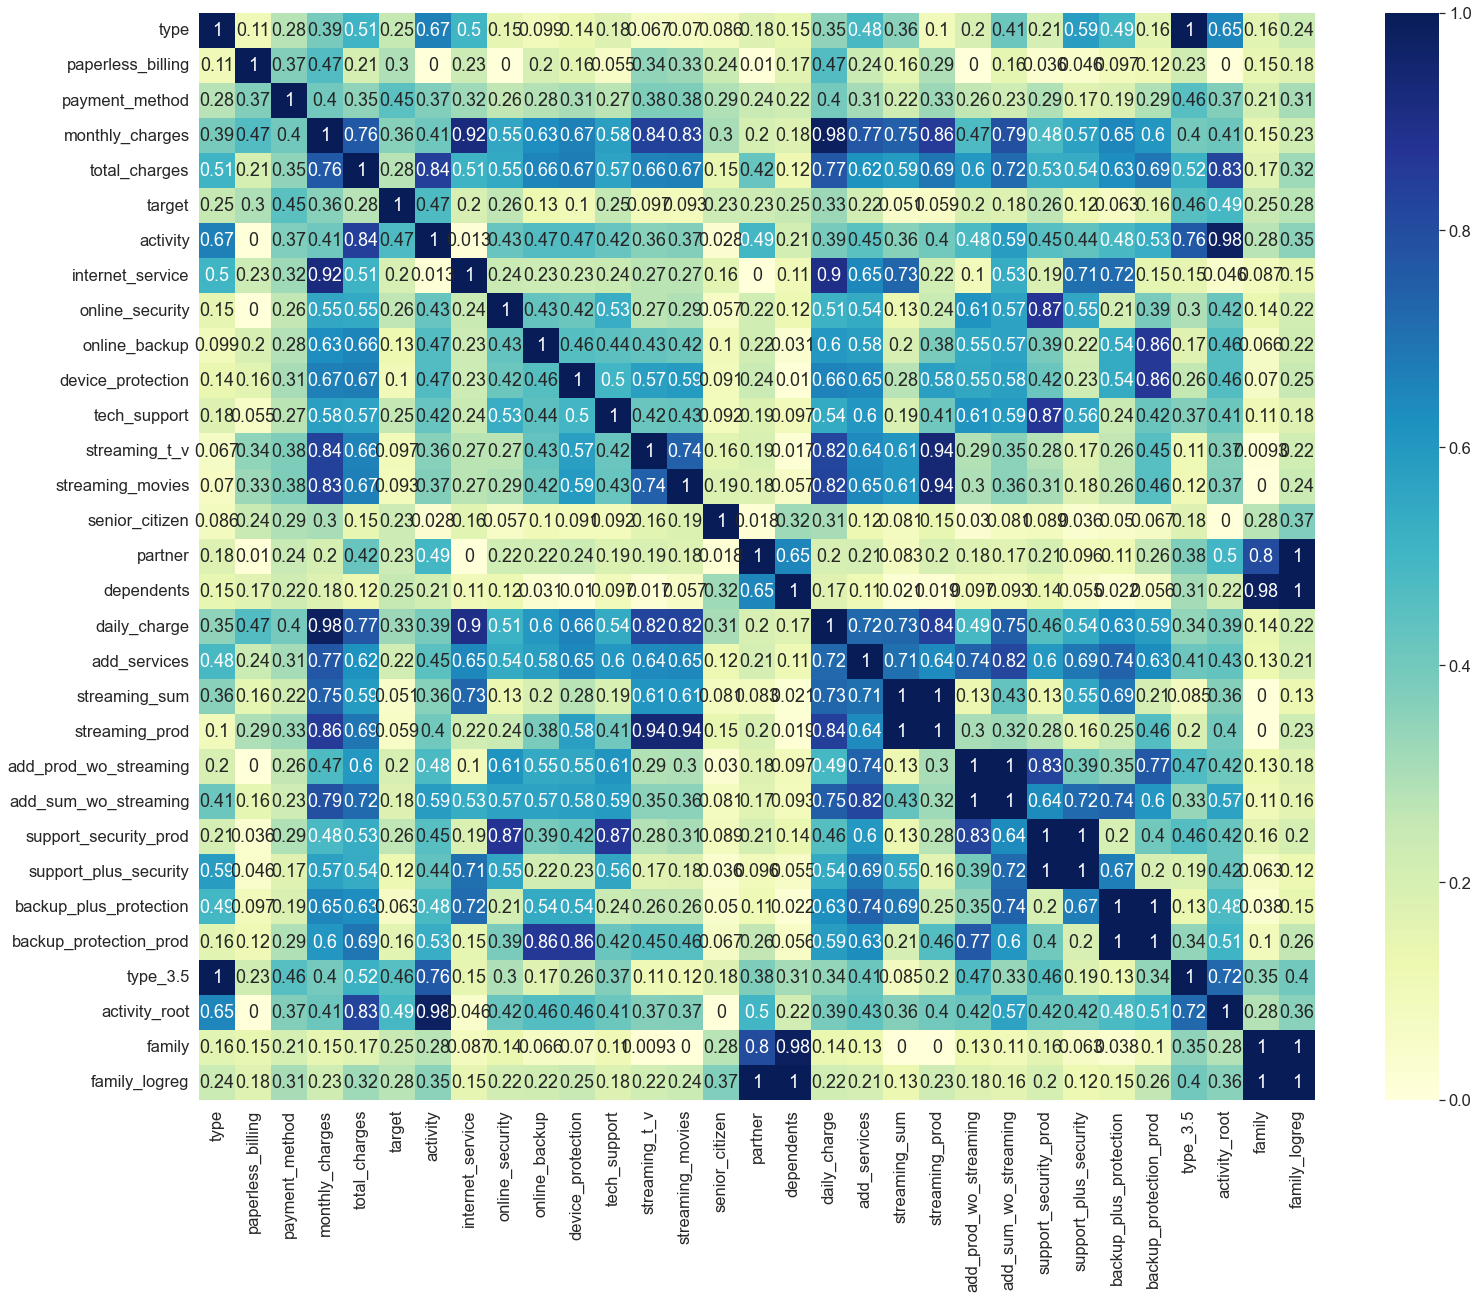

In [106]:
heatmap(work_df)

### Выбор признаков

Итоговое решение:
Мы возьмем 3 группы признаков: 
- изначальные
- те, что нашли SFS forward и SFS backward, 
- те, что демонстрируют корреляцию с таргетом выше 0.2, при этом между собой корреляция - меньше 0.85

#### Базовые фичи

In [107]:
base_df = work_df[['paperless_billing',
 'monthly_charges',
 'target',
 'online_security',
 'tech_support',
 'senior_citizen',
 'payment_method',
 'backup_plus_protection',
 'family_logreg',
 'type_3.5',
 'activity_root']].copy(deep=True)

In [108]:
base_df

paperless_billing  monthly_charges  target  online_security  \
0                     1            44.65     0.0              0.0   
1                     1            86.20     0.0              0.0   
2                     1           111.25     0.0              1.0   
3                     1           100.50     1.0              1.0   
4                     1            24.45     0.0              0.0   
...                 ...              ...     ...              ...   
7027                  1            94.70     1.0              0.0   
7028                  0            18.85     0.0              0.0   
7029                  1            25.10     0.0              0.0   
7030                  0            91.25     0.0              1.0   
7031                  0            88.60     0.0              0.0   

      tech_support  senior_citizen             payment_method  \
0              0.0               0  Bank transfer (automatic)   
1              1.0               0  Bank transfer (automatic)   
2              1.0               0           Electronic check   
3              1.0               1  Bank transfer (automatic)   
4              0.0               0               Mailed check   
...            ...             ...                        ...   
7027           0.0               0           Electronic check   
7028           0.0               0               Mailed check   
7029           0.0               0  Bank transfer (automatic)   
7030           0.0               0           Electronic check   
7031           1.0               0    Credit card (automatic)   

      backup_plus_protection  family_logreg      type_3.5  activity_root  
0                        0.0      -0.625458      1.000000       3.829214  
1                        2.0      -1.078564   5985.967591       5.943656  
2                        1.0      -1.078564   5985.967591       6.721416  
3                        1.0      -1.078564      1.000000       5.711306  
4                        0.0      -1.823588   5985.967591       6.426800  
...                      ...            ...           ...            ...  
7027                     0.0      -1.078564      1.000000       4.838326  
7028                     0.0      -1.823588      1.000000       3.330246  
7029                     0.0      -0.625458  67723.492408       6.669779  
7030                     1.0      -0.625458   5985.967591       6.308684  
7031                     2.0      -1.823588      1.000000       5.631829  

[7032 rows x 11 columns]

#### Фичи от feature selector

In [109]:
sfs_features = list(set(sfsf_features) | set(sfsb_features))

for el in [ 'Bank transfer (automatic)',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check']:
    
    sfs_features.remove(el)
sfs_features = sfs_features + ['payment_method','target']
sfs_features

['streaming_t_v',
 'streaming_prod',
 'paperless_billing',
 'online_backup',
 'streaming_movies',
 'activity_root',
 'family',
 'monthly_charges',
 'backup_protection_prod',
 'streaming_sum',
 'add_prod_wo_streaming',
 'online_security',
 'activity',
 'daily_charge',
 'backup_plus_protection',
 'type',
 'internet_service',
 'device_protection',
 'senior_citizen',
 'support_plus_security',
 'payment_method',
 'target']

In [110]:
sfs_df = work_df[sfs_features].copy(deep=True)

In [111]:
sfs_df

streaming_t_v  streaming_prod  paperless_billing  online_backup  \
0               0.0             0.0                  1            0.0   
1               0.0             0.0                  1            1.0   
2               1.0             1.0                  1            0.0   
3               1.0             0.0                  1            1.0   
4               0.0             0.0                  1            0.0   
...             ...             ...                ...            ...   
7027            1.0             1.0                  1            0.0   
7028            0.0             0.0                  0            0.0   
7029            0.0             0.0                  1            0.0   
7030            1.0             0.0                  0            0.0   
7031            0.0             0.0                  0            1.0   

      streaming_movies  activity_root  family  monthly_charges  \
0                  0.0       3.829214       0            44.65   
1                  0.0       5.943656       0            86.20   
2                  1.0       6.721416       0           111.25   
3                  0.0       5.711306       0           100.50   
4                  0.0       6.426800       1            24.45   
...                ...            ...     ...              ...   
7027               1.0       4.838326       0            94.70   
7028               0.0       3.330246       1            18.85   
7029               0.0       6.669779       0            25.10   
7030               0.0       6.308684       0            91.25   
7031               0.0       5.631829       1            88.60   

      backup_protection_prod  streaming_sum  ...  activity  daily_charge  \
0                        0.0            0.0  ...       215      1.500000   
1                        1.0            0.0  ...      1248      2.675521   
2                        0.0            2.0  ...      2041      3.680377   
3                        0.0            1.0  ...      1064      3.433600   
4                        0.0            0.0  ...      1706      0.839185   
...                      ...            ...  ...       ...           ...   
7027                     0.0            2.0  ...       548      3.080201   
7028                     0.0            0.0  ...       123      0.684553   
7029                     0.0            0.0  ...      1979      0.871652   
7030                     0.0            1.0  ...      1584      2.991351   
7031                     1.0            0.0  ...      1006      2.871471   

      backup_plus_protection  type  internet_service  device_protection  \
0                        0.0     1                 1                0.0   
1                        2.0    12                 2                1.0   
2                        1.0    12                 2                1.0   
3                        1.0     1                 2                0.0   
4                        0.0    12                 0                0.0   
...                      ...   ...               ...                ...   
7027                     0.0     1                 2                0.0   
7028                     0.0     1                 0                0.0   
7029                     0.0    24                 0                0.0   
7030                     1.0    12                 2                1.0   
7031                     2.0     1                 2                1.0   

      senior_citizen  support_plus_security             payment_method  target  
0                  0                    0.0  Bank transfer (automatic)     0.0  
1                  0                    1.0  Bank transfer (automatic)     0.0  
2                  0                    2.0           Electronic check     0.0  
3                  1                    2.0  Bank transfer (automatic)     1.0  
4                  0                    0.0               Mailed check     0.0  
...              ...                

#### Фичи от матрицы корреляции

Избавимся от всех метрик, которые дают корреляцию меньше 0.2:

In [112]:
weak_features = work_df.phik_matrix().loc[work_df.phik_matrix().target < 0.2].index.tolist()

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'daily_charge', 'add_services', 'streaming_sum', 'streaming_prod', 'add_prod_wo_streaming', 'add_sum_wo_streaming', 'support_security_prod', 'support_plus_security', 'backup_plus_protection', 'backup_protection_prod', 'type_3.5', 'activity_root', 'family', 'family_logreg']
interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'daily_charge', 'add_services', 'streaming_sum', 'streaming_prod', 'add_prod_wo_streaming', 'add_sum_wo_streaming', 'support_securit

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'online_security', 'tech_support', 'senior_citizen', 'partner', 'dependents', 'daily_charge', 'add_services', 'support_security_prod', 'type_3.5', 'activity_root', 'family', 'family_logreg']


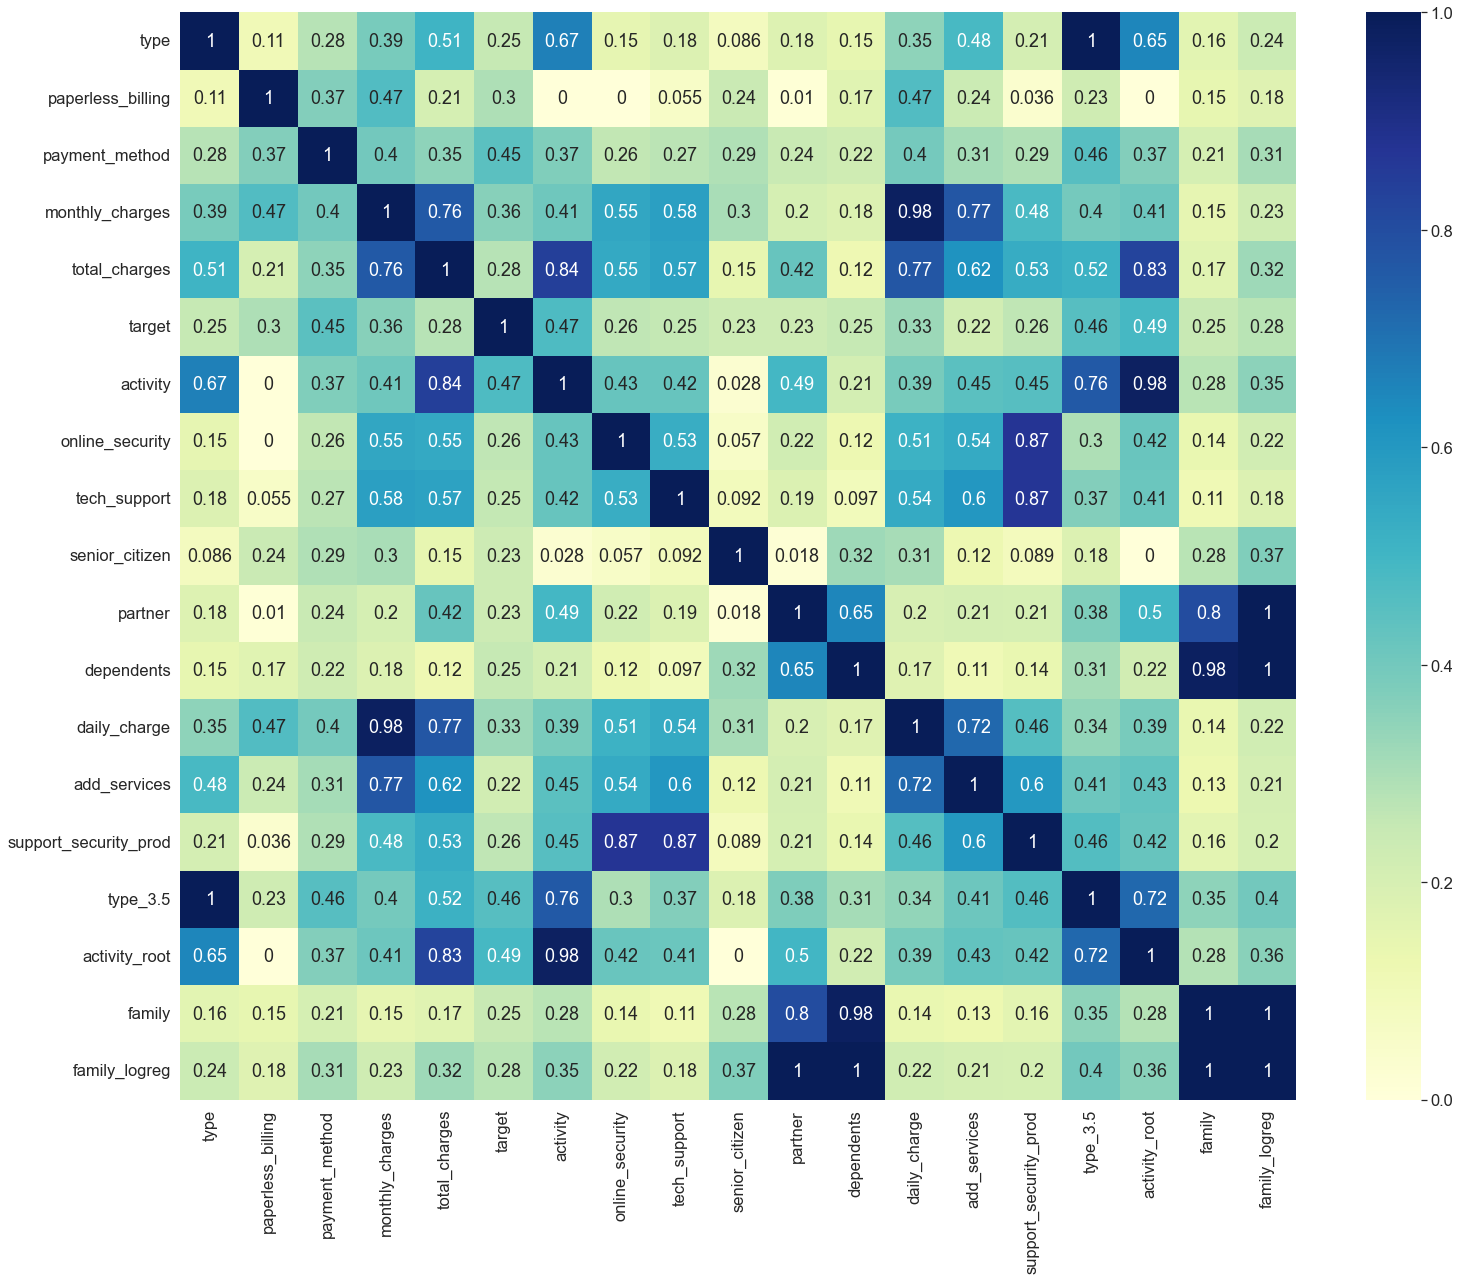

In [113]:
phik_df = work_df.copy(deep=True)
phik_df = phik_df.drop(columns=weak_features)
heatmap(phik_df)

Практически коллинеарны:
- type и type 3.5 - уберем type;
- monthly_charges и daily_charges - уберем daily_charges;
- activity и activity_root - уберем activity;
- family_logreg, family, partner и dependents - оставим partner и dependents;
- support_security_prod, security и support - оставим последние 2

In [114]:
collinear_features = ['type', 'daily_charge','activity','family_logreg','family','support_security_prod']
phik_df = phik_df.drop(columns=collinear_features)

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'target', 'online_security', 'tech_support', 'senior_citizen', 'partner', 'dependents', 'add_services', 'type_3.5', 'activity_root']


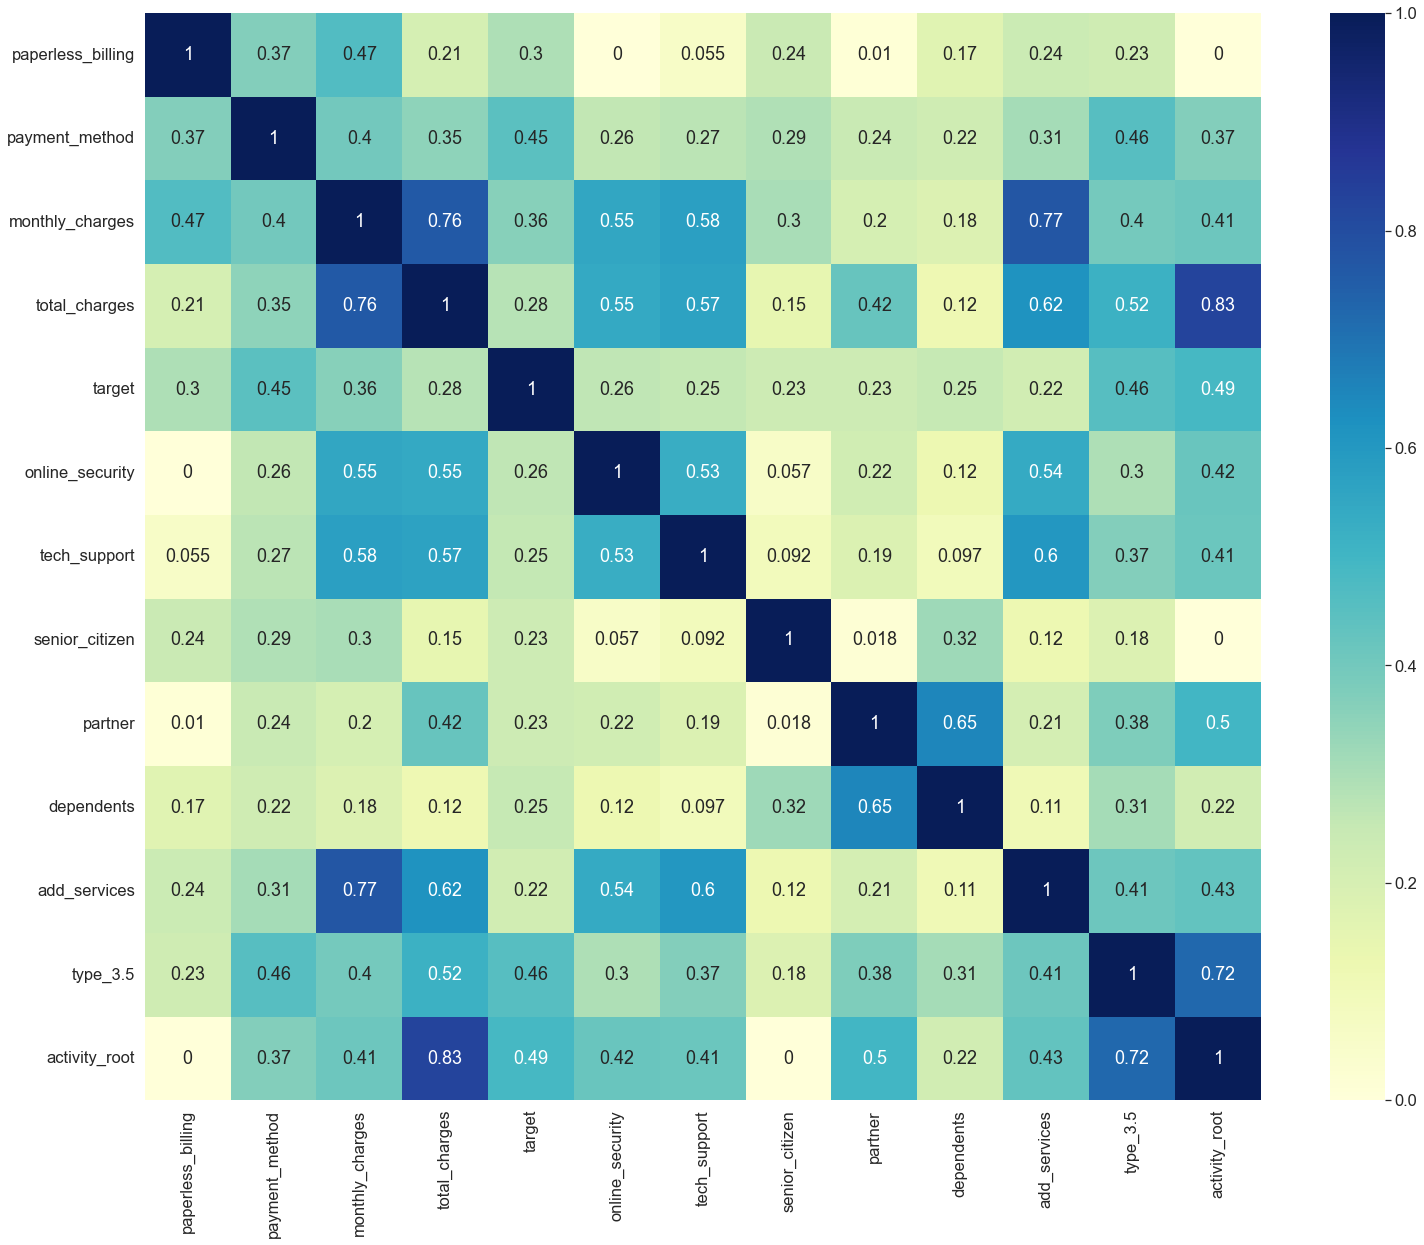

In [115]:
heatmap(phik_df)

## Обучение моделей

Мы будем обучать 3 модели:
1. Логистическую регрессию - простой математический алгоритм
2. CatBoostClassifier - отличный классификатор, использующий градиентный бустинг
3. Нейросеть

In [175]:
base_features, base_target = base_df.drop(columns='target'), base_df.target
sfs_features, sfs_target = sfs_df.drop(columns='target'), sfs_df.target
phik_features, phik_target = phik_df.drop(columns='target'), phik_df.target

In [176]:
base_x_train, base_x_test, sfs_x_train, sfs_x_test, \
        phik_x_train, phik_x_test, base_y_train, base_y_test, \
        sfs_y_train, sfs_y_test, phik_y_train, phik_y_test = train_test_split(base_features, sfs_features, phik_features, 
                                                                              base_target, sfs_target, phik_target, 
                                                                              test_size=.25, random_state=300123, stratify = base_target)

### Логистическая регрессия

In [177]:
def make_transformer(features):
    ohe_cols = features.select_dtypes(include='object').columns.tolist()
    scaler_cols = features.select_dtypes(include=np.number).columns.tolist()
    
    return ColumnTransformerWithNames([('ohe',OneHotEncoder(handle_unknown='ignore'),ohe_cols),
                                      ('scaler',StandardScaler(),scaler_cols)], remainder='passthrough')
    

In [178]:
def roc(answers, predictions_proba):
    fpr, tpr, thresholds = roc_curve(answers, predictions_proba)
    roc_res = pd.DataFrame({'tpr':tpr,'fpr':fpr,'threshold':thresholds})
    roc_res['diff'] = roc_res.tpr - roc_res.fpr
    
    x = np.linspace(0,1,10)
    y = x
    plt.figure(figsize=(7,7))
    plt.plot(roc_res.fpr, roc_res.tpr)
    plt.plot(x, y)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

    
    return roc_res

#### Логистическая регрессия на базовых фичах

In [179]:
base_transformer = make_transformer(base_x_train)

In [180]:
logreg_base_pipe = Pipeline([('transformer', base_transformer),('logreg',LogisticRegression(max_iter=1000))])
logreg_params = {'logreg__max_iter':[1000],
          'logreg__class_weight':[None,'balanced'],'logreg__random_state':[300123]}

lr_base_gscv = GridSearchCV(logreg_base_pipe, logreg_params, cv=3, verbose=10, scoring='roc_auc')

lr_base_gscv.fit(base_x_train, base_y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 1/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.834 total time=   0.0s
[CV 2/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 2/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.838 total time=   0.0s
[CV 3/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 3/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.848 total time=   0.0s
[CV 1/3; 2/2] START logreg__class_weight=balanced, logreg__max_iter=1000, logreg__random_state=300123
[CV 1/3; 2/2] END logreg__class_weight=balanced, logreg__max_iter=1000, logreg__random_state=300123;, score=0.833 total time=   0.0s
[CV 2/3; 2/2] START logre

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformerWithNames(remainder='passthrough',
                                                                   transformers=[('ohe',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['payment_method']),
                                                                                 ('scaler',
                                                                                  StandardScaler(),
                                                                                  ['paperless_billing',
                                                                                   'monthly_charges',
                                                                                   'online_security',
                                                                                   'tech_support',
                                                                                   'senior_citizen',
                                                                                   'backup_plus_protection',
                                                                                   'family_logreg',
                                                                                   'type_3.5',
                                                                                   'activity_root'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logreg__class_weight': [None, 'balanced'],
                         'logreg__max_iter': [1000],
                         'logreg__random_state': [300123]},
             scoring='roc_auc', verbose=10)

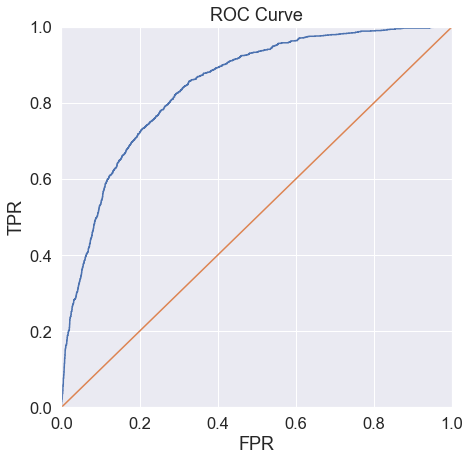

In [181]:
base_logreg_roc = roc(base_y_train, lr_base_gscv.predict_proba(base_x_train)[:,1])

In [182]:
def best_gscv_chooser(gscv_model, model_name, table=None):
    t = pd.DataFrame(gscv_model.cv_results_)
    t = t.loc[t.rank_test_score == 1, :]
    t.insert(0, 'model_name', model_name)
    
    try:
        return pd.concat([table, t], axis=0)
    except:
        return t

In [183]:
models_results = best_gscv_chooser(lr_base_gscv, 'base features LR')
models_results

model_name  mean_fit_time  std_fit_time  mean_score_time  \
0  base features LR       0.016289      0.001243          0.00582   

   std_score_time param_logreg__class_weight param_logreg__max_iter  \
0        0.000624                       None                   1000   

  param_logreg__random_state  \
0                     300123   

                                              params  split0_test_score  \
0  {'logreg__class_weight': None, 'logreg__max_it...           0.833622   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.837612           0.847782         0.839672        0.005961   

   rank_test_score  
0                1

#### Логистическая регрессия на SFS-фичах

In [184]:
sfs_x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 882 to 1228
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   streaming_t_v           5274 non-null   float64
 1   streaming_prod          5274 non-null   float64
 2   paperless_billing       5274 non-null   int64  
 3   online_backup           5274 non-null   float64
 4   streaming_movies        5274 non-null   float64
 5   activity_root           5274 non-null   float64
 6   family                  5274 non-null   int64  
 7   monthly_charges         5274 non-null   float64
 8   backup_protection_prod  5274 non-null   float64
 9   streaming_sum           5274 non-null   float64
 10  add_prod_wo_streaming   5274 non-null   float64
 11  online_security         5274 non-null   float64
 12  activity                5274 non-null   int64  
 13  daily_charge            5274 non-null   float64
 14  backup_plus_protection  5274 non-null 

In [185]:
sfs_transformer = make_transformer(sfs_x_train)

In [186]:
logreg_sfs_pipe = Pipeline([('transformer', sfs_transformer),('logreg',LogisticRegression(max_iter=1000))])
logreg_params = {'logreg__max_iter':[1000],
          'logreg__class_weight':[None,'balanced'],'logreg__random_state':[300123]}

lr_sfs_gscv = GridSearchCV(logreg_sfs_pipe, logreg_params, cv=3, verbose=10, scoring='roc_auc')

lr_sfs_gscv.fit(sfs_x_train, sfs_y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 1/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.839 total time=   0.0s
[CV 2/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 2/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.843 total time=   0.0s
[CV 3/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 3/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.852 total time=   0.0s
[CV 1/3; 2/2] START logreg__class_weight=balanced, logreg__max_iter=1000, logreg__random_state=300123
[CV 1/3; 2/2] END logreg__class_weight=balanced, logreg__max_iter=1000, logreg__random_state=300123;, score=0.838 total time=   0.0s
[CV 2/3; 2/2] START logre

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformerWithNames(remainder='passthrough',
                                                                   transformers=[('ohe',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['payment_method']),
                                                                                 ('scaler',
                                                                                  StandardScaler(),
                                                                                  ['streaming_t_v',
                                                                                   'streaming_prod',
                                                                                   'paperless_billing',
                                                                                   'online_backup',
                                                                                   'streaming_movies',
                                                                                   'activity_root',
                                                                                   'family',
                                                                                   'monthly_charges',
                                                                                   '...
                                                                                   'add_prod_wo_streaming',
                                                                                   'online_security',
                                                                                   'activity',
                                                                                   'daily_charge',
                                                                                   'backup_plus_protection',
                                                                                   'type',
                                                                                   'internet_service',
                                                                                   'device_protection',
                                                                                   'senior_citizen',
                                                                                   'support_plus_security'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logreg__class_weight': [None, 'balanced'],
                         'logreg__max_iter': [1000],
                         'logreg__random_state': [300123]},
             scoring='roc_auc', verbose=10)

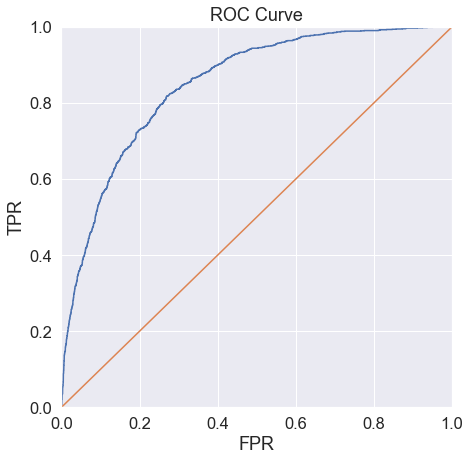

In [187]:
sfs_logreg_roc = roc(sfs_y_train, lr_sfs_gscv.predict_proba(sfs_x_train)[:,1])

In [188]:
models_results = best_gscv_chooser(lr_sfs_gscv, 'SFS features LR', table=models_results)

In [189]:
models_results

model_name  mean_fit_time  std_fit_time  mean_score_time  \
0  base features LR       0.016289      0.001243         0.005820   
0   SFS features LR       0.028258      0.001246         0.005652   

   std_score_time param_logreg__class_weight param_logreg__max_iter  \
0        0.000624                       None                   1000   
0        0.000470                       None                   1000   

  param_logreg__random_state  \
0                     300123   
0                     300123   

                                              params  split0_test_score  \
0  {'logreg__class_weight': None, 'logreg__max_it...           0.833622   
0  {'logreg__class_weight': None, 'logreg__max_it...           0.838705   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.837612           0.847782         0.839672        0.005961   
0           0.843006           0.852228         0.844647        0.005641   

   rank_test_score  
0                1  
0                1

#### Логистическая регрессия на $\phi_k$-фичах

In [190]:
phik_transformer = make_transformer(phik_x_train)

logreg_phik_pipe = Pipeline([('transformer', phik_transformer),('logreg',LogisticRegression(max_iter=1000))])


lr_phik_gscv = GridSearchCV(logreg_phik_pipe, logreg_params, cv=3, verbose=10, scoring='roc_auc')

lr_phik_gscv.fit(phik_x_train, phik_y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 1/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.834 total time=   0.0s
[CV 2/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 2/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.837 total time=   0.0s
[CV 3/3; 1/2] START logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123
[CV 3/3; 1/2] END logreg__class_weight=None, logreg__max_iter=1000, logreg__random_state=300123;, score=0.847 total time=   0.0s
[CV 1/3; 2/2] START logreg__class_weight=balanced, logreg__max_iter=1000, logreg__random_state=300123
[CV 1/3; 2/2] END logreg__class_weight=balanced, logreg__max_iter=1000, logreg__random_state=300123;, score=0.833 total time=   0.0s
[CV 2/3; 2/2] START logre

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformerWithNames(remainder='passthrough',
                                                                   transformers=[('ohe',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['payment_method']),
                                                                                 ('scaler',
                                                                                  StandardScaler(),
                                                                                  ['paperless_billing',
                                                                                   'monthly_charges',
                                                                                   'total_charges',
                                                                                   'online_security',
                                                                                   'tech_support',
                                                                                   'senior_citizen',
                                                                                   'partner',
                                                                                   'dependents',
                                                                                   'add_services',
                                                                                   'type_3.5',
                                                                                   'activity_root'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logreg__class_weight': [None, 'balanced'],
                         'logreg__max_iter': [1000],
                         'logreg__random_state': [300123]},
             scoring='roc_auc', verbose=10)

In [191]:
phik_logreg_results = pd.DataFrame(lr_phik_gscv.cv_results_)
phik_logreg_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.019948      0.002153         0.005984        0.000814   
1       0.020282      0.001881         0.006650        0.000939   

  param_logreg__class_weight param_logreg__max_iter  \
0                       None                   1000   
1                   balanced                   1000   

  param_logreg__random_state  \
0                     300123   
1                     300123   

                                              params  split0_test_score  \
0  {'logreg__class_weight': None, 'logreg__max_it...           0.833661   
1  {'logreg__class_weight': 'balanced', 'logreg__...           0.832892   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.836649           0.847378         0.839229        0.005890   
1           0.836083           0.846974         0.838650        0.006029   

   rank_test_score  
0                1  
1                2

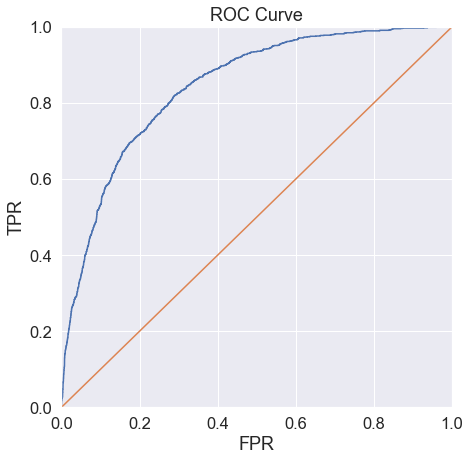

In [192]:
phik_logreg_roc = roc(phik_y_train, lr_phik_gscv.predict_proba(phik_x_train)[:,1])

In [193]:
models_results = best_gscv_chooser(lr_sfs_gscv, '$\phi_k$ features LR', table=models_results)
models_results

model_name  mean_fit_time  std_fit_time  mean_score_time  \
0      base features LR       0.016289      0.001243         0.005820   
0       SFS features LR       0.028258      0.001246         0.005652   
0  $\phi_k$ features LR       0.028258      0.001246         0.005652   

   std_score_time param_logreg__class_weight param_logreg__max_iter  \
0        0.000624                       None                   1000   
0        0.000470                       None                   1000   
0        0.000470                       None                   1000   

  param_logreg__random_state  \
0                     300123   
0                     300123   
0                     300123   

                                              params  split0_test_score  \
0  {'logreg__class_weight': None, 'logreg__max_it...           0.833622   
0  {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
0  {'logreg__class_weight': None, 'logreg__max_it...           0.838705   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.837612           0.847782         0.839672        0.005961   
0           0.843006           0.852228         0.844647        0.005641   
0           0.843006           0.852228         0.844647        0.005641   

   rank_test_score  
0                1  
0                1  
0                1

Логистическая регрессия показывает более плохие результаты на данных $\phi_k$-матрицы - неудивительно: она учитывает нелинейные связи, которые линейная регрессия учесть не может

### CatBoostClassifier

#### Базовые фичи

catboost = CatBoostClassifier(metric_period=1000, random_state=300123, early_stopping_rounds=100,cat_features=['payment_method'])


params = {'depth':[2], 
          'iterations':[i for i in range(1000,3001,250)], 
          'learning_rate':[i for i in [.1,0.15, .2, .25, 0.3]]}

In [200]:
catboost = CatBoostClassifier(metric_period=1000, random_state=300123, early_stopping_rounds=100,cat_features=['payment_method'])


params = {'depth':[2], 
          'iterations':[i for i in range(700,1301,50)], 
          'learning_rate':[i for i in [.3328, .33285]]}

In [195]:



cb_base_gscv = GridSearchCV(catboost, params, verbose=10, scoring='roc_auc', cv=3)

cb_base_gscv.fit(base_x_train, base_y_train)


Fitting 3 folds for each of 65 candidates, totalling 195 fits
[CV 1/3; 1/65] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5640551	total: 4.44ms	remaining: 3.1s
699:	learn: 0.1997850	total: 4.65s	remaining: 0us
[CV 1/3; 1/65] END depth=2, iterations=700, learning_rate=0.3328;, score=0.928 total time=   4.7s
[CV 2/3; 1/65] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5523218	total: 4.42ms	remaining: 3.09s
699:	learn: 0.2002169	total: 4.12s	remaining: 0us
[CV 2/3; 1/65] END depth=2, iterations=700, learning_rate=0.3328;, score=0.925 total time=   4.1s
[CV 3/3; 1/65] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5639309	total: 4.13ms	remaining: 2.89s
699:	learn: 0.2083873	total: 4.02s	remaining: 0us
[CV 3/3; 1/65] END depth=2, iterations=700, learning_rate=0.3328;, score=0.935 total time=   4.1s
[CV 1/3; 2/65] START depth=2, iterations=700, learning_rate=0.33285.............
0:	learn: 0.564041

749:	learn: 0.2004581	total: 4.52s	remaining: 0us
[CV 3/3; 10/65] END depth=2, iterations=750, learning_rate=0.333;, score=0.939 total time=   4.5s
[CV 1/3; 11/65] START depth=2, iterations=800, learning_rate=0.3328.............
0:	learn: 0.5640551	total: 4.28ms	remaining: 3.42s
799:	learn: 0.1913154	total: 4.69s	remaining: 0us
[CV 1/3; 11/65] END depth=2, iterations=800, learning_rate=0.3328;, score=0.929 total time=   4.7s
[CV 2/3; 11/65] START depth=2, iterations=800, learning_rate=0.3328.............
0:	learn: 0.5523218	total: 4.08ms	remaining: 3.26s
799:	learn: 0.1912257	total: 4.73s	remaining: 0us
[CV 2/3; 11/65] END depth=2, iterations=800, learning_rate=0.3328;, score=0.926 total time=   4.7s
[CV 3/3; 11/65] START depth=2, iterations=800, learning_rate=0.3328.............
0:	learn: 0.5639309	total: 4.37ms	remaining: 3.49s
799:	learn: 0.2006179	total: 4.79s	remaining: 0us
[CV 3/3; 11/65] END depth=2, iterations=800, learning_rate=0.3328;, score=0.937 total time=   4.8s
[CV 1/3; 

849:	learn: 0.1945383	total: 5.31s	remaining: 0us
[CV 3/3; 20/65] END depth=2, iterations=850, learning_rate=0.333;, score=0.940 total time=   5.3s
[CV 1/3; 21/65] START depth=2, iterations=900, learning_rate=0.3328.............
0:	learn: 0.5640551	total: 4.43ms	remaining: 3.98s
899:	learn: 0.1859572	total: 5.72s	remaining: 0us
[CV 1/3; 21/65] END depth=2, iterations=900, learning_rate=0.3328;, score=0.930 total time=   5.7s
[CV 2/3; 21/65] START depth=2, iterations=900, learning_rate=0.3328.............
0:	learn: 0.5523218	total: 4.25ms	remaining: 3.82s
899:	learn: 0.1846056	total: 5.74s	remaining: 0us
[CV 2/3; 21/65] END depth=2, iterations=900, learning_rate=0.3328;, score=0.926 total time=   5.7s
[CV 3/3; 21/65] START depth=2, iterations=900, learning_rate=0.3328.............
0:	learn: 0.5639309	total: 4.57ms	remaining: 4.11s
899:	learn: 0.1939749	total: 5.55s	remaining: 0us
[CV 3/3; 21/65] END depth=2, iterations=900, learning_rate=0.3328;, score=0.937 total time=   5.5s
[CV 1/3; 

949:	learn: 0.1875541	total: 5.91s	remaining: 0us
[CV 3/3; 30/65] END depth=2, iterations=950, learning_rate=0.333;, score=0.940 total time=   5.9s
[CV 1/3; 31/65] START depth=2, iterations=1000, learning_rate=0.3328............
0:	learn: 0.5640551	total: 4.27ms	remaining: 4.26s
999:	learn: 0.1795545	total: 6.37s	remaining: 0us
[CV 1/3; 31/65] END depth=2, iterations=1000, learning_rate=0.3328;, score=0.930 total time=   6.4s
[CV 2/3; 31/65] START depth=2, iterations=1000, learning_rate=0.3328............
0:	learn: 0.5523218	total: 4.13ms	remaining: 4.13s
999:	learn: 0.1786624	total: 6.42s	remaining: 0us
[CV 2/3; 31/65] END depth=2, iterations=1000, learning_rate=0.3328;, score=0.924 total time=   6.4s
[CV 3/3; 31/65] START depth=2, iterations=1000, learning_rate=0.3328............
0:	learn: 0.5639309	total: 4.51ms	remaining: 4.5s
999:	learn: 0.1874087	total: 6.24s	remaining: 0us
[CV 3/3; 31/65] END depth=2, iterations=1000, learning_rate=0.3328;, score=0.937 total time=   6.2s
[CV 1/3

1000:	learn: 0.1865908	total: 6.06s	remaining: 297ms
1049:	learn: 0.1839599	total: 6.35s	remaining: 0us
[CV 3/3; 39/65] END depth=2, iterations=1050, learning_rate=0.33295;, score=0.940 total time=   6.3s
[CV 1/3; 40/65] START depth=2, iterations=1050, learning_rate=0.333.............
0:	learn: 0.5640006	total: 4.16ms	remaining: 4.36s
1000:	learn: 0.1835694	total: 6.05s	remaining: 296ms
1049:	learn: 0.1817938	total: 6.34s	remaining: 0us
[CV 1/3; 40/65] END depth=2, iterations=1050, learning_rate=0.333;, score=0.930 total time=   6.3s
[CV 2/3; 40/65] START depth=2, iterations=1050, learning_rate=0.333.............
0:	learn: 0.5522646	total: 4.32ms	remaining: 4.53s
1000:	learn: 0.1801689	total: 6.19s	remaining: 303ms
1049:	learn: 0.1770308	total: 6.51s	remaining: 0us
[CV 2/3; 40/65] END depth=2, iterations=1050, learning_rate=0.333;, score=0.923 total time=   6.5s
[CV 3/3; 40/65] START depth=2, iterations=1050, learning_rate=0.333.............
0:	learn: 0.5638762	total: 5.23ms	remaining:

1000:	learn: 0.1822410	total: 5.99s	remaining: 891ms
1149:	learn: 0.1749002	total: 6.88s	remaining: 0us
[CV 1/3; 48/65] END depth=2, iterations=1150, learning_rate=0.3329;, score=0.930 total time=   7.0s
[CV 2/3; 48/65] START depth=2, iterations=1150, learning_rate=0.3329............
0:	learn: 0.5522932	total: 4.47ms	remaining: 5.14s
1000:	learn: 0.1822581	total: 6.03s	remaining: 898ms
1149:	learn: 0.1749310	total: 6.89s	remaining: 0us
[CV 2/3; 48/65] END depth=2, iterations=1150, learning_rate=0.3329;, score=0.922 total time=   6.9s
[CV 3/3; 48/65] START depth=2, iterations=1150, learning_rate=0.3329............
0:	learn: 0.5639036	total: 4.25ms	remaining: 4.89s
1000:	learn: 0.1869591	total: 5.88s	remaining: 875ms
1149:	learn: 0.1794532	total: 6.75s	remaining: 0us
[CV 3/3; 48/65] END depth=2, iterations=1150, learning_rate=0.3329;, score=0.937 total time=   6.8s
[CV 1/3; 49/65] START depth=2, iterations=1150, learning_rate=0.33295...........
0:	learn: 0.5640142	total: 3.96ms	remaining

1000:	learn: 0.1785320	total: 5.95s	remaining: 1.48s
1249:	learn: 0.1668542	total: 7.38s	remaining: 0us
[CV 2/3; 56/65] END depth=2, iterations=1250, learning_rate=0.3328;, score=0.924 total time=   7.4s
[CV 3/3; 56/65] START depth=2, iterations=1250, learning_rate=0.3328............
0:	learn: 0.5639309	total: 4.35ms	remaining: 5.43s
1000:	learn: 0.1872015	total: 5.89s	remaining: 1.46s
1249:	learn: 0.1758390	total: 7.37s	remaining: 0us
[CV 3/3; 56/65] END depth=2, iterations=1250, learning_rate=0.3328;, score=0.936 total time=   7.4s
[CV 1/3; 57/65] START depth=2, iterations=1250, learning_rate=0.33285...........
0:	learn: 0.5640415	total: 3.94ms	remaining: 4.93s
1000:	learn: 0.1828897	total: 5.99s	remaining: 1.49s
1249:	learn: 0.1718475	total: 7.46s	remaining: 0us
[CV 1/3; 57/65] END depth=2, iterations=1250, learning_rate=0.33285;, score=0.926 total time=   7.5s
[CV 2/3; 57/65] START depth=2, iterations=1250, learning_rate=0.33285...........
0:	learn: 0.5523075	total: 4.07ms	remainin

1000:	learn: 0.1865908	total: 6.37s	remaining: 1.9s
1299:	learn: 0.1724030	total: 8.24s	remaining: 0us
[CV 3/3; 64/65] END depth=2, iterations=1300, learning_rate=0.33295;, score=0.939 total time=   8.3s
[CV 1/3; 65/65] START depth=2, iterations=1300, learning_rate=0.333.............
0:	learn: 0.5640006	total: 4.39ms	remaining: 5.7s
1000:	learn: 0.1835694	total: 6.38s	remaining: 1.91s
1299:	learn: 0.1703250	total: 8.23s	remaining: 0us
[CV 1/3; 65/65] END depth=2, iterations=1300, learning_rate=0.333;, score=0.927 total time=   8.2s
[CV 2/3; 65/65] START depth=2, iterations=1300, learning_rate=0.333.............
0:	learn: 0.5522646	total: 4.16ms	remaining: 5.4s
1000:	learn: 0.1801689	total: 6.3s	remaining: 1.88s
1299:	learn: 0.1649381	total: 8.23s	remaining: 0us
[CV 2/3; 65/65] END depth=2, iterations=1300, learning_rate=0.333;, score=0.923 total time=   8.3s
[CV 3/3; 65/65] START depth=2, iterations=1300, learning_rate=0.333.............
0:	learn: 0.5638762	total: 4.58ms	remaining: 5.9

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020358676B80>,
             param_grid={'depth': [2],
                         'iterations': [700, 750, 800, 850, 900, 950, 1000,
                                        1050, 1100, 1150, 1200, 1250, 1300],
                         'learning_rate': [0.3328, 0.33285, 0.3329, 0.33295,
                                           0.333]},
             scoring='roc_auc', verbose=10)

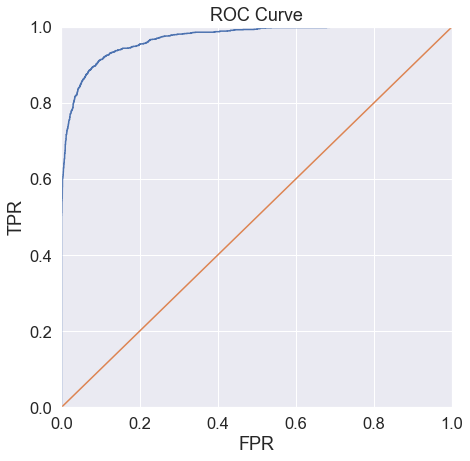

In [196]:
base_cb_roc = roc(base_y_train, cb_base_gscv.predict_proba(base_x_train)[:,1])

In [197]:
models_results = best_gscv_chooser(cb_base_gscv, 'base features CatBoost', table=models_results)
models_results

model_name  mean_fit_time  std_fit_time  mean_score_time  \
0         base features LR       0.016289      0.001243         0.005820   
0          SFS features LR       0.028258      0.001246         0.005652   
0     $\phi_k$ features LR       0.028258      0.001246         0.005652   
20  base features CatBoost       5.735991      0.082313         0.003325   

    std_score_time param_logreg__class_weight param_logreg__max_iter  \
0         0.000624                       None                   1000   
0         0.000470                       None                   1000   
0         0.000470                       None                   1000   
20        0.000470                        NaN                    NaN   

   param_logreg__random_state  \
0                      300123   
0                      300123   
0                      300123   
20                        NaN   

                                               params  split0_test_score  \
0   {'logreg__class_weight': None, 'logreg__max_it...           0.833622   
0   {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
0   {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
20  {'depth': 2, 'iterations': 900, 'learning_rate...           0.929699   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.837612           0.847782         0.839672        0.005961   
0            0.843006           0.852228         0.844647        0.005641   
0            0.843006           0.852228         0.844647        0.005641   
20           0.926292           0.937228         0.931073        0.004569   

    rank_test_score param_depth param_iterations param_learning_rate  
0                 1         NaN              NaN                 NaN  
0                 1         NaN              NaN                 NaN  
0                 1         NaN              NaN                 NaN  
20                1           2              900              0.3328

In [198]:
pd.DataFrame(cb_base_gscv.cv_results_).sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_depth  \
20       5.735991      0.082313         0.003325        0.000470           2   
9        4.570068      0.085886         0.003323        0.000469           2   
10       4.818572      0.036909         0.003671        0.000480           2   
33       6.298845      0.073928         0.004321        0.000471           2   
38       6.478257      0.083862         0.004322        0.000470           2   
48       7.253534      0.137436         0.004003        0.000020           2   
14       4.822061      0.039910         0.003885        0.000148           2   
4        4.365862      0.235548         0.003234        0.000342           2   
15       5.240791      0.095508         0.003657        0.000940           2   
24       5.865849      0.139642         0.003324        0.000470           2   

   param_iterations param_learning_rate  \
20              900              0.3328   
9               750               0.333   
10              800              0.3328   
33             1000             0.33295   
38             1050             0.33295   
48             1150             0.33295   
14              800               0.333   
4               700               0.333   
15              850              0.3328   
24              900               0.333   

                                               params  split0_test_score  \
20  {'depth': 2, 'iterations': 900, 'learning_rate...           0.929699   
9   {'depth': 2, 'iterations': 750, 'learning_rate...           0.929690   
10  {'depth': 2, 'iterations': 800, 'learning_rate...           0.929254   
33  {'depth': 2, 'iterations': 1000, 'learning_rat...           0.928922   
38  {'depth': 2, 'iterations': 1050, 'learning_rat...           0.928581   
48  {'depth': 2, 'iterations': 1150, 'learning_rat...           0.927294   
14  {'depth': 2, 'iterations': 800, 'learning_rate...           0.929518   
4   {'depth': 2, 'iterations': 700, 'learning_rate...           0.928642   
15  {'depth': 2, 'iterations': 850, 'learning_rate...           0.929000   
24  {'depth': 2, 'iterations': 900, 'learning_rate...           0.930180   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
20           0.926292           0.937228         0.931073        0.004569   
9            0.924102           0.939374         0.931056        0.006309   
10           0.926458           0.936923         0.930878        0.004424   
33           0.924074           0.939601         0.930866        0.006486   
38           0.923533           0.940110         0.930741        0.006938   
48           0.924864           0.940063         0.930740        0.006666   
14           0.923027           0.939638         0.930728        0.006835   
4            0.923851           0.939659         0.930717        0.006618   
15           0.926449           0.936678         0.930709        0.004347   
24           0.921198           0.940532         0.930637        0.007900   

    rank_test_score  
20                1  
9                 2  
10                3  
33                4  
38                5  
48                6  
14                7  
4                 8  
15                9  
24               10

#### Фичи от SFS

In [201]:

cb_sfs_gscv = GridSearchCV(catboost, params, verbose=10, scoring='roc_auc', cv=3)


cb_sfs_gscv.fit(sfs_x_train, sfs_y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits
[CV 1/3; 1/26] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5512340	total: 4.62ms	remaining: 3.23s
699:	learn: 0.1942733	total: 4.43s	remaining: 0us
[CV 1/3; 1/26] END depth=2, iterations=700, learning_rate=0.3328;, score=0.918 total time=   4.4s
[CV 2/3; 1/26] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5586940	total: 4.35ms	remaining: 3.04s
699:	learn: 0.1903109	total: 4.68s	remaining: 0us
[CV 2/3; 1/26] END depth=2, iterations=700, learning_rate=0.3328;, score=0.913 total time=   4.7s
[CV 3/3; 1/26] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5616369	total: 4.56ms	remaining: 3.19s
699:	learn: 0.1966095	total: 4.51s	remaining: 0us
[CV 3/3; 1/26] END depth=2, iterations=700, learning_rate=0.3328;, score=0.918 total time=   4.5s
[CV 1/3; 2/26] START depth=2, iterations=700, learning_rate=0.33285.............
0:	learn: 0.551219

899:	learn: 0.1783349	total: 5.18s	remaining: 0us
[CV 3/3; 10/26] END depth=2, iterations=900, learning_rate=0.33285;, score=0.921 total time=   5.2s
[CV 1/3; 11/26] START depth=2, iterations=950, learning_rate=0.3328.............
0:	learn: 0.5512340	total: 4.29ms	remaining: 4.07s
949:	learn: 0.1721198	total: 5.54s	remaining: 0us
[CV 1/3; 11/26] END depth=2, iterations=950, learning_rate=0.3328;, score=0.919 total time=   5.5s
[CV 2/3; 11/26] START depth=2, iterations=950, learning_rate=0.3328.............
0:	learn: 0.5586940	total: 4.06ms	remaining: 3.85s
949:	learn: 0.1704531	total: 5.51s	remaining: 0us
[CV 2/3; 11/26] END depth=2, iterations=950, learning_rate=0.3328;, score=0.912 total time=   5.5s
[CV 3/3; 11/26] START depth=2, iterations=950, learning_rate=0.3328.............
0:	learn: 0.5616369	total: 4.41ms	remaining: 4.19s
949:	learn: 0.1754181	total: 5.56s	remaining: 0us
[CV 3/3; 11/26] END depth=2, iterations=950, learning_rate=0.3328;, score=0.923 total time=   5.6s
[CV 1/3

1000:	learn: 0.1726550	total: 6.29s	remaining: 936ms
1149:	learn: 0.1632272	total: 7.2s	remaining: 0us
[CV 3/3; 19/26] END depth=2, iterations=1150, learning_rate=0.3328;, score=0.922 total time=   7.2s
[CV 1/3; 20/26] START depth=2, iterations=1150, learning_rate=0.33285...........
0:	learn: 0.5512195	total: 4.24ms	remaining: 4.87s
1000:	learn: 0.1658175	total: 5.93s	remaining: 883ms
1149:	learn: 0.1571786	total: 6.8s	remaining: 0us
[CV 1/3; 20/26] END depth=2, iterations=1150, learning_rate=0.33285;, score=0.917 total time=   6.9s
[CV 2/3; 20/26] START depth=2, iterations=1150, learning_rate=0.33285...........
0:	learn: 0.5586798	total: 4.14ms	remaining: 4.75s
1000:	learn: 0.1695274	total: 5.71s	remaining: 850ms
1149:	learn: 0.1582883	total: 6.54s	remaining: 0us
[CV 2/3; 20/26] END depth=2, iterations=1150, learning_rate=0.33285;, score=0.918 total time=   6.6s
[CV 3/3; 20/26] START depth=2, iterations=1150, learning_rate=0.33285...........
0:	learn: 0.5616229	total: 4.27ms	remaining

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020358FC3CA0>,
             param_grid={'depth': [2],
                         'iterations': [700, 750, 800, 850, 900, 950, 1000,
                                        1050, 1100, 1150, 1200, 1250, 1300],
                         'learning_rate': [0.3328, 0.33285]},
             scoring='roc_auc', verbose=10)

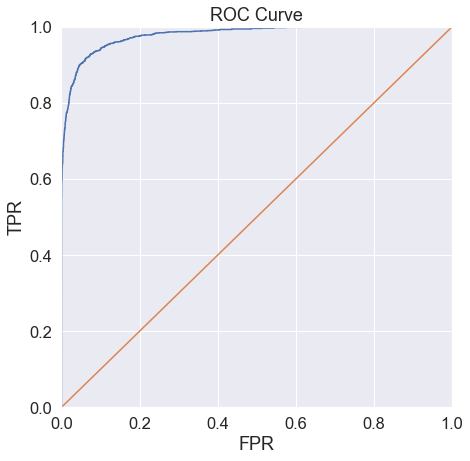

In [202]:
sfs_cb_roc = roc(sfs_y_train, cb_sfs_gscv.predict_proba(sfs_x_train)[:,1])

In [203]:
models_results = best_gscv_chooser(cb_sfs_gscv, 'SFS features CatBoost', table=models_results)
models_results

model_name  mean_fit_time  std_fit_time  mean_score_time  \
0         base features LR       0.016289      0.001243         0.005820   
0          SFS features LR       0.028258      0.001246         0.005652   
0     $\phi_k$ features LR       0.028258      0.001246         0.005652   
20  base features CatBoost       5.735991      0.082313         0.003325   
21   SFS features CatBoost       7.283525      0.122230         0.003989   

    std_score_time param_logreg__class_weight param_logreg__max_iter  \
0     6.244181e-04                       None                   1000   
0     4.701911e-04                       None                   1000   
0     4.701911e-04                       None                   1000   
20    4.701905e-04                        NaN                    NaN   
21    2.973602e-07                        NaN                    NaN   

   param_logreg__random_state  \
0                      300123   
0                      300123   
0                      300123   
20                        NaN   
21                        NaN   

                                               params  split0_test_score  \
0   {'logreg__class_weight': None, 'logreg__max_it...           0.833622   
0   {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
0   {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
20  {'depth': 2, 'iterations': 900, 'learning_rate...           0.929699   
21  {'depth': 2, 'iterations': 1200, 'learning_rat...           0.917229   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.837612           0.847782         0.839672        0.005961   
0            0.843006           0.852228         0.844647        0.005641   
0            0.843006           0.852228         0.844647        0.005641   
20           0.926292           0.937228         0.931073        0.004569   
21           0.918296           0.921873         0.919133        0.001986   

    rank_test_score param_depth param_iterations param_learning_rate  
0                 1         NaN              NaN                 NaN  
0                 1         NaN              NaN                 NaN  
0                 1         NaN              NaN                 NaN  
20                1           2              900              0.3328  
21                1           2             1200             0.33285

#### Фичи от $\phi_k$

In [204]:

cb_phik_gscv = GridSearchCV(catboost, params, verbose=10, scoring='roc_auc', cv=3)


cb_phik_gscv.fit(phik_x_train, phik_y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits
[CV 1/3; 1/26] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5623143	total: 4.55ms	remaining: 3.18s
699:	learn: 0.2000009	total: 4.22s	remaining: 0us
[CV 1/3; 1/26] END depth=2, iterations=700, learning_rate=0.3328;, score=0.911 total time=   4.2s
[CV 2/3; 1/26] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5582158	total: 4.33ms	remaining: 3.03s
699:	learn: 0.1972094	total: 4.32s	remaining: 0us
[CV 2/3; 1/26] END depth=2, iterations=700, learning_rate=0.3328;, score=0.913 total time=   4.3s
[CV 3/3; 1/26] START depth=2, iterations=700, learning_rate=0.3328..............
0:	learn: 0.5612196	total: 3.98ms	remaining: 2.78s
699:	learn: 0.2061192	total: 4.36s	remaining: 0us
[CV 3/3; 1/26] END depth=2, iterations=700, learning_rate=0.3328;, score=0.924 total time=   4.3s
[CV 1/3; 2/26] START depth=2, iterations=700, learning_rate=0.33285.............
0:	learn: 0.562300

899:	learn: 0.1894223	total: 5.54s	remaining: 0us
[CV 3/3; 10/26] END depth=2, iterations=900, learning_rate=0.33285;, score=0.922 total time=   5.5s
[CV 1/3; 11/26] START depth=2, iterations=950, learning_rate=0.3328.............
0:	learn: 0.5623143	total: 4.11ms	remaining: 3.9s
949:	learn: 0.1766816	total: 5.79s	remaining: 0us
[CV 1/3; 11/26] END depth=2, iterations=950, learning_rate=0.3328;, score=0.916 total time=   5.8s
[CV 2/3; 11/26] START depth=2, iterations=950, learning_rate=0.3328.............
0:	learn: 0.5582158	total: 4.89ms	remaining: 4.64s
949:	learn: 0.1749787	total: 5.92s	remaining: 0us
[CV 2/3; 11/26] END depth=2, iterations=950, learning_rate=0.3328;, score=0.914 total time=   5.9s
[CV 3/3; 11/26] START depth=2, iterations=950, learning_rate=0.3328.............
0:	learn: 0.5612196	total: 4.68ms	remaining: 4.44s
949:	learn: 0.1860227	total: 5.91s	remaining: 0us
[CV 3/3; 11/26] END depth=2, iterations=950, learning_rate=0.3328;, score=0.925 total time=   5.9s
[CV 1/3;

1000:	learn: 0.1832213	total: 6.34s	remaining: 944ms
1149:	learn: 0.1730572	total: 7.25s	remaining: 0us
[CV 3/3; 19/26] END depth=2, iterations=1150, learning_rate=0.3328;, score=0.925 total time=   7.2s
[CV 1/3; 20/26] START depth=2, iterations=1150, learning_rate=0.33285...........
0:	learn: 0.5623003	total: 4.16ms	remaining: 4.78s
1000:	learn: 0.1748646	total: 5.91s	remaining: 880ms
1149:	learn: 0.1651923	total: 6.84s	remaining: 0us
[CV 1/3; 20/26] END depth=2, iterations=1150, learning_rate=0.33285;, score=0.911 total time=   6.8s
[CV 2/3; 20/26] START depth=2, iterations=1150, learning_rate=0.33285...........
0:	learn: 0.5582015	total: 4.15ms	remaining: 4.76s
1000:	learn: 0.1740847	total: 5.99s	remaining: 891ms
1149:	learn: 0.1648323	total: 6.87s	remaining: 0us
[CV 2/3; 20/26] END depth=2, iterations=1150, learning_rate=0.33285;, score=0.913 total time=   6.9s
[CV 3/3; 20/26] START depth=2, iterations=1150, learning_rate=0.33285...........
0:	learn: 0.5612056	total: 4.19ms	remaini

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020358FC3CA0>,
             param_grid={'depth': [2],
                         'iterations': [700, 750, 800, 850, 900, 950, 1000,
                                        1050, 1100, 1150, 1200, 1250, 1300],
                         'learning_rate': [0.3328, 0.33285]},
             scoring='roc_auc', verbose=10)

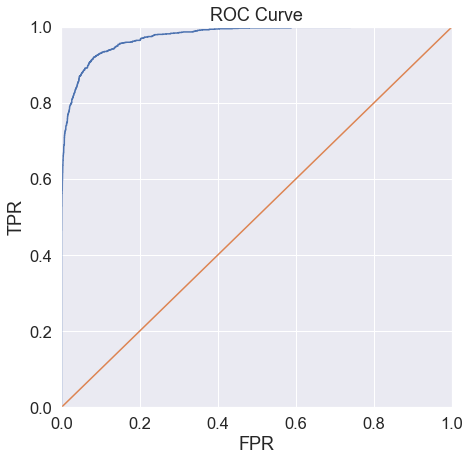

In [205]:
phik_cb_roc = roc(phik_y_train, cb_phik_gscv.predict_proba(phik_x_train)[:,1])

In [206]:
models_results = best_gscv_chooser(cb_phik_gscv, '$\phi_k$ features CatBoost', table=models_results)
models_results

model_name  mean_fit_time  std_fit_time  mean_score_time  \
0             base features LR       0.016289      0.001243         0.005820   
0              SFS features LR       0.028258      0.001246         0.005652   
0         $\phi_k$ features LR       0.028258      0.001246         0.005652   
20      base features CatBoost       5.735991      0.082313         0.003325   
21       SFS features CatBoost       7.283525      0.122230         0.003989   
14  $\phi_k$ features CatBoost       6.477538      0.079112         0.003990   

    std_score_time param_logreg__class_weight param_logreg__max_iter  \
0     6.244181e-04                       None                   1000   
0     4.701911e-04                       None                   1000   
0     4.701911e-04                       None                   1000   
20    4.701905e-04                        NaN                    NaN   
21    2.973602e-07                        NaN                    NaN   
14    5.947204e-07                        NaN                    NaN   

   param_logreg__random_state  \
0                      300123   
0                      300123   
0                      300123   
20                        NaN   
21                        NaN   
14                        NaN   

                                               params  split0_test_score  \
0   {'logreg__class_weight': None, 'logreg__max_it...           0.833622   
0   {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
0   {'logreg__class_weight': None, 'logreg__max_it...           0.838705   
20  {'depth': 2, 'iterations': 900, 'learning_rate...           0.929699   
21  {'depth': 2, 'iterations': 1200, 'learning_rat...           0.917229   
14  {'depth': 2, 'iterations': 1050, 'learning_rat...           0.916078   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.837612           0.847782         0.839672        0.005961   
0            0.843006           0.852228         0.844647        0.005641   
0            0.843006           0.852228         0.844647        0.005641   
20           0.926292           0.937228         0.931073        0.004569   
21           0.918296           0.921873         0.919133        0.001986   
14           0.914165           0.925658         0.918634        0.005028   

    rank_test_score param_depth param_iterations param_learning_rate  
0                 1         NaN              NaN                 NaN  
0                 1         NaN              NaN                 NaN  
0                 1         NaN              NaN                 NaN  
20                1           2              900              0.3328  
21                1           2             1200             0.33285  
14                1           2             1050              0.3328

### Нейросеть

Будем использовать обычную, полносвязную нейросеть:
- количество слоёв: 5 слоёв будет вполне достаточно;
- количество нейронов: начнем с 64 нейронов и будем уменьшать их кол-во на каждом слое в 2 раза; на последнем слое будет 2 нейрона + softmax;
- количество эпох установим в размере 100

Для начала - зафиксируем random state:

In [207]:
def random_stater(n):
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    random.seed(n)
    np.random.seed(n)
    tf.random.set_seed(n)


#### Нейросеть с базовыми фичами

In [208]:
roc_metric = keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

In [209]:
random_stater(300123)

base_nn = keras.models.Sequential()


base_nn.add(keras.layers.Dense(units=256, input_dim = base_transformer.fit_transform(base_x_train).shape[1], activation='relu'))
base_nn.add(keras.layers.Dense(units=128, activation='relu'))
base_nn.add(keras.layers.Dense(units=16, activation='relu'))
base_nn.add(keras.layers.Dense(units=8, activation='relu'))
base_nn.add(keras.layers.Dense(units=1, activation='sigmoid'))


base_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[roc_metric])

In [242]:
base_nn.fit(base_transformer.fit_transform(base_x_train), base_y_train, validation_split=.2, epochs=50, verbose=2)

Epoch 1/50
132/132 - 0s - loss: 0.4023 - auc_1: 0.8523 - val_loss: 0.4687 - val_auc_1: 0.8259 - 351ms/epoch - 3ms/step
Epoch 2/50
132/132 - 0s - loss: 0.4006 - auc_1: 0.8542 - val_loss: 0.4780 - val_auc_1: 0.8243 - 157ms/epoch - 1ms/step
Epoch 3/50
132/132 - 0s - loss: 0.3976 - auc_1: 0.8571 - val_loss: 0.4645 - val_auc_1: 0.8268 - 153ms/epoch - 1ms/step
Epoch 4/50
132/132 - 0s - loss: 0.3947 - auc_1: 0.8599 - val_loss: 0.4765 - val_auc_1: 0.8147 - 148ms/epoch - 1ms/step
Epoch 5/50
132/132 - 0s - loss: 0.3954 - auc_1: 0.8585 - val_loss: 0.4864 - val_auc_1: 0.8188 - 147ms/epoch - 1ms/step
Epoch 6/50
132/132 - 0s - loss: 0.3931 - auc_1: 0.8608 - val_loss: 0.4871 - val_auc_1: 0.8168 - 154ms/epoch - 1ms/step
Epoch 7/50
132/132 - 0s - loss: 0.3876 - auc_1: 0.8647 - val_loss: 0.4730 - val_auc_1: 0.8153 - 148ms/epoch - 1ms/step
Epoch 8/50
132/132 - 0s - loss: 0.3854 - auc_1: 0.8665 - val_loss: 0.4863 - val_auc_1: 0.8152 - 162ms/epoch - 1ms/step
Epoch 9/50
132/132 - 0s - loss: 0.3842 - auc_1: 

In [211]:
print('ROC-AUC')
print(roc_auc_score(base_y_train, base_nn.predict(base_transformer.fit_transform(base_x_train))))

ROC-AUC
165/165 [==============================] - 0s 602us/step
0.8527722166385684


165/165 [==============================] - 0s 596us/step


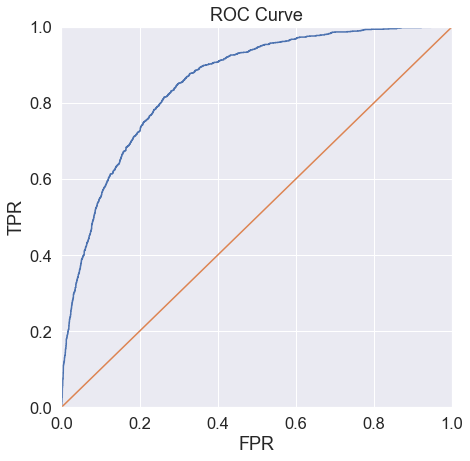

In [212]:
base_nn_roc = roc(base_y_train, base_nn.predict(base_transformer.fit_transform(base_x_train)))

#### Нейросеть с SFS-фичами

In [213]:
random_stater(300123)

sfs_nn = keras.models.Sequential()


sfs_nn.add(keras.layers.Dense(units=256, input_dim = sfs_transformer.fit_transform(sfs_x_train).shape[1], activation='relu'))
sfs_nn.add(keras.layers.Dense(units=128, activation='relu'))
sfs_nn.add(keras.layers.Dense(units=16, activation='relu'))
sfs_nn.add(keras.layers.Dense(units=8, activation='relu'))
sfs_nn.add(keras.layers.Dense(units=1, activation='sigmoid'))


sfs_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[roc_metric])

In [214]:
sfs_nn.fit(sfs_transformer.fit_transform(sfs_x_train), sfs_y_train, validation_split=.2, epochs=5, verbose=2)

Epoch 1/5
132/132 - 1s - loss: 0.4548 - auc_1: 0.8021 - val_loss: 0.4515 - val_auc_1: 0.8387 - 942ms/epoch - 7ms/step
Epoch 2/5
132/132 - 0s - loss: 0.4104 - auc_1: 0.8462 - val_loss: 0.4551 - val_auc_1: 0.8354 - 148ms/epoch - 1ms/step
Epoch 3/5
132/132 - 0s - loss: 0.4009 - auc_1: 0.8541 - val_loss: 0.4544 - val_auc_1: 0.8327 - 149ms/epoch - 1ms/step
Epoch 4/5
132/132 - 0s - loss: 0.3983 - auc_1: 0.8569 - val_loss: 0.4643 - val_auc_1: 0.8260 - 150ms/epoch - 1ms/step
Epoch 5/5
132/132 - 0s - loss: 0.3947 - auc_1: 0.8585 - val_loss: 0.4723 - val_auc_1: 0.8269 - 148ms/epoch - 1ms/step


In [215]:
print('ROC-AUC')
print(roc_auc_score(sfs_y_train, sfs_nn.predict(sfs_transformer.fit_transform(sfs_x_train))))

ROC-AUC
165/165 [==============================] - 0s 687us/step
0.8612318514872495


165/165 [==============================] - 0s 593us/step


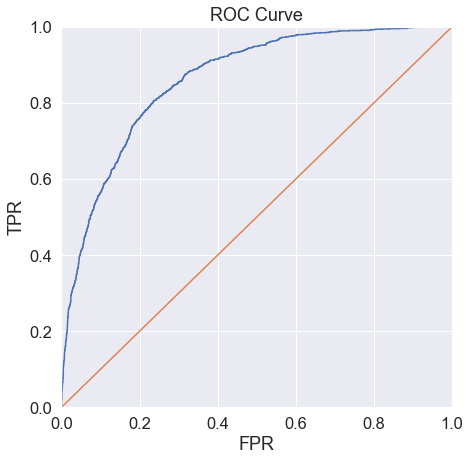

In [216]:
sfs_nn_roc = roc(sfs_y_train, sfs_nn.predict(sfs_transformer.fit_transform(sfs_x_train)))

#### Нейросеть с $\phi_k$ фичами

In [217]:
random_stater(300123)

phik_nn = keras.models.Sequential()


phik_nn.add(keras.layers.Dense(units=256, input_dim = phik_transformer.fit_transform(phik_x_train).shape[1], 
                               activation='relu'))
phik_nn.add(keras.layers.Dense(units=128, activation='relu'))
phik_nn.add(keras.layers.Dense(units=16, activation='relu'))
phik_nn.add(keras.layers.Dense(units=8, activation='relu'))
phik_nn.add(keras.layers.Dense(units=1, activation='sigmoid'))


phik_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[roc_metric])


In [218]:
phik_nn.fit(phik_transformer.fit_transform(phik_x_train), phik_y_train, validation_split=.2, epochs=10, verbose=2)

Epoch 1/10
132/132 - 1s - loss: 0.4608 - auc_1: 0.7978 - val_loss: 0.4588 - val_auc_1: 0.8313 - 923ms/epoch - 7ms/step
Epoch 2/10
132/132 - 0s - loss: 0.4180 - auc_1: 0.8389 - val_loss: 0.4689 - val_auc_1: 0.8264 - 143ms/epoch - 1ms/step
Epoch 3/10
132/132 - 0s - loss: 0.4125 - auc_1: 0.8443 - val_loss: 0.4616 - val_auc_1: 0.8281 - 143ms/epoch - 1ms/step
Epoch 4/10
132/132 - 0s - loss: 0.4072 - auc_1: 0.8492 - val_loss: 0.4662 - val_auc_1: 0.8212 - 146ms/epoch - 1ms/step
Epoch 5/10
132/132 - 0s - loss: 0.4079 - auc_1: 0.8476 - val_loss: 0.4753 - val_auc_1: 0.8233 - 144ms/epoch - 1ms/step
Epoch 6/10
132/132 - 0s - loss: 0.4050 - auc_1: 0.8508 - val_loss: 0.4765 - val_auc_1: 0.8225 - 142ms/epoch - 1ms/step
Epoch 7/10
132/132 - 0s - loss: 0.3977 - auc_1: 0.8568 - val_loss: 0.4645 - val_auc_1: 0.8228 - 141ms/epoch - 1ms/step
Epoch 8/10
132/132 - 0s - loss: 0.3950 - auc_1: 0.8593 - val_loss: 0.4740 - val_auc_1: 0.8183 - 141ms/epoch - 1ms/step
Epoch 9/10
132/132 - 0s - loss: 0.3932 - auc_1: 

In [219]:
print('ROC-AUC')
print(roc_auc_score(phik_y_train, phik_nn.predict(phik_transformer.fit_transform(phik_x_train))))

ROC-AUC
165/165 [==============================] - 0s 547us/step
0.8645012364272999


165/165 [==============================] - 0s 531us/step


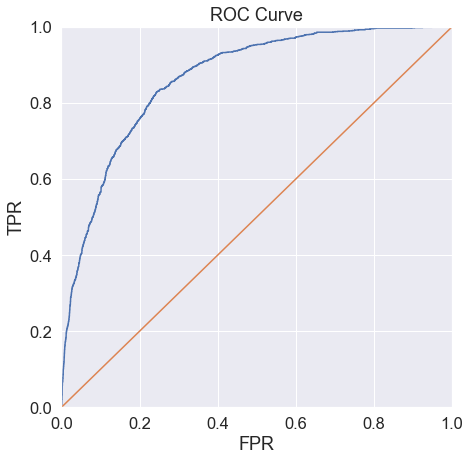

In [220]:
phik_nn_roc = roc(phik_y_train, phik_nn.predict(phik_transformer.fit_transform(phik_x_train)))

Как мы можем заметить, нейросеть в целом демонстрирует более низкие результаты, чем градиентный бустинг

## Выбор модели

Отрисуем все наши графики в одном месте и посмотрим на результаты

In [221]:
def plotter(data):
    plt.plot(data.fpr, data.tpr)

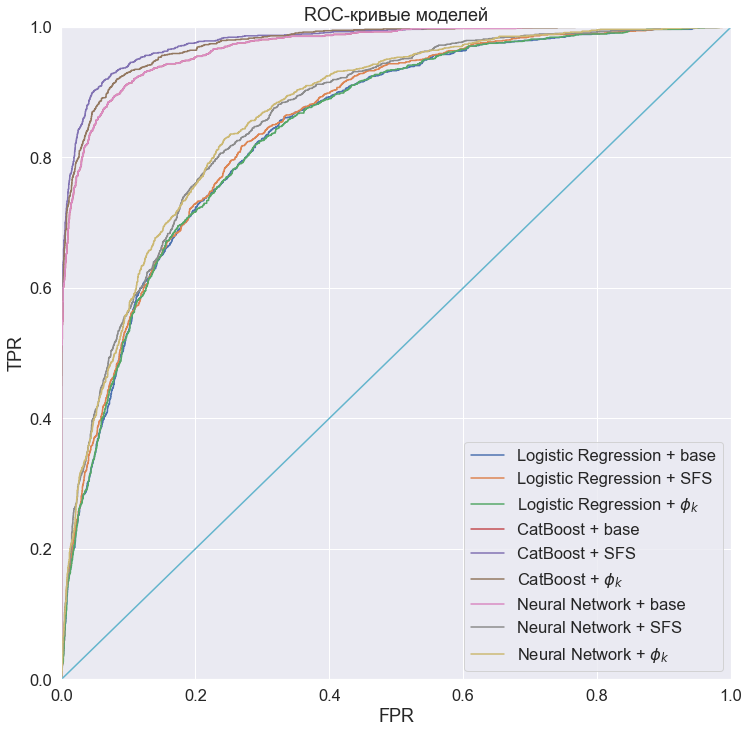

In [236]:
plt.figure(figsize=(12,12))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривые моделей')

plotter(base_logreg_roc)
plotter(sfs_logreg_roc)
plotter(phik_logreg_roc)
plotter(base_cb_roc)
plotter(sfs_cb_roc)
plotter(phik_cb_roc)
plotter(base_cb_roc)
plotter(sfs_nn_roc)
plotter(phik_nn_roc)
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10))
plt.xlim(0,1)
plt.ylim(0,1)


plt.legend(['Logistic Regression + base','Logistic Regression + SFS', 'Logistic Regression + $\phi_k$',
            'CatBoost + base','CatBoost + SFS', 'CatBoost + $\phi_k$',
           'Neural Network + base','Neural Network + SFS', 'Neural Network + $\phi_k$'])


Также посмотрим на нашу итоговую таблицу с результатами, отсортированную по среднему значению метрики:

In [223]:
models_results.sort_values(by='mean_test_score', ascending=False)[['model_name','mean_test_score']]

model_name  mean_test_score
20      base features CatBoost         0.931073
21       SFS features CatBoost         0.919133
14  $\phi_k$ features CatBoost         0.918634
0              SFS features LR         0.844647
0         $\phi_k$ features LR         0.844647
0             base features LR         0.839672

И мы выбираем модель с наилучшими результатами и наименьшим количеством фичей - base features CatBoost

## Финальное тестирование модели

In [224]:
model = cb_base_gscv.best_estimator_
model.fit(base_x_train, base_y_train)

0:	learn: 0.5497715	total: 4.98ms	remaining: 4.48s
899:	learn: 0.1944028	total: 5.9s	remaining: 0us


In [225]:
print('ROC-AUC:')
print(roc_auc_score(base_y_test, model.predict_proba(base_x_test)[:,1]))

ROC-AUC:
0.9493736077638468


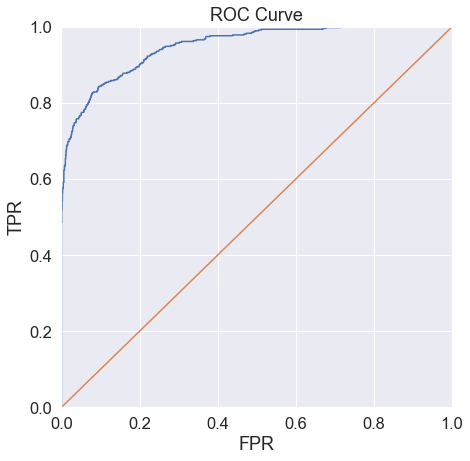

In [226]:
final_roc = roc(base_y_test, model.predict_proba(base_x_test)[:,1])

Очень неплохой результат. Посмотрим поближе на thresholds

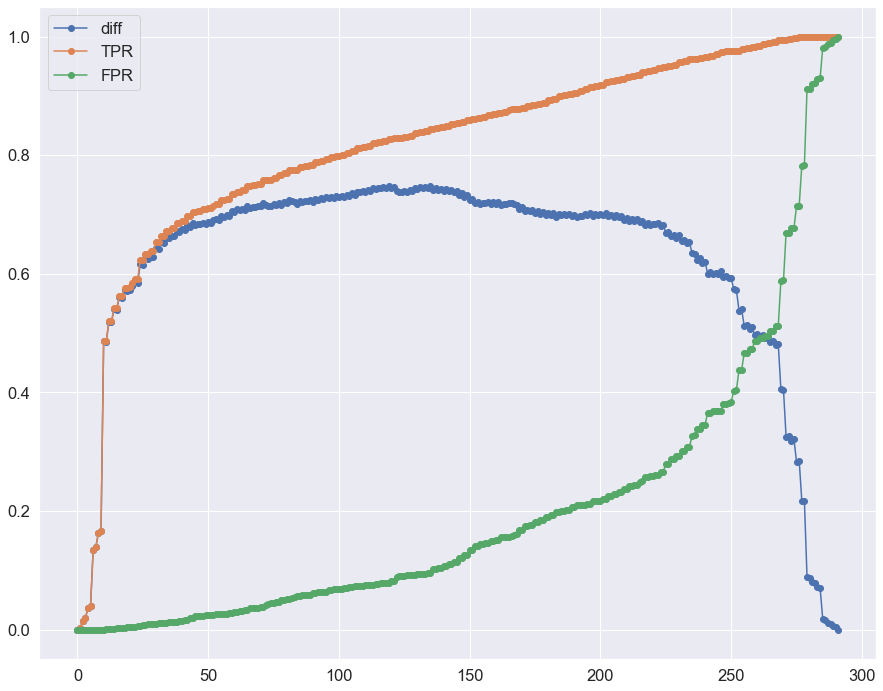

In [227]:
plt.figure(figsize=(15,12))
plt.plot(final_roc['diff'], marker='o')
plt.plot(final_roc['tpr'], marker='o')
plt.plot(final_roc['fpr'], marker='o')

plt.legend(['diff','TPR','FPR'])

Нас интересуют пороги с 50 до 200, масштабируемся:

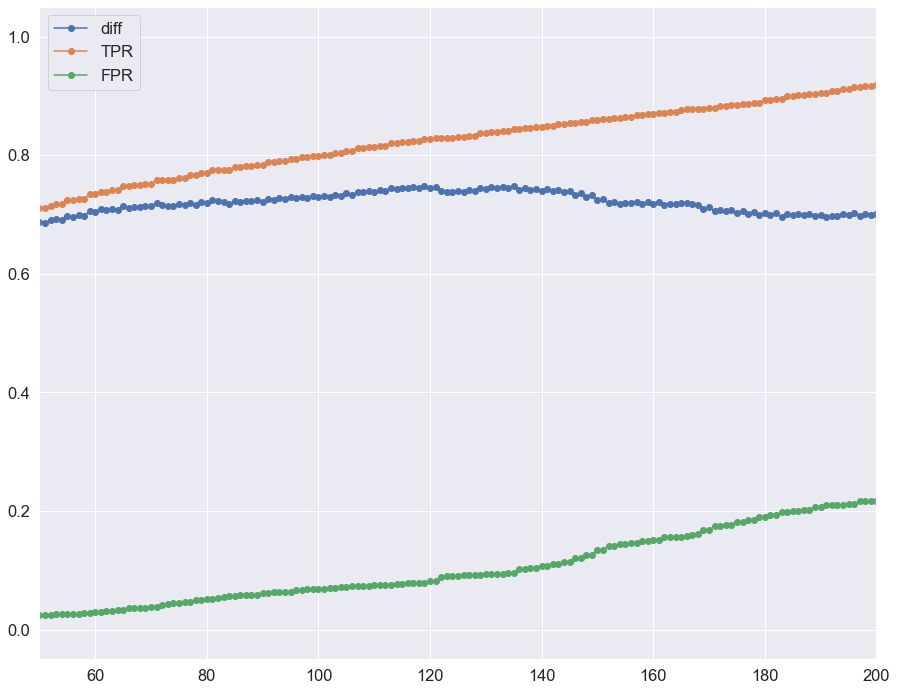

In [228]:
plt.figure(figsize=(15,12))
plt.plot(final_roc['diff'], marker='o')
plt.plot(final_roc['tpr'], marker='o')
plt.plot(final_roc['fpr'], marker='o')
plt.xlim(50,200)
plt.legend(['diff','TPR','FPR'])

In [229]:
final_roc[50:200].sort_values(by='diff', ascending=False).head(10)

tpr       fpr  threshold      diff
135  0.843683  0.096050   0.279403  0.747634
119  0.826552  0.079009   0.317126  0.747544
133  0.841542  0.094500   0.282087  0.747041
121  0.828694  0.082107   0.311304  0.746587
117  0.824411  0.078234   0.317514  0.746177
131  0.839400  0.093726   0.283718  0.745675
134  0.841542  0.096050   0.279867  0.745492
118  0.824411  0.079009   0.317371  0.745403
132  0.839400  0.094500   0.282992  0.744900
115  0.822270  0.077459   0.318812  0.744810

Здесь нам уже предстоит выбрать те значения, которые нас устроят: оптимально - чтобы разница между TPR (долей тех, кто действительно хочет уйти) и FPR (долей тех, кого мы ложно приняли за уходящих) была максимальна.

Кажется, что начать работу по удержанию с 85% тех, кто действительно хочет уйти и случайно зацепить 12% тех, кто уходить не хочет - очень неплохо.

# Отчет о проделанной работе

## Описание задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Нам были предоставлены 4 файла с данными о клиентах компании.

## Цель проекта и план работ

Перед нами была поставлена задача классификации при дисбалансе классов.



План работ:
1. Провести EDA файлов, избавиться от дубликатов и ошибок, объединить их в один файл.
2. Закодировать категориальные переменные (вручную, согласно некой "бизнес-логике")
3. Повторно провести EDA по объединенной таблице на предмет зависимостей переменных, проанализировать корреляцию $\phi_k$, изучить коллинеарность фичей и некоррелирующие с таргетом фичи.
4. Синтезировать новые / преобразовать старые фичи, чтобы в будущем улучшить качество модели
5. Финально отобрать признаки для обучения
6. Сбалансировать классы
7. Сделать пайплайн для моделей: one-hot encoder (из незакодированного вручную осталась всего 1 переменная) + scaler + gridsearchCV
8. Собрать архитектуру для нейронки
9. Обучить модели; отобрать лучшую по результатам кросс-валидации и проверить её на тестовой выборке

- Используемые метрики: ROC-AUC, F1
- Используемые модели: градиентный бустинг (catboost) + попробуем простую логистическую регрессию - у нас не так много данных; также попробуем что-нибудь нейронное - может получиться даже эффективнее катбуст

В итоге мы выполнили все пункты нашего плана, кроме устранения дисбаланса классов - в нем не оказалось необходимости

Возникло несколько трудностей:
1. Подтянуть названия признаков из трансформера - мы сделали свой.
2. Выбрать фичи в целом - мы использовали 3 разных подхода, чтобы вероятность получить точную модель была самой высокой

### EDA отдельных файлов

На данном этапе мы: 
- приводили данные к нужным нам типам; 
- убрали 11 записей с пропущенными данными;
- выделили таргет;
- посмотрели на зависимость таргета от даты заключения и расторжения договора;
- объединили таблицы.

### Кодирование категориальных переменных

На данном этапе:
- закодировали все "Yes" и "No" как нули и единицы;
- заменили пропущенные значения на новые, в зависимости от признака.
- закодировали признак __тип договора__ по его продолжительности;
- закодировали признак __услуги интернет__ по возрастанию "продвинутости" технологии;
- закодировали __пол и способ оплаты__ с помощью one-hot кодировки, чтобы не упустить корреляции

### Повторный EDA и корреляция $\phi_k$

- изучили зависимости наличия партнера и иждивенца с таргетом (зависимость обнаружилась);
- изучили зависимость пола и таргета (никакой зависимости);
- выявили очень слабо коррелирующие с таргетом фичи (phone, multiple_lines, gender)
- выявили коллинеарные фичи (activity, total_charges, monthly_charges, internet_service)

### Генерация фичей / feature engineering

На данном этапе мы попробовали очень много разных методов и подходов на основании корреляции фичей между собой / бизнес логики:
- создали несколько разновидностей фичи "дополнительные услуги", которые суммой/произведением объединяли как все дополнительные услуги провайдера (стриминг фильмов, онлайн защита и др.) так и по подгруппам;
- создали экспериментальную фичу __logreg_famiy__, которая являлась результатом предсказания таргета только по признакам __dependents и partner__ - мы построили логистическую регрессию на 2 признаках и вынули из неё коэффициенты, после чего эти коэффициенты мы применили к признакам, создав новую фичу;
- попробовали возводить в разные степени и логарифмировать непрерывные признаки - и в 2 случаях это дало эффект: __type и activity__

### Отбор признаков для обучения

Здесь мы воспользовались тремя стратегиями:
1. Выбрали неколлинеарные фичи, которые дают более или менее значимую корреляцию (выше 0.1)
2. Отобрали фичи с помощью __Sequential Floating Feature Selection__ на базе __случайного леса решений__, причем как прямого, так и обратного распространения: в результате мы получили 2 набора признаков, которые практически не разделялись между собой - и мы объединили их в 1 набор.
3. Отобрали фичи исключительно по матрице корреляции $\phi_k$, невзирая на коллинеарность; здесь уже порогом значимости корреляции было значение 0.2

### Балансировка классов

Балансировать классы мы не стали, поскольку плодить дубликаты было нецелесообразно; вместо этого мы передали параметр __auto_class_weight__ внутрь самой модели

### Пайплайн

Мы создали пайплайн, состоящий из 2 этапов: предобработка и модель

1. В качестве предобработки мы использовали кастомный ColumnTransformer, у которого есть важное свойство - из него можно вынуть имена фичей, которые мы имеем после трансформации.

    ColumnTransformer же, в свою очередь, осуществлял OHE и Stadard scaling предобработку

2. В качестве модели мы использовали GridSearchCV, у которого внутри, в свою очередь, уже лежали избранные нами модели: __CatBoostClassifier__ и __LogisticRegression__

### Сбор архитектуры для нейронки

При сборе архитектуре для нейронки мы руководствовались основными принципами библиотеки [__DatRet__](https://habr.com/ru/post/712088/) для табличных данных:
- 10 слоев;
- количество нейронов начинается с 512, уменьшается в 2 раза на каждом слое;
- кастомный оптимизатор __adam__

В итоге было решено отказаться от кастомного оптимизатора и такого количества слоёв: множественные эксперименты привели нас к текущей архитектуре нейронной сети.

Однако же мы собрали кастомную метрику - __roc-auc__ - чтобы отслеживать качество модели в процессе обучения

### Обучение и результаты моделей

В результате обучения пришло понимание, что нейронки очень сильно отстают от других моделей

Сводная по обучению моделей представлена ниже:

In [230]:
models_results.sort_values(by='mean_test_score', ascending=False)[['model_name','mean_test_score']]

model_name  mean_test_score
20      base features CatBoost         0.931073
21       SFS features CatBoost         0.919133
14  $\phi_k$ features CatBoost         0.918634
0              SFS features LR         0.844647
0         $\phi_k$ features LR         0.844647
0             base features LR         0.839672

Было решено выбрать CatBoost на базовых фичах - там используется меньше признаков

Её гиперпараметры:
- количество деревьев - 1050;
- глубина - 2
- коэффициент обучения - 0.33

In [231]:
print('ROC-AUC:')
print(roc_auc_score(base_y_test, cb_base_gscv.predict_proba(base_x_test)[:,1]))

ROC-AUC:
0.9493736077638468


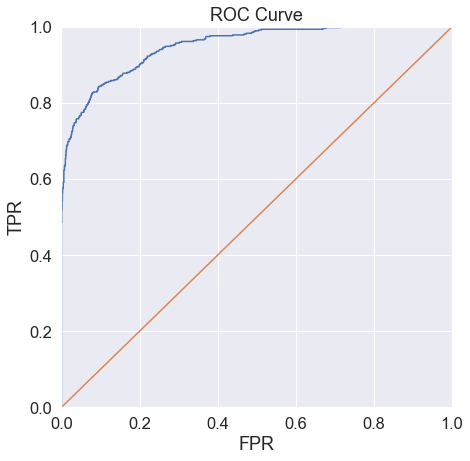

In [232]:
final_roc = roc(base_y_test, cb_base_gscv.predict_proba(base_x_test)[:,1])

Итоговый результат модели - __ROC-AUC__ - 0.9487

Посмотрим на самые "влиятельные" признаки:

In [233]:
FI = pd.DataFrame(model.feature_importances_, index=base_x_train.columns)
FI = FI.sort_values(by=0, ascending=False)

In [234]:
base_x_train.columns

Index(['paperless_billing', 'monthly_charges', 'online_security',
       'tech_support', 'senior_citizen', 'payment_method',
       'backup_plus_protection', 'family_logreg', 'type_3.5', 'activity_root'],
      dtype='object')

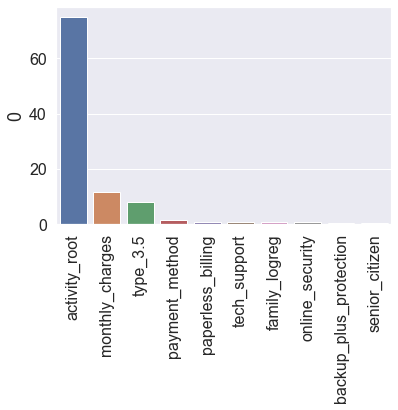

In [235]:
sns.barplot(FI.index, FI[0])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=90);

Как мы видим, в топ-5 попали 3 наши синтетические фичи:
- __activity_root__ - корень из синтетической фичи __activity__ - кол-во дней пользования услугами
- __type 3.5__ - закодированный в числовое представление тип договора, возведенный в степень 3.5
- __family_logreg__ - признак, сформированный логистической регрессией на основании предсказания таргета по 2 параметрам: __partner и dependents__